
# Tutorial 13: Self-Supervised Contrastive Learning with SimCLR

* **Author:** Phillip Lippe
* **License:** CC BY-SA
* **Generated:** 2023-10-12T10:05:10.778217

In this tutorial, we will take a closer look at self-supervised contrastive learning.
Self-supervised learning, or also sometimes called unsupervised learning, describes the scenario where we have given input data, but no accompanying labels to train in a classical supervised way.
However, this data still contains a lot of information from which we can learn: how are the images different from each other?
What patterns are descriptive for certain images?
Can we cluster the images?
To get an insight into these questions, we will implement a popular, simple contrastive learning method, SimCLR, and apply it to the STL10 dataset.
This notebook is part of a lecture series on Deep Learning at the University of Amsterdam.
The full list of tutorials can be found at https://uvadlc-notebooks.rtfd.io.


---
Open in [Open In Colab{height="20px" width="117px"}](https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/course_UvA-DL/13-contrastive-learning.ipynb)

Give us a ⭐ [on Github](https://www.github.com/Lightning-AI/lightning/)
| Check out [the documentation](https://pytorch-lightning.readthedocs.io/en/stable/)
| Join us [on Slack](https://www.pytorchlightning.ai/community)

## Setup
This notebook requires some packages besides pytorch-lightning.

<div class="center-wrapper"><div class="video-wrapper"><iframe src="https://www.youtube.com/embed/waVZDFR-06U" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></div></div>
Methods for self-supervised learning try to learn as much as possible from the data alone, so it can quickly be finetuned for a specific classification task.
The benefit of self-supervised learning is that a large dataset can often easily be obtained.
For instance, if we want to train a vision model on semantic segmentation for autonomous driving, we can collect large amounts of data by simply installing a camera in a car, and driving through a city for an hour.
In contrast, if we would want to do supervised learning, we would have to manually label all those images before training a model.
This is extremely expensive, and would likely take a couple of months to manually label the same amount of data.
Further, self-supervised learning can provide an alternative to transfer learning from models pretrained on ImageNet since we could pretrain a model on a specific dataset/situation, e.g. traffic scenarios for autonomous driving.

Within the last two years, a lot of new approaches have been proposed for self-supervised learning, in particular for images, that have resulted in great improvements over supervised models when few labels are available.
The subfield that we will focus on in this tutorial is contrastive learning.
Contrastive learning is motivated by the question mentioned above: how are images different from each other?
Specifically, contrastive learning methods train a model to cluster an image and its slightly augmented version in latent space, while the distance to other images should be maximized.
A very recent and simple method for this is [SimCLR](https://arxiv.org/abs/2006.10029), which is visualized below (figure credit - [Ting Chen et al. ](https://simclr.github.io/)).

The general setup is that we are given a dataset of images without any labels, and want to train a model on this data such that it can quickly adapt to any image recognition task afterward.
During each training iteration, we sample a batch of images as usual.
For each image, we create two versions by applying data augmentation techniques like cropping, Gaussian noise, blurring, etc.
An example of such is shown on the left with the image of the dog.
We will go into the details and effects of the chosen augmentation techniques later.
On those images, we apply a CNN like ResNet and obtain as output a 1D feature vector on which we apply a small MLP.
The output features of the two augmented images are then trained to be close to each other, while all other images in that batch should be as different as possible.
This way, the model has to learn to recognize the content of the image that remains unchanged under the data augmentations, such as objects which we usually care about in supervised tasks.

We will now implement this framework ourselves and discuss further details along the way.
Let's first start with importing our standard libraries below:

In [1]:
import os
import urllib.request
from copy import deepcopy
from urllib.error import HTTPError

import lightning as L
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import STL10
from tqdm.notebook import tqdm

plt.set_cmap("cividis")
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.set()

# Import tensorboard
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/ContrastiveLearning_VIT/")
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

MODEL="microsoft/swinv2-tiny-patch4-window8-256"

# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Seed set to 42


Device: cuda:0
Number of workers: 80


<Figure size 640x480 with 0 Axes>

## SimCLR

We will start our exploration of contrastive learning by discussing the effect of different data augmentation techniques, and how we can implement an efficient data loader for such.
Next, we implement SimCLR with PyTorch Lightning, and finally train it on a large, unlabeled dataset.

### Data Augmentation for Contrastive Learning

To allow efficient training, we need to prepare the data loading such that we sample two different, random augmentations for each image in the batch.
The easiest way to do this is by creating a transformation that, when being called, applies a set of data augmentations to an image twice.
This is implemented in the class `ContrastiveTransformations` below:

In [2]:
from transformers import AutoImageProcessor
processor = AutoImageProcessor.from_pretrained(MODEL)

class ContrastiveTransformations:
    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [processor(self.base_transforms(x), return_tensors="pt")["pixel_values"].squeeze() for i in range(self.n_views)]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


The contrastive learning framework can easily be extended to have more _positive_ examples by sampling more than two augmentations of the same image.
However, the most efficient training is usually obtained by using only two.

Next, we can look at the specific augmentations we want to apply.
The choice of the data augmentation to use is the most crucial hyperparameter in SimCLR since it directly affects how the latent space is structured, and what patterns might be learned from the data.
Let's first take a look at some of the most popular data augmentations (figure credit - [Ting Chen and Geoffrey Hinton](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html)):

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/13-contrastive-learning/simclr_data_augmentations.jpg" width="800px" style="padding-top: 10px; padding-bottom: 10px"></center>

All of them can be used, but it turns out that two augmentations stand out in their importance: crop-and-resize, and color distortion.
Interestingly, however, they only lead to strong performance if they have been used together as discussed by [Ting Chen et al. ](https://arxiv.org/abs/2006.10029) in their SimCLR paper.
When performing randomly cropping and resizing, we can distinguish between two situations: (a) cropped image A provides a local view of cropped image B, or (b) cropped images C and D show neighboring views of the same image (figure credit - [Ting Chen and Geoffrey Hinton](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html)).

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/13-contrastive-learning/crop_views.svg" width="400px" style="padding-top: 20px; padding-bottom: 0px"></center>

While situation (a) requires the model to learn some sort of scale invariance to make crops A and B similar in latent space, situation (b) is more challenging since the model needs to recognize an object beyond its limited view.
However, without color distortion, there is a loophole that the model can exploit, namely that different crops of the same image usually look very similar in color space.
Consider the picture of the dog above.
Simply from the color of the fur and the green color tone of the background, you can reason that two patches belong to the same image without actually recognizing the dog in the picture.
In this case, the model might end up focusing only on the color histograms of the images, and ignore other more generalizable features.
If, however, we distort the colors in the two patches randomly and independently of each other, the model cannot rely on this simple feature anymore.
Hence, by combining random cropping and color distortions, the model can only match two patches by learning generalizable representations.

Overall, for our experiments, we apply a set of 5 transformations following the original SimCLR setup: random horizontal flip, crop-and-resize, color distortion, random grayscale, and gaussian blur.
In comparison to the [original implementation](https://github.com/google-research/simclr), we reduce the effect of the color jitter slightly (0.5 instead of 0.8 for brightness, contrast, and saturation, and 0.1 instead of 0.2 for hue).
In our experiments, this setting obtained better performance and was faster and more stable to train.
If, for instance, the brightness scale highly varies in a dataset, the
original settings can be more beneficial since the model can't rely on
this information anymore to distinguish between images.

In [3]:
contrast_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=96),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=9)
    ]
)

After discussing the data augmentation techniques, we can now focus on the dataset.
In this tutorial, we will use the [STL10 dataset](https://cs.stanford.edu/~acoates/stl10/), which, similarly to CIFAR10, contains images of 10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.
However, the images have a higher resolution, namely $96\times 96$ pixels, and we are only provided with 500 labeled images per class.
Additionally, we have a much larger set of $100,000$ unlabeled images which are similar to the training images but are sampled from a wider range of animals and vehicles.
This makes the dataset ideal to showcase the benefits that self-supervised learning offers.

Luckily, the STL10 dataset is provided through torchvision.
Keep in mind, however, that since this dataset is relatively large and has a considerably higher resolution than CIFAR10, it requires more disk space (~3GB) and takes a bit of time to download.
For our initial discussion of self-supervised learning and SimCLR, we
will create two data loaders with our contrastive transformations above:
the `unlabeled_data` will be used to train our model via contrastive
learning, and `train_data_contrast` will be used as a validation set in
contrastive learning.

In [4]:
unlabeled_data = STL10(
    root=DATASET_PATH,
    split="train",
    download=True,
    transform=ContrastiveTransformations(contrast_transforms, n_views=2),
)
train_data_contrast = STL10(
    root=DATASET_PATH,
    split="test",
    download=True,
    transform=ContrastiveTransformations(contrast_transforms, n_views=2),
)
train_data_contrast = data.Subset(train_data_contrast, torch.arange(400))

Files already downloaded and verified
Files already downloaded and verified



  6%|▌         | 152043520/2640397119 [00:09<02:04, 19966905.45it/s]


  6%|▌         | 154861568/2640397119 [00:09<01:53, 21926191.41it/s]


  6%|▌         | 157712384/2640397119 [00:09<01:45, 23633111.23it/s]


  6%|▌         | 160432128/2640397119 [00:09<01:40, 24578038.12it/s]


  6%|▌         | 163250176/2640397119 [00:09<01:36, 25574607.13it/s]


  6%|▋         | 166100992/2640397119 [00:09<01:33, 26377903.03it/s]


  6%|▋         | 168886272/2640397119 [00:09<01:32, 26781631.68it/s]


  7%|▋         | 171671552/2640397119 [00:09<01:31, 27063909.43it/s]


  7%|▋         | 174456832/2640397119 [00:09<01:30, 27276192.41it/s]


  7%|▋         | 177242112/2640397119 [00:10<01:32, 26738591.92it/s]


  7%|▋         | 180060160/2640397119 [00:10<01:30, 27145731.43it/s]


  7%|▋         | 182845440/2640397119 [00:10<01:30, 27268333.29it/s]


  7%|▋         | 185663488/2640397119 [00:10<01:29, 27411713.30it/s]


  7%|▋         | 188547072/2640397119 [00:10<01:28, 27643635.30it/s]


  7%|▋         | 191332352/2640397119 [00:10<01:29, 27350126.98it/s]


  7%|▋         | 194084864/2640397119 [00:10<01:35, 25659472.04it/s]


  7%|▋         | 196706304/2640397119 [00:10<01:39, 24566291.18it/s]


  8%|▊         | 199196672/2640397119 [00:10<01:42, 23850515.08it/s]


  8%|▊         | 201621504/2640397119 [00:11<01:42, 23692286.36it/s]


  8%|▊         | 204013568/2640397119 [00:11<01:43, 23580217.95it/s]


  8%|▊         | 206405632/2640397119 [00:11<01:43, 23619501.00it/s]


  8%|▊         | 208797696/2640397119 [00:11<01:42, 23609729.32it/s]


  8%|▊         | 211255296/2640397119 [00:11<01:41, 23877895.37it/s]


  8%|▊         | 213647360/2640397119 [00:11<01:41, 23797490.25it/s]


  8%|▊         | 216170496/2640397119 [00:11<01:40, 24208940.16it/s]


  8%|▊         | 218595328/2640397119 [00:11<01:40, 24163628.11it/s]


  8%|▊         | 221184000/2640397119 [00:11<01:38, 24674093.74it/s]


  8%|▊         | 223674368/2640397119 [00:11<01:41, 23912162.16it/s]


  9%|▊         | 226099200/2640397119 [00:12<01:51, 21696801.73it/s]


  9%|▊         | 228327424/2640397119 [00:12<01:58, 20429316.25it/s]


  9%|▊         | 230424576/2640397119 [00:12<02:00, 19950102.48it/s]


  9%|▉         | 232456192/2640397119 [00:12<02:04, 19280127.00it/s]


  9%|▉         | 234422272/2640397119 [00:12<02:16, 17613322.34it/s]


  9%|▉         | 236224512/2640397119 [00:12<02:19, 17206853.11it/s]


  9%|▉         | 238354432/2640397119 [00:12<02:11, 18202642.94it/s]


  9%|▉         | 240222208/2640397119 [00:12<02:13, 17971572.46it/s]


  9%|▉         | 242253824/2640397119 [00:13<02:09, 18550334.57it/s]


  9%|▉         | 244154368/2640397119 [00:13<02:09, 18436396.42it/s]


  9%|▉         | 246153216/2640397119 [00:13<02:07, 18847741.15it/s]


  9%|▉         | 248053760/2640397119 [00:13<02:07, 18743483.55it/s]


  9%|▉         | 250118144/2640397119 [00:13<02:04, 19171225.48it/s]


 10%|▉         | 252051456/2640397119 [00:13<02:05, 19006613.95it/s]


 10%|▉         | 254115840/2640397119 [00:13<02:02, 19468836.18it/s]


 10%|▉         | 256081920/2640397119 [00:13<02:03, 19247175.87it/s]


 10%|▉         | 258146304/2640397119 [00:13<02:01, 19589691.05it/s]


 10%|▉         | 260112384/2640397119 [00:13<02:02, 19498276.22it/s]


 10%|▉         | 262078464/2640397119 [00:14<02:13, 17876171.13it/s]


 10%|█         | 264208384/2640397119 [00:14<02:07, 18624464.65it/s]


 10%|█         | 266108928/2640397119 [00:14<02:18, 17168977.25it/s]


 10%|█         | 267878400/2640397119 [00:14<02:25, 16353766.48it/s]


 10%|█         | 269549568/2640397119 [00:14<02:32, 15528316.42it/s]


 10%|█         | 271155200/2640397119 [00:14<02:34, 15319428.35it/s]


 10%|█         | 272728064/2640397119 [00:14<02:35, 15252494.96it/s]


 10%|█         | 274268160/2640397119 [00:14<02:40, 14713217.68it/s]


 10%|█         | 275808256/2640397119 [00:14<02:39, 14867091.36it/s]


 11%|█         | 277315584/2640397119 [00:15<02:39, 14796255.39it/s]


 11%|█         | 278888448/2640397119 [00:15<02:37, 15007641.25it/s]


 11%|█         | 280395776/2640397119 [00:15<02:37, 15010910.42it/s]


 11%|█         | 281968640/2640397119 [00:15<02:35, 15176754.50it/s]


 11%|█         | 283508736/2640397119 [00:15<02:35, 15180919.08it/s]


 11%|█         | 285114368/2640397119 [00:15<02:33, 15332659.27it/s]


 11%|█         | 286687232/2640397119 [00:15<02:33, 15284296.35it/s]


 11%|█         | 288292864/2640397119 [00:15<02:31, 15486115.03it/s]


 11%|█         | 289865728/2640397119 [00:15<02:31, 15535600.22it/s]


 11%|█         | 291471360/2640397119 [00:16<02:30, 15589214.81it/s]


 11%|█         | 293076992/2640397119 [00:16<02:32, 15429976.62it/s]


 11%|█         | 294649856/2640397119 [00:16<02:38, 14828248.38it/s]


 11%|█         | 296517632/2640397119 [00:16<02:28, 15833430.80it/s]


 11%|█▏        | 298123264/2640397119 [00:16<02:31, 15438822.15it/s]


 11%|█▏        | 299859968/2640397119 [00:16<02:26, 15923275.97it/s]


 11%|█▏        | 301465600/2640397119 [00:16<02:29, 15682694.38it/s]


 11%|█▏        | 303169536/2640397119 [00:16<02:25, 16022463.31it/s]


 12%|█▏        | 304807936/2640397119 [00:16<02:27, 15866467.79it/s]


 12%|█▏        | 306544640/2640397119 [00:16<02:25, 16079831.54it/s]


 12%|█▏        | 308183040/2640397119 [00:17<02:29, 15614859.90it/s]


 12%|█▏        | 309755904/2640397119 [00:17<02:38, 14749837.36it/s]


 12%|█▏        | 311263232/2640397119 [00:17<02:51, 13599560.11it/s]


 12%|█▏        | 312672256/2640397119 [00:17<02:58, 13039339.56it/s]


 12%|█▏        | 314015744/2640397119 [00:17<02:58, 13068044.94it/s]


 12%|█▏        | 315359232/2640397119 [00:17<03:06, 12438539.80it/s]


 12%|█▏        | 316669952/2640397119 [00:17<03:04, 12567163.74it/s]


 12%|█▏        | 317947904/2640397119 [00:18<04:45, 8122969.31it/s] 


 12%|█▏        | 318963712/2640397119 [00:18<04:49, 8028329.46it/s]


 12%|█▏        | 320503808/2640397119 [00:18<04:03, 9544640.15it/s]


 12%|█▏        | 321617920/2640397119 [00:18<03:58, 9707554.02it/s]


 12%|█▏        | 323092480/2640397119 [00:18<03:37, 10638838.55it/s]


 12%|█▏        | 324435968/2640397119 [00:18<03:24, 11342246.16it/s]


 12%|█▏        | 325713920/2640397119 [00:18<03:20, 11568783.49it/s]


 12%|█▏        | 327090176/2640397119 [00:18<03:10, 12126781.03it/s]


 12%|█▏        | 328368128/2640397119 [00:18<03:09, 12194152.26it/s]


 12%|█▏        | 329744384/2640397119 [00:19<03:03, 12599231.90it/s]


 13%|█▎        | 331055104/2640397119 [00:19<03:04, 12513602.09it/s]


 13%|█▎        | 332464128/2640397119 [00:19<02:58, 12937779.97it/s]


 13%|█▎        | 333774848/2640397119 [00:19<03:06, 12340002.61it/s]


 13%|█▎        | 335478784/2640397119 [00:19<02:51, 13442553.40it/s]


 13%|█▎        | 336855040/2640397119 [00:19<02:55, 13103477.21it/s]


 13%|█▎        | 338198528/2640397119 [00:19<02:54, 13186675.62it/s]


 13%|█▎        | 339542016/2640397119 [00:19<02:55, 13124228.31it/s]


 13%|█▎        | 340951040/2640397119 [00:19<02:54, 13164933.42it/s]


 13%|█▎        | 342294528/2640397119 [00:19<02:53, 13235944.72it/s]


 13%|█▎        | 343703552/2640397119 [00:20<02:53, 13208588.34it/s]


 13%|█▎        | 345112576/2640397119 [00:20<02:50, 13429639.95it/s]


 13%|█▎        | 346488832/2640397119 [00:20<02:56, 12991129.67it/s]


 13%|█▎        | 348258304/2640397119 [00:20<02:40, 14269594.40it/s]


 13%|█▎        | 349700096/2640397119 [00:20<02:50, 13419679.64it/s]


 13%|█▎        | 351076352/2640397119 [00:20<02:51, 13365597.77it/s]


 13%|█▎        | 352485376/2640397119 [00:20<02:49, 13522164.10it/s]


 13%|█▎        | 353894400/2640397119 [00:20<02:53, 13201778.51it/s]


 13%|█▎        | 355434496/2640397119 [00:20<02:46, 13727246.43it/s]


 14%|█▎        | 356843520/2640397119 [00:21<03:17, 11562652.89it/s]


 14%|█▎        | 358088704/2640397119 [00:21<03:50, 9911815.95it/s] 


 14%|█▎        | 359170048/2640397119 [00:21<04:18, 8821128.24it/s]


 14%|█▎        | 360218624/2640397119 [00:21<04:10, 9106559.20it/s]


 14%|█▎        | 361463808/2640397119 [00:21<03:53, 9750430.75it/s]


 14%|█▎        | 362741760/2640397119 [00:21<03:38, 10443963.62it/s]


 14%|█▍        | 364314624/2640397119 [00:21<03:13, 11759373.83it/s]


 14%|█▍        | 365559808/2640397119 [00:21<03:11, 11906534.23it/s]


 14%|█▍        | 367132672/2640397119 [00:22<02:56, 12902891.18it/s]


 14%|█▍        | 368476160/2640397119 [00:22<02:56, 12859149.01it/s]


 14%|█▍        | 369983488/2640397119 [00:22<02:48, 13454014.12it/s]


 14%|█▍        | 371359744/2640397119 [00:22<02:52, 13165054.42it/s]


 14%|█▍        | 372867072/2640397119 [00:22<02:47, 13533028.47it/s]


 14%|█▍        | 374243328/2640397119 [00:22<02:46, 13578589.91it/s]


 14%|█▍        | 375717888/2640397119 [00:22<02:46, 13620374.51it/s]


 14%|█▍        | 377159680/2640397119 [00:22<02:43, 13826791.96it/s]


 14%|█▍        | 378568704/2640397119 [00:22<02:45, 13653338.56it/s]


 14%|█▍        | 380043264/2640397119 [00:23<02:42, 13898458.06it/s]


 14%|█▍        | 381452288/2640397119 [00:23<02:44, 13727708.90it/s]


 15%|█▍        | 382926848/2640397119 [00:23<02:41, 13995861.91it/s]


 15%|█▍        | 384335872/2640397119 [00:23<02:44, 13737047.23it/s]


 15%|█▍        | 385875968/2640397119 [00:23<02:38, 14211016.62it/s]


 15%|█▍        | 387317760/2640397119 [00:23<02:44, 13684840.12it/s]


 15%|█▍        | 388825088/2640397119 [00:23<02:40, 14071446.25it/s]


 15%|█▍        | 390266880/2640397119 [00:23<02:43, 13746374.86it/s]


 15%|█▍        | 391708672/2640397119 [00:23<02:42, 13838820.01it/s]


 15%|█▍        | 393117696/2640397119 [00:23<02:43, 13771488.02it/s]


 15%|█▍        | 394559488/2640397119 [00:24<02:43, 13770297.68it/s]


 15%|█▍        | 395968512/2640397119 [00:24<02:42, 13783153.83it/s]


 15%|█▌        | 397377536/2640397119 [00:24<02:42, 13800976.68it/s]


 15%|█▌        | 398786560/2640397119 [00:24<02:52, 12973556.77it/s]


 15%|█▌        | 400097280/2640397119 [00:24<02:58, 12556159.03it/s]


 15%|█▌        | 401375232/2640397119 [00:24<03:11, 11715160.42it/s]


 15%|█▌        | 402587648/2640397119 [00:24<03:18, 11245819.45it/s]


 15%|█▌        | 403734528/2640397119 [00:24<03:21, 11088921.91it/s]


 15%|█▌        | 404881408/2640397119 [00:24<03:30, 10617226.04it/s]


 15%|█▌        | 406093824/2640397119 [00:25<03:27, 10770551.15it/s]


 15%|█▌        | 407207936/2640397119 [00:25<03:27, 10783504.25it/s]


 15%|█▌        | 408322048/2640397119 [00:25<03:25, 10863248.38it/s]


 16%|█▌        | 409436160/2640397119 [00:25<03:24, 10895324.19it/s]


 16%|█▌        | 410583040/2640397119 [00:25<03:22, 11007348.30it/s]


 16%|█▌        | 411697152/2640397119 [00:25<03:24, 10917283.85it/s]


 16%|█▌        | 412909568/2640397119 [00:25<03:21, 11079885.57it/s]


 16%|█▌        | 414121984/2640397119 [00:25<03:16, 11308609.07it/s]


 16%|█▌        | 415268864/2640397119 [00:25<03:16, 11341485.86it/s]


 16%|█▌        | 416448512/2640397119 [00:26<03:14, 11462399.76it/s]


 16%|█▌        | 417660928/2640397119 [00:26<03:10, 11651957.65it/s]


 16%|█▌        | 418840576/2640397119 [00:26<03:11, 11624123.40it/s]


 16%|█▌        | 420085760/2640397119 [00:26<03:08, 11808196.75it/s]


 16%|█▌        | 421298176/2640397119 [00:26<03:07, 11836051.23it/s]


 16%|█▌        | 422576128/2640397119 [00:26<03:04, 12004245.36it/s]


 16%|█▌        | 423788544/2640397119 [00:26<03:04, 12026854.16it/s]


 16%|█▌        | 425099264/2640397119 [00:26<03:01, 12223648.68it/s]


 16%|█▌        | 426344448/2640397119 [00:26<03:00, 12245523.08it/s]


 16%|█▌        | 427622400/2640397119 [00:26<02:59, 12304792.06it/s]


 16%|█▌        | 428900352/2640397119 [00:27<02:58, 12422997.88it/s]


 16%|█▋        | 430211072/2640397119 [00:27<02:57, 12433702.55it/s]


 16%|█▋        | 431521792/2640397119 [00:27<02:54, 12628816.89it/s]


 16%|█▋        | 432832512/2640397119 [00:27<02:55, 12614086.15it/s]


 16%|█▋        | 434176000/2640397119 [00:27<02:51, 12847615.94it/s]


 16%|█▋        | 435486720/2640397119 [00:27<02:54, 12635143.91it/s]


 17%|█▋        | 436830208/2640397119 [00:27<02:52, 12795638.63it/s]


 17%|█▋        | 438140928/2640397119 [00:27<02:52, 12792661.72it/s]


 17%|█▋        | 439517184/2640397119 [00:27<02:49, 13013693.47it/s]


 17%|█▋        | 440827904/2640397119 [00:27<02:49, 12974877.21it/s]


 17%|█▋        | 442236928/2640397119 [00:28<02:46, 13210605.33it/s]


 17%|█▋        | 443580416/2640397119 [00:28<02:47, 13089840.13it/s]


 17%|█▋        | 444956672/2640397119 [00:28<02:45, 13277995.19it/s]


 17%|█▋        | 446300160/2640397119 [00:28<02:47, 13074946.43it/s]


 17%|█▋        | 447774720/2640397119 [00:28<02:42, 13476286.77it/s]


 17%|█▋        | 449150976/2640397119 [00:28<02:46, 13136567.65it/s]


 17%|█▋        | 450658304/2640397119 [00:28<02:40, 13636248.27it/s]


 17%|█▋        | 452034560/2640397119 [00:28<02:44, 13294094.26it/s]


 17%|█▋        | 453509120/2640397119 [00:28<02:40, 13590680.84it/s]


 17%|█▋        | 454885376/2640397119 [00:29<02:41, 13495823.46it/s]


 17%|█▋        | 456294400/2640397119 [00:29<02:39, 13655386.39it/s]


 17%|█▋        | 457670656/2640397119 [00:29<02:41, 13522256.87it/s]


 17%|█▋        | 459112448/2640397119 [00:29<02:40, 13595501.60it/s]


 17%|█▋        | 460521472/2640397119 [00:29<02:39, 13652947.76it/s]


 17%|█▋        | 461897728/2640397119 [00:29<02:39, 13632832.55it/s]


 18%|█▊        | 463306752/2640397119 [00:29<02:39, 13684999.68it/s]


 18%|█▊        | 464715776/2640397119 [00:29<02:39, 13672091.23it/s]


 18%|█▊        | 466124800/2640397119 [00:29<02:38, 13760630.55it/s]


 18%|█▊        | 467533824/2640397119 [00:29<02:37, 13775131.74it/s]


 18%|█▊        | 468942848/2640397119 [00:30<02:36, 13844793.24it/s]


 18%|█▊        | 470351872/2640397119 [00:30<02:36, 13834181.43it/s]


 18%|█▊        | 471760896/2640397119 [00:30<02:36, 13872745.98it/s]


 18%|█▊        | 473169920/2640397119 [00:30<02:37, 13794773.49it/s]


 18%|█▊        | 474578944/2640397119 [00:30<02:36, 13858244.91it/s]


 18%|█▊        | 475987968/2640397119 [00:30<02:36, 13822260.83it/s]


 18%|█▊        | 477429760/2640397119 [00:30<02:35, 13903213.82it/s]


 18%|█▊        | 478838784/2640397119 [00:30<02:36, 13797758.28it/s]


 18%|█▊        | 480280576/2640397119 [00:30<02:35, 13905146.75it/s]


 18%|█▊        | 481689600/2640397119 [00:30<02:37, 13744252.45it/s]


 18%|█▊        | 483131392/2640397119 [00:31<02:35, 13914331.01it/s]


 18%|█▊        | 484540416/2640397119 [00:31<02:36, 13759295.41it/s]


 18%|█▊        | 485982208/2640397119 [00:31<02:34, 13951910.85it/s]


 18%|█▊        | 487391232/2640397119 [00:31<02:36, 13736219.35it/s]


 19%|█▊        | 488898560/2640397119 [00:31<02:32, 14120862.62it/s]


 19%|█▊        | 490340352/2640397119 [00:31<02:36, 13756039.98it/s]


 19%|█▊        | 491847680/2640397119 [00:31<02:33, 14015007.81it/s]


 19%|█▊        | 493256704/2640397119 [00:31<02:35, 13765319.84it/s]


 19%|█▊        | 494731264/2640397119 [00:31<02:32, 14045623.86it/s]


 19%|█▉        | 496140288/2640397119 [00:31<02:34, 13841397.44it/s]


 19%|█▉        | 497582080/2640397119 [00:32<02:33, 13966037.04it/s]


 19%|█▉        | 498991104/2640397119 [00:32<02:34, 13855081.88it/s]


 19%|█▉        | 500432896/2640397119 [00:32<02:34, 13860634.23it/s]


 19%|█▉        | 501841920/2640397119 [00:32<02:34, 13812106.84it/s]


 19%|█▉        | 503283712/2640397119 [00:32<02:34, 13818239.06it/s]


 19%|█▉        | 504725504/2640397119 [00:32<02:33, 13890199.43it/s]


 19%|█▉        | 506134528/2640397119 [00:32<02:35, 13730632.26it/s]


 19%|█▉        | 507576320/2640397119 [00:32<02:33, 13884616.87it/s]


 19%|█▉        | 508985344/2640397119 [00:32<02:34, 13782422.74it/s]


 19%|█▉        | 510427136/2640397119 [00:33<02:32, 13942903.06it/s]


 19%|█▉        | 511836160/2640397119 [00:33<02:34, 13753572.44it/s]


 19%|█▉        | 513310720/2640397119 [00:33<02:31, 14008770.11it/s]


 19%|█▉        | 514719744/2640397119 [00:33<02:35, 13683723.21it/s]


 20%|█▉        | 516259840/2640397119 [00:33<02:29, 14163040.68it/s]


 20%|█▉        | 517701632/2640397119 [00:33<02:33, 13792389.14it/s]


 20%|█▉        | 519176192/2640397119 [00:33<02:32, 13937243.05it/s]


 20%|█▉        | 520585216/2640397119 [00:33<02:34, 13753967.81it/s]


 20%|█▉        | 522027008/2640397119 [00:33<02:33, 13784600.99it/s]


 20%|█▉        | 523436032/2640397119 [00:33<02:32, 13843230.60it/s]


 20%|█▉        | 524845056/2640397119 [00:34<02:32, 13836896.23it/s]


 20%|█▉        | 526254080/2640397119 [00:34<02:32, 13881484.63it/s]


 20%|█▉        | 527695872/2640397119 [00:34<02:31, 13917349.06it/s]


 20%|██        | 529104896/2640397119 [00:34<02:31, 13929303.00it/s]


 20%|██        | 530546688/2640397119 [00:34<02:30, 13996888.98it/s]


 20%|██        | 531955712/2640397119 [00:34<02:31, 13889776.00it/s]


 20%|██        | 533397504/2640397119 [00:34<02:30, 14044624.14it/s]


 20%|██        | 534806528/2640397119 [00:34<02:32, 13837690.57it/s]


 20%|██        | 536313856/2640397119 [00:34<02:30, 14006106.00it/s]


 20%|██        | 537722880/2640397119 [00:34<02:30, 13952150.79it/s]


 20%|██        | 539164672/2640397119 [00:35<02:29, 14040635.77it/s]


 20%|██        | 540573696/2640397119 [00:35<02:31, 13852256.19it/s]


 21%|██        | 542015488/2640397119 [00:35<02:29, 14012277.63it/s]


 21%|██        | 543424512/2640397119 [00:35<02:31, 13862748.80it/s]


 21%|██        | 544899072/2640397119 [00:35<02:28, 14116079.70it/s]


 21%|██        | 546340864/2640397119 [00:35<02:29, 14012613.75it/s]


 21%|██        | 547848192/2640397119 [00:35<02:26, 14297061.97it/s]


 21%|██        | 549289984/2640397119 [00:35<02:28, 14121461.82it/s]


 21%|██        | 550764544/2640397119 [00:35<02:26, 14237280.73it/s]


 21%|██        | 552206336/2640397119 [00:36<02:27, 14130260.55it/s]


 21%|██        | 553680896/2640397119 [00:36<02:26, 14292124.21it/s]


 21%|██        | 555122688/2640397119 [00:36<02:26, 14234599.49it/s]


 21%|██        | 556630016/2640397119 [00:36<02:25, 14351200.15it/s]


 21%|██        | 558071808/2640397119 [00:36<02:25, 14341367.22it/s]


 21%|██        | 559546368/2640397119 [00:36<02:24, 14432806.44it/s]


 21%|██        | 561020928/2640397119 [00:36<02:25, 14334360.53it/s]


 21%|██▏       | 562528256/2640397119 [00:36<02:24, 14421374.99it/s]


 21%|██▏       | 564002816/2640397119 [00:36<02:23, 14446634.83it/s]


 21%|██▏       | 565542912/2640397119 [00:36<02:21, 14615258.27it/s]


 21%|██▏       | 567017472/2640397119 [00:37<02:22, 14560287.71it/s]


 22%|██▏       | 568524800/2640397119 [00:37<02:21, 14607623.29it/s]


 22%|██▏       | 569999360/2640397119 [00:37<02:21, 14642215.55it/s]


 22%|██▏       | 571572224/2640397119 [00:37<02:20, 14715170.69it/s]


 22%|██▏       | 573079552/2640397119 [00:37<02:19, 14801717.89it/s]


 22%|██▏       | 574619648/2640397119 [00:37<02:18, 14946095.35it/s]


 22%|██▏       | 576126976/2640397119 [00:37<02:18, 14932165.45it/s]


 22%|██▏       | 577732608/2640397119 [00:37<02:17, 14989539.29it/s]


 22%|██▏       | 579239936/2640397119 [00:37<02:17, 15001845.94it/s]


 22%|██▏       | 580845568/2640397119 [00:37<02:15, 15184011.98it/s]


 22%|██▏       | 582385664/2640397119 [00:38<02:15, 15173776.42it/s]


 22%|██▏       | 583991296/2640397119 [00:38<02:13, 15388325.14it/s]


 22%|██▏       | 585531392/2640397119 [00:38<02:14, 15321291.92it/s]


 22%|██▏       | 587202560/2640397119 [00:38<02:11, 15563955.29it/s]


 22%|██▏       | 588775424/2640397119 [00:38<02:13, 15423140.92it/s]


 22%|██▏       | 590413824/2640397119 [00:38<02:10, 15692903.69it/s]


 22%|██▏       | 591986688/2640397119 [00:38<02:11, 15561123.88it/s]


 22%|██▏       | 593690624/2640397119 [00:38<02:09, 15862316.06it/s]


 23%|██▎       | 595296256/2640397119 [00:38<02:10, 15726275.78it/s]


 23%|██▎       | 597032960/2640397119 [00:38<02:06, 16141867.63it/s]


 23%|██▎       | 598671360/2640397119 [00:39<02:08, 15924413.74it/s]


 23%|██▎       | 600473600/2640397119 [00:39<02:04, 16377162.53it/s]


 23%|██▎       | 602144768/2640397119 [00:39<02:05, 16247359.07it/s]


 23%|██▎       | 603914240/2640397119 [00:39<02:02, 16596590.06it/s]


 23%|██▎       | 605585408/2640397119 [00:39<02:14, 15097639.49it/s]


 23%|██▎       | 607125504/2640397119 [00:39<02:17, 14741993.47it/s]


 23%|██▎       | 609026048/2640397119 [00:39<02:07, 15893905.77it/s]


 23%|██▎       | 610664448/2640397119 [00:39<02:18, 14693307.65it/s]


 23%|██▎       | 612171776/2640397119 [00:39<02:28, 13634915.39it/s]


 23%|██▎       | 613679104/2640397119 [00:40<02:24, 13989342.52it/s]


 23%|██▎       | 615448576/2640397119 [00:40<02:15, 14996833.61it/s]


 23%|██▎       | 617218048/2640397119 [00:40<02:08, 15733138.23it/s]


 23%|██▎       | 619085824/2640397119 [00:40<02:02, 16514130.05it/s]


 24%|██▎       | 620888064/2640397119 [00:40<01:59, 16923406.75it/s]


 24%|██▎       | 622821376/2640397119 [00:40<01:54, 17568220.74it/s]


 24%|██▎       | 624656384/2640397119 [00:40<01:53, 17743943.39it/s]


 24%|██▎       | 626655232/2640397119 [00:40<01:49, 18366377.49it/s]


 24%|██▍       | 628523008/2640397119 [00:40<01:49, 18290803.90it/s]


 24%|██▍       | 630620160/2640397119 [00:41<01:46, 18891332.22it/s]


 24%|██▍       | 632520704/2640397119 [00:41<01:46, 18811428.90it/s]


 24%|██▍       | 634617856/2640397119 [00:41<01:43, 19367502.90it/s]


 24%|██▍       | 636583936/2640397119 [00:41<01:44, 19265050.52it/s]


 24%|██▍       | 638713856/2640397119 [00:41<01:40, 19853508.73it/s]


 24%|██▍       | 640712704/2640397119 [00:41<01:41, 19672143.29it/s]


 24%|██▍       | 642908160/2640397119 [00:41<01:39, 20165460.91it/s]


 24%|██▍       | 644939776/2640397119 [00:41<01:39, 20121861.14it/s]


 25%|██▍       | 647168000/2640397119 [00:41<01:36, 20758149.33it/s]


 25%|██▍       | 649265152/2640397119 [00:41<01:36, 20527531.73it/s]


 25%|██▍       | 651558912/2640397119 [00:42<01:33, 21209032.97it/s]


 25%|██▍       | 653688832/2640397119 [00:42<01:34, 21009354.73it/s]


 25%|██▍       | 656048128/2640397119 [00:42<01:31, 21633892.26it/s]


 25%|██▍       | 658243584/2640397119 [00:42<01:31, 21570458.63it/s]


 25%|██▌       | 660602880/2640397119 [00:42<01:29, 22166962.07it/s]


 25%|██▌       | 662831104/2640397119 [00:42<01:29, 22054930.13it/s]


 25%|██▌       | 665288704/2640397119 [00:42<01:27, 22630498.13it/s]


 25%|██▌       | 667582464/2640397119 [00:42<01:28, 22415730.41it/s]


 25%|██▌       | 670105600/2640397119 [00:42<01:24, 23221384.97it/s]


 25%|██▌       | 672432128/2640397119 [00:42<01:25, 23077997.86it/s]


 26%|██▌       | 674758656/2640397119 [00:43<01:25, 22879453.11it/s]


 26%|██▌       | 677052416/2640397119 [00:43<01:52, 17500785.14it/s]


 26%|██▌       | 679018496/2640397119 [00:43<01:57, 16706025.67it/s]


 26%|██▌       | 680853504/2640397119 [00:43<02:45, 11811073.33it/s]


 26%|██▌       | 683114496/2640397119 [00:43<02:22, 13768427.89it/s]


 26%|██▌       | 684785664/2640397119 [00:43<02:15, 14381820.35it/s]


 26%|██▌       | 686686208/2640397119 [00:43<02:07, 15274621.29it/s]


 26%|██▌       | 688422912/2640397119 [00:44<02:04, 15734775.76it/s]


 26%|██▌       | 690290688/2640397119 [00:44<01:59, 16358051.44it/s]


 26%|██▌       | 692027392/2640397119 [00:44<02:00, 16206748.32it/s]


 26%|██▋       | 693764096/2640397119 [00:44<01:57, 16510486.87it/s]


 26%|██▋       | 695468032/2640397119 [00:44<02:06, 15334418.43it/s]


 26%|██▋       | 697597952/2640397119 [00:44<01:55, 16851312.76it/s]


 26%|██▋       | 699334656/2640397119 [00:44<02:03, 15669585.42it/s]


 27%|██▋       | 700973056/2640397119 [00:44<02:11, 14795346.52it/s]


 27%|██▋       | 702513152/2640397119 [00:45<02:17, 14064917.69it/s]


 27%|██▋       | 704020480/2640397119 [00:45<02:16, 14178961.29it/s]


 27%|██▋       | 705462272/2640397119 [00:45<02:17, 14023978.67it/s]


 27%|██▋       | 706904064/2640397119 [00:45<02:19, 13900749.25it/s]


 27%|██▋       | 708313088/2640397119 [00:45<02:18, 13941957.09it/s]


 27%|██▋       | 709754880/2640397119 [00:45<02:18, 13904753.82it/s]


 27%|██▋       | 711163904/2640397119 [00:45<02:44, 11758829.29it/s]


 27%|██▋       | 713064448/2640397119 [00:45<02:22, 13532940.58it/s]


 27%|██▋       | 714506240/2640397119 [00:45<02:37, 12208102.97it/s]


 27%|██▋       | 715816960/2640397119 [00:46<02:43, 11736887.88it/s]


 27%|██▋       | 717062144/2640397119 [00:46<02:46, 11524541.50it/s]


 27%|██▋       | 718274560/2640397119 [00:46<02:56, 10891348.53it/s]


 27%|██▋       | 719388672/2640397119 [00:46<02:59, 10730832.64it/s]


 27%|██▋       | 720568320/2640397119 [00:46<02:54, 11003889.85it/s]


 27%|██▋       | 721682432/2640397119 [00:46<03:00, 10627564.50it/s]


 27%|██▋       | 722862080/2640397119 [00:46<02:57, 10821145.80it/s]


 27%|██▋       | 723976192/2640397119 [00:46<03:01, 10550316.49it/s]


 27%|██▋       | 725188608/2640397119 [00:46<02:57, 10774832.65it/s]


 28%|██▊       | 726302720/2640397119 [00:47<02:56, 10873536.67it/s]


 28%|██▊       | 727449600/2640397119 [00:47<02:56, 10857323.87it/s]


 28%|██▊       | 728596480/2640397119 [00:47<02:53, 11007284.09it/s]


 28%|██▊       | 729743360/2640397119 [00:47<02:53, 10999707.04it/s]


 28%|██▊       | 730890240/2640397119 [00:47<02:51, 11124152.47it/s]


 28%|██▊       | 732004352/2640397119 [00:47<02:51, 11097152.53it/s]


 28%|██▊       | 733151232/2640397119 [00:47<02:50, 11161986.38it/s]


 28%|██▊       | 734330880/2640397119 [00:47<02:49, 11256800.66it/s]


 28%|██▊       | 735477760/2640397119 [00:47<02:48, 11296729.79it/s]


 28%|██▊       | 736657408/2640397119 [00:47<02:47, 11374378.26it/s]


 28%|██▊       | 737804288/2640397119 [00:48<02:47, 11351491.21it/s]


 28%|██▊       | 739016704/2640397119 [00:48<02:45, 11480771.24it/s]


 28%|██▊       | 740196352/2640397119 [00:48<02:45, 11472362.44it/s]


 28%|██▊       | 741408768/2640397119 [00:48<02:44, 11547429.32it/s]


 28%|██▊       | 742588416/2640397119 [00:48<02:43, 11586302.74it/s]


 28%|██▊       | 743768064/2640397119 [00:48<02:43, 11594539.18it/s]


 28%|██▊       | 744947712/2640397119 [00:48<02:42, 11639323.98it/s]


 28%|██▊       | 746160128/2640397119 [00:48<02:42, 11656325.89it/s]


 28%|██▊       | 747339776/2640397119 [00:48<02:41, 11695988.30it/s]


 28%|██▊       | 748552192/2640397119 [00:49<02:40, 11762626.92it/s]


 28%|██▊       | 749731840/2640397119 [00:49<02:41, 11732044.01it/s]


 28%|██▊       | 750977024/2640397119 [00:49<02:40, 11762662.60it/s]


 28%|██▊       | 752189440/2640397119 [00:49<02:39, 11802550.29it/s]


 29%|██▊       | 753401856/2640397119 [00:49<02:39, 11857216.34it/s]


 29%|██▊       | 754614272/2640397119 [00:49<02:38, 11886581.24it/s]


 29%|██▊       | 755826688/2640397119 [00:49<02:38, 11860998.82it/s]


 29%|██▊       | 757039104/2640397119 [00:49<02:37, 11932453.32it/s]


 29%|██▊       | 758284288/2640397119 [00:49<02:37, 11952922.00it/s]


 29%|██▉       | 759529472/2640397119 [00:49<02:36, 12037178.33it/s]


 29%|██▉       | 760741888/2640397119 [00:50<02:36, 11981379.28it/s]


 29%|██▉       | 761954304/2640397119 [00:50<02:36, 11983867.72it/s]


 29%|██▉       | 763166720/2640397119 [00:50<02:36, 11963985.50it/s]


 29%|██▉       | 764379136/2640397119 [00:50<02:36, 11977491.40it/s]


 29%|██▉       | 765591552/2640397119 [00:50<02:36, 11972110.34it/s]


 29%|██▉       | 766803968/2640397119 [00:50<02:36, 12008007.59it/s]


 29%|██▉       | 768016384/2640397119 [00:50<02:36, 11948892.47it/s]


 29%|██▉       | 769228800/2640397119 [00:50<02:36, 11987807.29it/s]


 29%|██▉       | 770473984/2640397119 [00:50<02:36, 11955016.14it/s]


 29%|██▉       | 771686400/2640397119 [00:50<02:35, 11994314.11it/s]


 29%|██▉       | 772931584/2640397119 [00:51<02:35, 11997766.39it/s]


 29%|██▉       | 774144000/2640397119 [00:51<02:35, 12020304.87it/s]


 29%|██▉       | 775356416/2640397119 [00:51<02:35, 12026105.26it/s]


 29%|██▉       | 776568832/2640397119 [00:51<02:35, 11954967.01it/s]


 29%|██▉       | 777781248/2640397119 [00:51<02:35, 11974463.42it/s]


 30%|██▉       | 778993664/2640397119 [00:51<02:36, 11925574.88it/s]


 30%|██▉       | 780238848/2640397119 [00:51<02:34, 12019036.19it/s]


 30%|██▉       | 781451264/2640397119 [00:51<02:35, 11933019.74it/s]


 30%|██▉       | 782696448/2640397119 [00:51<02:34, 12007571.24it/s]


 30%|██▉       | 783908864/2640397119 [00:51<02:34, 11978144.74it/s]


 30%|██▉       | 785154048/2640397119 [00:52<02:35, 11927827.79it/s]


 30%|██▉       | 786399232/2640397119 [00:52<02:33, 12080098.44it/s]


 30%|██▉       | 787611648/2640397119 [00:52<02:42, 11414196.61it/s]


 30%|██▉       | 788791296/2640397119 [00:52<02:57, 10437457.76it/s]


 30%|██▉       | 789872640/2640397119 [00:52<03:07, 9865384.10it/s] 


 30%|██▉       | 790888448/2640397119 [00:52<03:09, 9764426.34it/s]


 30%|██▉       | 791904256/2640397119 [00:52<03:15, 9459504.92it/s]


 30%|███       | 792887296/2640397119 [00:52<03:18, 9314878.59it/s]


 30%|███       | 793870336/2640397119 [00:52<03:16, 9409867.62it/s]


 30%|███       | 794820608/2640397119 [00:53<03:16, 9369101.95it/s]


 30%|███       | 795803648/2640397119 [00:53<03:14, 9499713.88it/s]


 30%|███       | 796786688/2640397119 [00:53<03:14, 9481021.24it/s]


 30%|███       | 797769728/2640397119 [00:53<03:12, 9575447.23it/s]


 30%|███       | 798752768/2640397119 [00:53<03:11, 9614500.73it/s]


 30%|███       | 799768576/2640397119 [00:53<03:09, 9713380.03it/s]


 30%|███       | 800817152/2640397119 [00:53<03:06, 9861505.94it/s]


 30%|███       | 801832960/2640397119 [00:53<03:04, 9944727.19it/s]


 30%|███       | 802881536/2640397119 [00:53<03:03, 10023263.09it/s]


 30%|███       | 803930112/2640397119 [00:53<03:00, 10146803.04it/s]


 30%|███       | 805011456/2640397119 [00:54<02:59, 10204514.85it/s]


 31%|███       | 806092800/2640397119 [00:54<02:57, 10348729.97it/s]


 31%|███       | 807174144/2640397119 [00:54<02:56, 10373679.00it/s]


 31%|███       | 808288256/2640397119 [00:54<02:53, 10538769.33it/s]


 31%|███       | 809369600/2640397119 [00:54<02:53, 10570601.33it/s]


 31%|███       | 810516480/2640397119 [00:54<02:50, 10731405.50it/s]


 31%|███       | 811597824/2640397119 [00:54<02:50, 10707730.97it/s]


 31%|███       | 812711936/2640397119 [00:54<02:48, 10822838.14it/s]


 31%|███       | 813826048/2640397119 [00:54<02:48, 10816857.45it/s]


 31%|███       | 814940160/2640397119 [00:55<02:51, 10655006.14it/s]


 31%|███       | 816021504/2640397119 [00:55<03:02, 9985647.07it/s] 


 31%|███       | 817037312/2640397119 [00:55<03:14, 9364780.37it/s]


 31%|███       | 817987584/2640397119 [00:55<03:23, 8952124.83it/s]


 31%|███       | 818905088/2640397119 [00:55<03:25, 8866841.61it/s]


 31%|███       | 819822592/2640397119 [00:55<03:37, 8355392.38it/s]


 31%|███       | 820707328/2640397119 [00:55<03:37, 8365027.74it/s]


 31%|███       | 821592064/2640397119 [00:55<03:36, 8396260.15it/s]


 31%|███       | 822444032/2640397119 [00:55<03:36, 8390243.01it/s]


 31%|███       | 823328768/2640397119 [00:56<03:34, 8457814.01it/s]


 31%|███       | 824180736/2640397119 [00:56<03:34, 8462551.48it/s]


 31%|███       | 825065472/2640397119 [00:56<03:32, 8524779.07it/s]


 31%|███▏      | 825950208/2640397119 [00:56<03:32, 8548079.94it/s]


 31%|███▏      | 826867712/2640397119 [00:56<03:29, 8661686.09it/s]


 31%|███▏      | 827752448/2640397119 [00:56<03:29, 8659480.74it/s]


 31%|███▏      | 828669952/2640397119 [00:56<03:26, 8764764.64it/s]


 31%|███▏      | 829554688/2640397119 [00:56<03:26, 8755357.41it/s]


 31%|███▏      | 830472192/2640397119 [00:56<03:25, 8823044.78it/s]


 31%|███▏      | 831356928/2640397119 [00:56<03:25, 8813977.61it/s]


 32%|███▏      | 832307200/2640397119 [00:57<03:22, 8913505.09it/s]


 32%|███▏      | 833224704/2640397119 [00:57<03:22, 8937302.45it/s]


 32%|███▏      | 834142208/2640397119 [00:57<03:20, 8991101.91it/s]


 32%|███▏      | 835059712/2640397119 [00:57<03:20, 8988060.10it/s]


 32%|███▏      | 836009984/2640397119 [00:57<03:19, 9022083.95it/s]


 32%|███▏      | 836927488/2640397119 [00:57<03:20, 9009564.64it/s]


 32%|███▏      | 837877760/2640397119 [00:57<03:17, 9140046.07it/s]


 32%|███▏      | 838795264/2640397119 [00:57<03:18, 9078048.60it/s]


 32%|███▏      | 839745536/2640397119 [00:57<03:15, 9194890.62it/s]


 32%|███▏      | 840695808/2640397119 [00:57<03:16, 9135809.79it/s]


 32%|███▏      | 841678848/2640397119 [00:58<03:12, 9338799.07it/s]


 32%|███▏      | 842629120/2640397119 [00:58<03:30, 8553612.96it/s]


 32%|███▏      | 843513856/2640397119 [00:58<03:31, 8483449.15it/s]


 32%|███▏      | 844398592/2640397119 [00:58<03:49, 7821107.58it/s]


 32%|███▏      | 845217792/2640397119 [00:58<03:55, 7611714.43it/s]


 32%|███▏      | 846004224/2640397119 [00:58<04:06, 7276936.42it/s]


 32%|███▏      | 846757888/2640397119 [00:58<04:12, 7091406.59it/s]


 32%|███▏      | 847544320/2640397119 [00:58<04:10, 7160533.02it/s]


 32%|███▏      | 848265216/2640397119 [00:59<04:15, 7009049.07it/s]


 32%|███▏      | 849018880/2640397119 [00:59<04:14, 7039945.83it/s]


 32%|███▏      | 849772544/2640397119 [00:59<04:10, 7144911.12it/s]


 32%|███▏      | 850493440/2640397119 [00:59<04:15, 7018980.25it/s]


 32%|███▏      | 851247104/2640397119 [00:59<04:11, 7107137.51it/s]


 32%|███▏      | 851968000/2640397119 [00:59<04:12, 7069230.34it/s]


 32%|███▏      | 852754432/2640397119 [00:59<04:09, 7161281.90it/s]


 32%|███▏      | 853508096/2640397119 [00:59<04:06, 7259461.72it/s]


 32%|███▏      | 854261760/2640397119 [00:59<04:05, 7286378.80it/s]


 32%|███▏      | 855015424/2640397119 [00:59<04:04, 7312310.32it/s]


 32%|███▏      | 855769088/2640397119 [01:00<04:05, 7265159.82it/s]


 32%|███▏      | 856522752/2640397119 [01:00<04:27, 6656654.93it/s]


 32%|███▏      | 857210880/2640397119 [01:00<04:49, 6149659.67it/s]


 32%|███▏      | 857866240/2640397119 [01:00<05:01, 5902950.10it/s]


 33%|███▎      | 858488832/2640397119 [01:00<05:08, 5773121.41it/s]


 33%|███▎      | 859078656/2640397119 [01:00<05:09, 5752914.80it/s]


 33%|███▎      | 859668480/2640397119 [01:00<05:18, 5593975.77it/s]


 33%|███▎      | 860291072/2640397119 [01:00<05:10, 5730918.33it/s]


 33%|███▎      | 860880896/2640397119 [01:00<05:16, 5628073.45it/s]


 33%|███▎      | 861470720/2640397119 [01:01<05:16, 5626164.73it/s]


 33%|███▎      | 862060544/2640397119 [01:01<05:13, 5673723.19it/s]


 33%|███▎      | 862650368/2640397119 [01:01<05:11, 5709336.17it/s]


 33%|███▎      | 863240192/2640397119 [01:01<05:09, 5735393.43it/s]


 33%|███▎      | 863830016/2640397119 [01:01<05:07, 5777377.33it/s]


 33%|███▎      | 864419840/2640397119 [01:01<05:10, 5718596.28it/s]


 33%|███▎      | 865042432/2640397119 [01:01<05:03, 5857211.32it/s]


 33%|███▎      | 865632256/2640397119 [01:01<05:04, 5829879.67it/s]


 33%|███▎      | 866254848/2640397119 [01:01<04:58, 5934069.32it/s]


 33%|███▎      | 866877440/2640397119 [01:02<04:58, 5937568.11it/s]


 33%|███▎      | 867500032/2640397119 [01:02<04:55, 5992454.71it/s]


 33%|███▎      | 868122624/2640397119 [01:02<04:54, 6020709.96it/s]


 33%|███▎      | 868745216/2640397119 [01:02<04:52, 6053543.11it/s]


 33%|███▎      | 869367808/2640397119 [01:02<04:52, 6058202.44it/s]


 33%|███▎      | 869990400/2640397119 [01:02<04:49, 6106218.17it/s]


 33%|███▎      | 870612992/2640397119 [01:02<04:50, 6098147.46it/s]


 33%|███▎      | 871235584/2640397119 [01:02<04:48, 6134397.04it/s]


 33%|███▎      | 871858176/2640397119 [01:02<04:49, 6109840.27it/s]


 33%|███▎      | 872513536/2640397119 [01:02<04:45, 6200014.19it/s]


 33%|███▎      | 873136128/2640397119 [01:03<04:46, 6169287.14it/s]


 33%|███▎      | 873791488/2640397119 [01:03<04:43, 6225220.25it/s]


 33%|███▎      | 874414080/2640397119 [01:03<04:46, 6173291.83it/s]


 33%|███▎      | 875036672/2640397119 [01:03<04:46, 6163360.12it/s]


 33%|███▎      | 875659264/2640397119 [01:03<04:46, 6150548.11it/s]


 33%|███▎      | 876314624/2640397119 [01:03<04:42, 6250917.28it/s]


 33%|███▎      | 876969984/2640397119 [01:03<04:43, 6219372.56it/s]


 33%|███▎      | 877625344/2640397119 [01:03<04:39, 6300842.25it/s]


 33%|███▎      | 878280704/2640397119 [01:03<04:42, 6244030.30it/s]


 33%|███▎      | 878936064/2640397119 [01:03<04:41, 6248478.31it/s]


 33%|███▎      | 879591424/2640397119 [01:04<04:41, 6259876.81it/s]


 33%|███▎      | 880246784/2640397119 [01:04<04:46, 6148256.62it/s]


 33%|███▎      | 880902144/2640397119 [01:04<04:44, 6180098.88it/s]


 33%|███▎      | 881524736/2640397119 [01:04<04:47, 6115048.89it/s]


 33%|███▎      | 882180096/2640397119 [01:04<04:43, 6211075.46it/s]


 33%|███▎      | 882802688/2640397119 [01:04<04:45, 6156088.42it/s]


 33%|███▎      | 883458048/2640397119 [01:04<04:42, 6209958.97it/s]


 33%|███▎      | 884080640/2640397119 [01:04<04:44, 6169305.11it/s]


 34%|███▎      | 884736000/2640397119 [01:04<04:40, 6254122.95it/s]


 34%|███▎      | 885391360/2640397119 [01:05<04:39, 6273722.16it/s]


 34%|███▎      | 886046720/2640397119 [01:05<04:38, 6305989.93it/s]


 34%|███▎      | 886702080/2640397119 [01:05<04:39, 6266785.43it/s]


 34%|███▎      | 887357440/2640397119 [01:05<04:36, 6340547.31it/s]


 34%|███▎      | 888012800/2640397119 [01:05<04:37, 6317987.17it/s]


 34%|███▎      | 888668160/2640397119 [01:05<04:36, 6324459.66it/s]


 34%|███▎      | 889323520/2640397119 [01:05<04:36, 6331426.40it/s]


 34%|███▎      | 889978880/2640397119 [01:05<04:43, 6179862.49it/s]


 34%|███▎      | 890634240/2640397119 [01:05<04:38, 6284505.23it/s]


 34%|███▍      | 891289600/2640397119 [01:05<04:48, 6069028.55it/s]


 34%|███▍      | 891944960/2640397119 [01:06<04:42, 6195372.51it/s]


 34%|███▍      | 892567552/2640397119 [01:06<04:44, 6140399.43it/s]


 34%|███▍      | 893222912/2640397119 [01:06<04:39, 6245160.77it/s]


 34%|███▍      | 893878272/2640397119 [01:06<04:39, 6253085.41it/s]


 34%|███▍      | 894533632/2640397119 [01:06<04:35, 6340133.05it/s]


 34%|███▍      | 895188992/2640397119 [01:06<04:36, 6305298.95it/s]


 34%|███▍      | 895877120/2640397119 [01:06<04:31, 6436684.97it/s]


 34%|███▍      | 896532480/2640397119 [01:06<04:32, 6401278.48it/s]


 34%|███▍      | 897187840/2640397119 [01:06<04:31, 6417222.25it/s]


 34%|███▍      | 897843200/2640397119 [01:06<04:34, 6358458.29it/s]


 34%|███▍      | 898498560/2640397119 [01:07<04:37, 6273863.02it/s]


 34%|███▍      | 899153920/2640397119 [01:07<04:34, 6338888.76it/s]


 34%|███▍      | 899809280/2640397119 [01:07<04:41, 6184138.72it/s]


 34%|███▍      | 900464640/2640397119 [01:07<04:42, 6160035.07it/s]


 34%|███▍      | 901120000/2640397119 [01:07<04:38, 6238119.15it/s]


 34%|███▍      | 901775360/2640397119 [01:07<04:35, 6302472.68it/s]


 34%|███▍      | 902430720/2640397119 [01:07<04:34, 6334792.85it/s]


 34%|███▍      | 903086080/2640397119 [01:07<04:32, 6379695.52it/s]


 34%|███▍      | 903741440/2640397119 [01:07<04:33, 6360446.17it/s]


 34%|███▍      | 904429568/2640397119 [01:08<04:28, 6454589.85it/s]


 34%|███▍      | 905084928/2640397119 [01:08<04:30, 6425312.38it/s]


 34%|███▍      | 905740288/2640397119 [01:08<04:29, 6440316.09it/s]


 34%|███▍      | 906428416/2640397119 [01:08<04:26, 6517459.36it/s]


 34%|███▍      | 907083776/2640397119 [01:08<04:26, 6511445.49it/s]


 34%|███▍      | 907771904/2640397119 [01:08<04:24, 6553053.79it/s]


 34%|███▍      | 908460032/2640397119 [01:08<04:20, 6636856.82it/s]


 34%|███▍      | 909148160/2640397119 [01:08<04:21, 6627249.73it/s]


 34%|███▍      | 909836288/2640397119 [01:08<04:18, 6700301.64it/s]


 34%|███▍      | 910524416/2640397119 [01:08<04:20, 6650222.67it/s]


 35%|███▍      | 911245312/2640397119 [01:09<04:14, 6792739.64it/s]


 35%|███▍      | 911933440/2640397119 [01:09<04:15, 6760251.13it/s]


 35%|███▍      | 912621568/2640397119 [01:09<04:14, 6793907.23it/s]


 35%|███▍      | 913309696/2640397119 [01:09<04:14, 6781420.99it/s]


 35%|███▍      | 914030592/2640397119 [01:09<04:11, 6864813.50it/s]


 35%|███▍      | 914718720/2640397119 [01:09<04:12, 6845658.04it/s]


 35%|███▍      | 915439616/2640397119 [01:09<04:09, 6920472.70it/s]


 35%|███▍      | 916160512/2640397119 [01:09<04:07, 6952848.70it/s]


 35%|███▍      | 916914176/2640397119 [01:09<04:03, 7074577.56it/s]


 35%|███▍      | 917635072/2640397119 [01:09<04:04, 7045568.91it/s]


 35%|███▍      | 918388736/2640397119 [01:10<04:00, 7160761.58it/s]


 35%|███▍      | 919142400/2640397119 [01:10<03:59, 7196487.52it/s]


 35%|███▍      | 919896064/2640397119 [01:10<03:57, 7233716.24it/s]


 35%|███▍      | 920682496/2640397119 [01:10<03:53, 7372232.91it/s]


 35%|███▍      | 921436160/2640397119 [01:10<03:52, 7380076.07it/s]


 35%|███▍      | 922222592/2640397119 [01:10<03:49, 7491617.95it/s]


 35%|███▍      | 923009024/2640397119 [01:10<03:49, 7485842.57it/s]


 35%|███▍      | 923828224/2640397119 [01:10<03:43, 7683082.02it/s]


 35%|███▌      | 924614656/2640397119 [01:10<03:47, 7548770.24it/s]


 35%|███▌      | 925466624/2640397119 [01:11<03:45, 7600607.94it/s]


 35%|███▌      | 926318592/2640397119 [01:11<03:39, 7796858.25it/s]


 35%|███▌      | 927137792/2640397119 [01:11<03:37, 7875836.26it/s]


 35%|███▌      | 927989760/2640397119 [01:11<03:34, 7984526.43it/s]


 35%|███▌      | 928808960/2640397119 [01:11<03:34, 7982683.85it/s]


 35%|███▌      | 929628160/2640397119 [01:11<03:54, 7304432.26it/s]


 35%|███▌      | 930381824/2640397119 [01:11<04:04, 7003267.61it/s]


 35%|███▌      | 931102720/2640397119 [01:11<04:16, 6673797.26it/s]


 35%|███▌      | 931790848/2640397119 [01:11<04:19, 6588930.05it/s]


 35%|███▌      | 932478976/2640397119 [01:12<04:20, 6546634.24it/s]


 35%|███▌      | 933167104/2640397119 [01:12<04:25, 6436582.21it/s]


 35%|███▌      | 933855232/2640397119 [01:12<04:23, 6482638.69it/s]


 35%|███▌      | 934510592/2640397119 [01:12<04:23, 6485212.85it/s]


 35%|███▌      | 935231488/2640397119 [01:12<04:20, 6555208.35it/s]


 35%|███▌      | 935952384/2640397119 [01:12<04:15, 6671023.46it/s]


 35%|███▌      | 936640512/2640397119 [01:12<04:14, 6700531.70it/s]


 36%|███▌      | 937361408/2640397119 [01:12<04:08, 6840419.85it/s]


 36%|███▌      | 938082304/2640397119 [01:12<04:07, 6878022.50it/s]


 36%|███▌      | 938835968/2640397119 [01:12<04:03, 6987928.96it/s]


 36%|███▌      | 939556864/2640397119 [01:13<04:01, 7045728.25it/s]


 36%|███▌      | 940310528/2640397119 [01:13<03:58, 7121059.41it/s]


 36%|███▌      | 941064192/2640397119 [01:13<03:57, 7143010.79it/s]


 36%|███▌      | 941817856/2640397119 [01:13<03:55, 7201696.62it/s]


 36%|███▌      | 942604288/2640397119 [01:13<03:51, 7345607.01it/s]


 36%|███▌      | 943357952/2640397119 [01:13<03:49, 7380436.88it/s]


 36%|███▌      | 944144384/2640397119 [01:13<03:47, 7468109.72it/s]


 36%|███▌      | 944898048/2640397119 [01:13<03:46, 7483846.11it/s]


 36%|███▌      | 945684480/2640397119 [01:13<03:45, 7527239.74it/s]


 36%|███▌      | 946470912/2640397119 [01:13<03:43, 7564845.19it/s]


 36%|███▌      | 947257344/2640397119 [01:14<03:43, 7574153.26it/s]


 36%|███▌      | 948076544/2640397119 [01:14<03:40, 7670559.30it/s]


 36%|███▌      | 948862976/2640397119 [01:14<03:39, 7705916.46it/s]


 36%|███▌      | 949682176/2640397119 [01:14<03:37, 7778051.87it/s]


 36%|███▌      | 950468608/2640397119 [01:14<03:37, 7785985.38it/s]


 36%|███▌      | 951287808/2640397119 [01:14<03:35, 7820154.38it/s]


 36%|███▌      | 952107008/2640397119 [01:14<03:34, 7857601.46it/s]


 36%|███▌      | 952926208/2640397119 [01:14<03:32, 7938689.99it/s]


 36%|███▌      | 953745408/2640397119 [01:14<03:32, 7938632.94it/s]


 36%|███▌      | 954597376/2640397119 [01:14<03:32, 7921149.50it/s]


 36%|███▌      | 955482112/2640397119 [01:15<03:27, 8112642.36it/s]


 36%|███▌      | 956301312/2640397119 [01:15<03:28, 8064975.44it/s]


 36%|███▋      | 957153280/2640397119 [01:15<03:25, 8175251.78it/s]


 36%|███▋      | 957972480/2640397119 [01:15<03:28, 8061398.58it/s]


 36%|███▋      | 958857216/2640397119 [01:15<03:24, 8228861.24it/s]


 36%|███▋      | 959709184/2640397119 [01:15<03:25, 8193846.48it/s]


 36%|███▋      | 960561152/2640397119 [01:15<03:25, 8179647.43it/s]


 36%|███▋      | 961413120/2640397119 [01:15<03:27, 8110182.48it/s]


 36%|███▋      | 962265088/2640397119 [01:15<03:23, 8228030.12it/s]


 36%|███▋      | 963117056/2640397119 [01:16<03:25, 8144126.95it/s]


 37%|███▋      | 964001792/2640397119 [01:16<03:23, 8238479.47it/s]


 37%|███▋      | 964853760/2640397119 [01:16<03:23, 8230857.40it/s]


 37%|███▋      | 965705728/2640397119 [01:16<03:21, 8306480.69it/s]


 37%|███▋      | 966557696/2640397119 [01:16<03:23, 8236909.70it/s]


 37%|███▋      | 967442432/2640397119 [01:16<03:21, 8295774.22it/s]


 37%|███▋      | 968294400/2640397119 [01:16<03:20, 8338041.21it/s]


 37%|███▋      | 969146368/2640397119 [01:16<03:21, 8293632.60it/s]


 37%|███▋      | 970031104/2640397119 [01:16<03:17, 8448339.98it/s]


 37%|███▋      | 970883072/2640397119 [01:16<03:21, 8298205.10it/s]


 37%|███▋      | 971767808/2640397119 [01:17<03:17, 8443946.65it/s]


 37%|███▋      | 972619776/2640397119 [01:17<03:20, 8326094.19it/s]


 37%|███▋      | 973504512/2640397119 [01:17<03:18, 8391512.42it/s]


 37%|███▋      | 974356480/2640397119 [01:17<03:20, 8326244.62it/s]


 37%|███▋      | 975241216/2640397119 [01:17<03:20, 8310692.74it/s]


 37%|███▋      | 976093184/2640397119 [01:17<03:20, 8306746.81it/s]


 37%|███▋      | 976945152/2640397119 [01:17<03:19, 8351485.46it/s]


 37%|███▋      | 977797120/2640397119 [01:17<03:19, 8337777.49it/s]


 37%|███▋      | 978649088/2640397119 [01:17<03:18, 8371493.84it/s]


 37%|███▋      | 979501056/2640397119 [01:17<03:19, 8310639.24it/s]


 37%|███▋      | 980385792/2640397119 [01:18<03:18, 8360874.79it/s]


 37%|███▋      | 981237760/2640397119 [01:18<03:19, 8321227.37it/s]


 37%|███▋      | 982089728/2640397119 [01:18<03:18, 8343556.70it/s]


 37%|███▋      | 982941696/2640397119 [01:18<03:18, 8334720.22it/s]


 37%|███▋      | 983793664/2640397119 [01:18<03:20, 8272594.76it/s]


 37%|███▋      | 984678400/2640397119 [01:18<03:16, 8416983.99it/s]


 37%|███▋      | 985530368/2640397119 [01:18<03:18, 8348967.65it/s]


 37%|███▋      | 986415104/2640397119 [01:18<03:16, 8428604.42it/s]


 37%|███▋      | 987267072/2640397119 [01:18<03:18, 8313159.27it/s]


 37%|███▋      | 988184576/2640397119 [01:19<03:15, 8458307.17it/s]


 37%|███▋      | 989036544/2640397119 [01:19<03:16, 8408852.22it/s]


 37%|███▋      | 989921280/2640397119 [01:19<03:18, 8296795.86it/s]


 38%|███▊      | 990773248/2640397119 [01:19<03:17, 8353877.45it/s]


 38%|███▊      | 991625216/2640397119 [01:19<03:18, 8301856.18it/s]


 38%|███▊      | 992477184/2640397119 [01:19<03:17, 8345308.12it/s]


 38%|███▊      | 993329152/2640397119 [01:19<03:17, 8351541.20it/s]


 38%|███▊      | 994181120/2640397119 [01:19<03:17, 8338067.05it/s]


 38%|███▊      | 995033088/2640397119 [01:19<03:17, 8339481.60it/s]


 38%|███▊      | 995885056/2640397119 [01:19<03:16, 8355582.00it/s]


 38%|███▊      | 996737024/2640397119 [01:20<03:16, 8346075.78it/s]


 38%|███▊      | 997588992/2640397119 [01:20<03:15, 8382532.60it/s]


 38%|███▊      | 998473728/2640397119 [01:20<03:15, 8417376.84it/s]


 38%|███▊      | 999325696/2640397119 [01:20<03:15, 8376010.30it/s]


 38%|███▊      | 1000177664/2640397119 [01:20<03:14, 8416825.99it/s]


 38%|███▊      | 1001029632/2640397119 [01:20<03:14, 8430076.85it/s]


 38%|███▊      | 1001881600/2640397119 [01:20<03:14, 8404926.90it/s]


 38%|███▊      | 1002733568/2640397119 [01:20<03:14, 8420877.26it/s]


 38%|███▊      | 1003585536/2640397119 [01:20<03:21, 8141788.61it/s]


 38%|███▊      | 1004404736/2640397119 [01:21<03:42, 7362930.94it/s]


 38%|███▊      | 1005158400/2640397119 [01:21<03:47, 7178379.14it/s]


 38%|███▊      | 1005912064/2640397119 [01:21<03:59, 6827664.56it/s]


 38%|███▊      | 1006632960/2640397119 [01:21<04:04, 6684436.10it/s]


 38%|███▊      | 1007321088/2640397119 [01:21<04:02, 6720836.23it/s]


 38%|███▊      | 1008009216/2640397119 [01:21<04:05, 6660439.65it/s]


 38%|███▊      | 1008730112/2640397119 [01:21<04:03, 6687731.48it/s]


 38%|███▊      | 1009418240/2640397119 [01:21<04:02, 6726486.97it/s]


 38%|███▊      | 1010139136/2640397119 [01:21<04:02, 6728829.51it/s]


 38%|███▊      | 1010860032/2640397119 [01:21<03:57, 6848423.61it/s]


 38%|███▊      | 1011580928/2640397119 [01:22<03:56, 6890516.79it/s]


 38%|███▊      | 1012334592/2640397119 [01:22<03:53, 6973885.69it/s]


 38%|███▊      | 1013088256/2640397119 [01:22<03:52, 7004550.90it/s]


 38%|███▊      | 1013841920/2640397119 [01:22<03:48, 7126850.46it/s]


 38%|███▊      | 1014595584/2640397119 [01:22<03:48, 7103398.23it/s]


 38%|███▊      | 1015382016/2640397119 [01:22<03:42, 7316532.02it/s]


 38%|███▊      | 1016135680/2640397119 [01:22<03:42, 7307379.25it/s]


 39%|███▊      | 1016954880/2640397119 [01:22<03:37, 7468289.24it/s]


 39%|███▊      | 1017708544/2640397119 [01:22<03:38, 7426411.66it/s]


 39%|███▊      | 1018527744/2640397119 [01:23<03:32, 7630853.38it/s]


 39%|███▊      | 1019314176/2640397119 [01:23<03:32, 7612980.95it/s]


 39%|███▊      | 1020133376/2640397119 [01:23<03:28, 7771317.76it/s]


 39%|███▊      | 1020919808/2640397119 [01:23<03:29, 7719149.20it/s]


 39%|███▊      | 1021739008/2640397119 [01:23<03:26, 7853113.67it/s]


 39%|███▊      | 1022525440/2640397119 [01:23<03:27, 7796711.39it/s]


 39%|███▉      | 1023377408/2640397119 [01:23<03:23, 7953487.82it/s]


 39%|███▉      | 1024196608/2640397119 [01:23<03:23, 7937812.65it/s]


 39%|███▉      | 1025015808/2640397119 [01:23<03:22, 7989761.65it/s]


 39%|███▉      | 1025835008/2640397119 [01:23<03:21, 8020464.00it/s]


 39%|███▉      | 1026686976/2640397119 [01:24<03:20, 8056475.27it/s]


 39%|███▉      | 1027506176/2640397119 [01:24<03:19, 8087390.12it/s]


 39%|███▉      | 1028358144/2640397119 [01:24<03:17, 8146475.75it/s]


 39%|███▉      | 1029177344/2640397119 [01:24<03:17, 8147084.32it/s]


 39%|███▉      | 1030029312/2640397119 [01:24<03:16, 8206606.35it/s]


 39%|███▉      | 1030881280/2640397119 [01:24<03:15, 8248830.59it/s]


 39%|███▉      | 1031733248/2640397119 [01:24<03:14, 8264024.88it/s]


 39%|███▉      | 1032585216/2640397119 [01:24<03:13, 8321946.48it/s]


 39%|███▉      | 1033437184/2640397119 [01:24<03:13, 8295701.20it/s]


 39%|███▉      | 1034289152/2640397119 [01:24<03:12, 8337829.26it/s]


 39%|███▉      | 1035141120/2640397119 [01:25<03:12, 8333598.26it/s]


 39%|███▉      | 1035993088/2640397119 [01:25<03:12, 8334631.43it/s]


 39%|███▉      | 1036845056/2640397119 [01:25<03:11, 8367023.53it/s]


 39%|███▉      | 1037697024/2640397119 [01:25<03:11, 8382703.88it/s]


 39%|███▉      | 1038548992/2640397119 [01:25<03:10, 8418501.68it/s]


 39%|███▉      | 1039400960/2640397119 [01:25<03:11, 8371378.42it/s]


 39%|███▉      | 1040285696/2640397119 [01:25<03:08, 8479380.35it/s]


 39%|███▉      | 1041137664/2640397119 [01:25<03:09, 8427552.06it/s]


 39%|███▉      | 1042022400/2640397119 [01:25<03:08, 8465221.77it/s]


 39%|███▉      | 1042874368/2640397119 [01:25<03:08, 8464696.66it/s]


 40%|███▉      | 1043759104/2640397119 [01:26<03:08, 8451291.64it/s]


 40%|███▉      | 1044643840/2640397119 [01:26<03:09, 8413123.10it/s]


 40%|███▉      | 1045528576/2640397119 [01:26<03:09, 8419975.03it/s]


 40%|███▉      | 1046413312/2640397119 [01:26<03:07, 8489839.12it/s]


 40%|███▉      | 1047265280/2640397119 [01:26<03:07, 8486127.99it/s]


 40%|███▉      | 1048150016/2640397119 [01:26<03:06, 8536959.27it/s]


 40%|███▉      | 1049034752/2640397119 [01:26<03:05, 8564766.39it/s]


 40%|███▉      | 1049919488/2640397119 [01:26<03:05, 8576314.87it/s]


 40%|███▉      | 1050804224/2640397119 [01:26<03:07, 8473917.13it/s]


 40%|███▉      | 1051721728/2640397119 [01:27<03:04, 8608971.46it/s]


 40%|███▉      | 1052606464/2640397119 [01:27<03:07, 8462453.49it/s]


 40%|███▉      | 1053523968/2640397119 [01:27<03:03, 8649495.93it/s]


 40%|███▉      | 1054408704/2640397119 [01:27<03:06, 8504795.47it/s]


 40%|███▉      | 1055358976/2640397119 [01:27<03:03, 8657000.76it/s]


 40%|████      | 1056243712/2640397119 [01:27<03:04, 8575332.99it/s]


 40%|████      | 1057128448/2640397119 [01:27<03:04, 8572302.19it/s]


 40%|████      | 1058013184/2640397119 [01:27<03:04, 8570953.24it/s]


 40%|████      | 1058897920/2640397119 [01:27<03:05, 8518346.48it/s]


 40%|████      | 1059782656/2640397119 [01:27<03:04, 8571646.54it/s]


 40%|████      | 1060667392/2640397119 [01:28<03:07, 8413606.07it/s]


 40%|████      | 1061617664/2640397119 [01:28<03:03, 8596482.77it/s]


 40%|████      | 1062502400/2640397119 [01:28<03:05, 8494972.24it/s]


 40%|████      | 1063452672/2640397119 [01:28<03:00, 8729964.71it/s]


 40%|████      | 1064337408/2640397119 [01:28<03:03, 8597632.28it/s]


 40%|████      | 1065222144/2640397119 [01:28<03:03, 8601002.48it/s]


 40%|████      | 1066106880/2640397119 [01:28<03:03, 8562506.03it/s]


 40%|████      | 1066991616/2640397119 [01:28<03:03, 8557505.18it/s]


 40%|████      | 1067876352/2640397119 [01:28<03:02, 8603601.40it/s]


 40%|████      | 1068761088/2640397119 [01:29<03:06, 8446951.35it/s]


 41%|████      | 1069678592/2640397119 [01:29<03:02, 8592150.25it/s]


 41%|████      | 1070563328/2640397119 [01:29<03:12, 8147440.98it/s]


 41%|████      | 1071415296/2640397119 [01:29<03:31, 7416393.18it/s]


 41%|████      | 1072201728/2640397119 [01:29<03:43, 7029243.65it/s]


 41%|████      | 1072922624/2640397119 [01:29<03:49, 6830598.48it/s]


 41%|████      | 1073643520/2640397119 [01:29<03:50, 6786394.65it/s]


 41%|████      | 1074331648/2640397119 [01:29<03:57, 6587541.00it/s]


 41%|████      | 1075052544/2640397119 [01:29<03:53, 6708663.38it/s]


 41%|████      | 1075740672/2640397119 [01:30<03:54, 6663634.65it/s]


 41%|████      | 1076494336/2640397119 [01:30<03:49, 6813000.52it/s]


 41%|████      | 1077182464/2640397119 [01:30<03:49, 6821157.84it/s]


 41%|████      | 1077903360/2640397119 [01:30<03:45, 6921345.19it/s]


 41%|████      | 1078624256/2640397119 [01:30<03:44, 6943730.09it/s]


 41%|████      | 1079377920/2640397119 [01:30<03:40, 7068549.86it/s]


 41%|████      | 1080098816/2640397119 [01:30<03:40, 7085473.36it/s]


 41%|████      | 1080852480/2640397119 [01:30<03:36, 7211604.08it/s]


 41%|████      | 1081606144/2640397119 [01:30<03:34, 7258329.40it/s]


 41%|████      | 1082359808/2640397119 [01:30<03:32, 7332516.61it/s]


 41%|████      | 1083113472/2640397119 [01:31<03:31, 7348384.01it/s]


 41%|████      | 1083899904/2640397119 [01:31<03:30, 7405731.52it/s]


 41%|████      | 1084686336/2640397119 [01:31<03:26, 7537002.37it/s]


 41%|████      | 1085472768/2640397119 [01:31<03:28, 7472748.28it/s]


 41%|████      | 1086324736/2640397119 [01:31<03:20, 7752197.05it/s]


 41%|████      | 1087111168/2640397119 [01:31<03:33, 7272097.31it/s]


 41%|████      | 1088061440/2640397119 [01:31<03:17, 7854101.20it/s]


 41%|████      | 1088880640/2640397119 [01:31<03:25, 7534362.53it/s]


 41%|████▏     | 1089798144/2640397119 [01:31<03:29, 7400743.37it/s]


 41%|████▏     | 1090846720/2640397119 [01:32<03:09, 8170561.19it/s]


 41%|████▏     | 1091698688/2640397119 [01:32<03:20, 7725084.02it/s]


 41%|████▏     | 1092550656/2640397119 [01:32<03:25, 7536732.71it/s]


 41%|████▏     | 1093337088/2640397119 [01:32<03:25, 7517809.72it/s]


 41%|████▏     | 1094123520/2640397119 [01:32<03:35, 7185233.07it/s]


 41%|████▏     | 1094877184/2640397119 [01:32<03:50, 6709154.29it/s]


 41%|████▏     | 1095598080/2640397119 [01:32<03:50, 6706513.28it/s]


 42%|████▏     | 1096286208/2640397119 [01:32<04:02, 6380365.54it/s]


 42%|████▏     | 1096941568/2640397119 [01:33<04:13, 6085757.68it/s]


 42%|████▏     | 1097629696/2640397119 [01:33<04:05, 6276086.87it/s]


 42%|████▏     | 1098285056/2640397119 [01:33<04:18, 5976361.28it/s]


 42%|████▏     | 1099005952/2640397119 [01:33<04:05, 6282335.90it/s]


 42%|████▏     | 1099661312/2640397119 [01:33<04:14, 6046505.43it/s]


 42%|████▏     | 1100349440/2640397119 [01:33<04:10, 6148205.13it/s]


 42%|████▏     | 1100972032/2640397119 [01:33<04:13, 6074896.37it/s]


 42%|████▏     | 1101692928/2640397119 [01:33<04:04, 6290778.87it/s]


 42%|████▏     | 1102348288/2640397119 [01:33<04:08, 6179387.51it/s]


 42%|████▏     | 1103069184/2640397119 [01:33<04:02, 6339417.02it/s]


 42%|████▏     | 1103724544/2640397119 [01:34<04:06, 6224309.25it/s]


 42%|████▏     | 1104445440/2640397119 [01:34<03:57, 6475642.10it/s]


 42%|████▏     | 1105100800/2640397119 [01:34<04:05, 6248156.12it/s]


 42%|████▏     | 1105821696/2640397119 [01:34<03:56, 6476934.58it/s]


 42%|████▏     | 1106477056/2640397119 [01:34<04:02, 6313852.64it/s]


 42%|████▏     | 1107230720/2640397119 [01:34<03:52, 6587436.87it/s]


 42%|████▏     | 1107918848/2640397119 [01:34<03:59, 6398232.28it/s]


 42%|████▏     | 1108639744/2640397119 [01:34<03:52, 6593283.13it/s]


 42%|████▏     | 1109327872/2640397119 [01:34<03:57, 6439632.76it/s]


 42%|████▏     | 1110081536/2640397119 [01:35<03:49, 6677024.97it/s]


 42%|████▏     | 1110769664/2640397119 [01:35<03:53, 6545479.99it/s]


 42%|████▏     | 1111457792/2640397119 [01:35<04:30, 5648978.75it/s]


 42%|████▏     | 1112342528/2640397119 [01:35<03:57, 6436606.11it/s]


 42%|████▏     | 1113030656/2640397119 [01:35<04:18, 5903676.44it/s]


 42%|████▏     | 1113653248/2640397119 [01:35<04:30, 5654004.02it/s]


 42%|████▏     | 1114243072/2640397119 [01:35<04:49, 5280354.00it/s]


 42%|████▏     | 1114800128/2640397119 [01:35<04:47, 5310086.32it/s]


 42%|████▏     | 1115357184/2640397119 [01:36<04:56, 5151823.35it/s]


 42%|████▏     | 1115914240/2640397119 [01:36<04:54, 5174291.36it/s]


 42%|████▏     | 1116438528/2640397119 [01:36<04:58, 5107798.83it/s]


 42%|████▏     | 1116995584/2640397119 [01:36<04:57, 5119939.27it/s]


 42%|████▏     | 1117519872/2640397119 [01:36<04:58, 5095123.56it/s]


 42%|████▏     | 1118109696/2640397119 [01:36<04:57, 5115214.29it/s]


 42%|████▏     | 1118666752/2640397119 [01:36<04:50, 5231210.85it/s]


 42%|████▏     | 1119223808/2640397119 [01:36<04:50, 5243439.61it/s]


 42%|████▏     | 1119780864/2640397119 [01:36<04:46, 5302658.95it/s]


 42%|████▏     | 1120337920/2640397119 [01:37<04:43, 5361279.76it/s]


 42%|████▏     | 1120894976/2640397119 [01:37<04:48, 5272792.64it/s]


 42%|████▏     | 1121484800/2640397119 [01:37<04:39, 5443421.99it/s]


 42%|████▏     | 1122041856/2640397119 [01:37<04:48, 5259329.27it/s]


 43%|████▎     | 1122598912/2640397119 [01:37<05:17, 4773676.10it/s]


 43%|████▎     | 1123090432/2640397119 [01:37<05:40, 4458950.89it/s]


 43%|████▎     | 1123549184/2640397119 [01:37<05:38, 4481088.54it/s]


 43%|████▎     | 1124007936/2640397119 [01:37<05:57, 4243097.46it/s]


 43%|████▎     | 1124499456/2640397119 [01:37<05:56, 4255874.33it/s]


 43%|████▎     | 1124958208/2640397119 [01:38<06:02, 4186158.17it/s]


 43%|████▎     | 1125449728/2640397119 [01:38<05:57, 4232037.30it/s]


 43%|████▎     | 1125908480/2640397119 [01:38<05:54, 4277051.15it/s]


 43%|████▎     | 1126367232/2640397119 [01:38<05:59, 4214061.08it/s]


 43%|████▎     | 1126825984/2640397119 [01:38<05:50, 4316422.24it/s]


 43%|████▎     | 1127284736/2640397119 [01:38<06:01, 4180259.99it/s]


 43%|████▎     | 1127809024/2640397119 [01:38<05:39, 4461259.21it/s]


 43%|████▎     | 1128267776/2640397119 [01:38<05:58, 4222245.53it/s]


 43%|████▎     | 1128824832/2640397119 [01:38<05:49, 4329122.77it/s]


 43%|████▎     | 1129316352/2640397119 [01:39<05:39, 4451147.14it/s]


 43%|████▎     | 1129775104/2640397119 [01:39<05:43, 4397832.38it/s]


 43%|████▎     | 1130266624/2640397119 [01:39<05:35, 4494957.43it/s]


 43%|████▎     | 1130725376/2640397119 [01:39<05:35, 4497748.71it/s]


 43%|████▎     | 1131184128/2640397119 [01:39<05:41, 4418621.01it/s]


 43%|████▎     | 1131708416/2640397119 [01:39<05:30, 4561687.14it/s]


 43%|████▎     | 1132167168/2640397119 [01:39<05:36, 4486092.79it/s]


 43%|████▎     | 1132691456/2640397119 [01:39<05:27, 4604688.59it/s]


 43%|████▎     | 1133182976/2640397119 [01:39<05:33, 4523488.97it/s]


 43%|████▎     | 1133707264/2640397119 [01:40<05:22, 4670164.56it/s]


 43%|████▎     | 1134198784/2640397119 [01:40<05:35, 4493919.73it/s]


 43%|████▎     | 1134690304/2640397119 [01:40<05:30, 4561033.41it/s]


 43%|████▎     | 1135149056/2640397119 [01:40<05:31, 4541671.16it/s]


 43%|████▎     | 1135640576/2640397119 [01:40<05:25, 4617956.17it/s]


 43%|████▎     | 1136132096/2640397119 [01:40<05:29, 4564036.82it/s]


 43%|████▎     | 1136689152/2640397119 [01:40<05:17, 4743382.79it/s]


 43%|████▎     | 1137180672/2640397119 [01:40<05:21, 4673316.89it/s]


 43%|████▎     | 1137672192/2640397119 [01:40<05:24, 4623912.96it/s]


 43%|████▎     | 1138163712/2640397119 [01:40<05:22, 4662345.86it/s]


 43%|████▎     | 1138655232/2640397119 [01:41<05:24, 4624438.29it/s]


 43%|████▎     | 1139146752/2640397119 [01:41<05:20, 4687553.41it/s]


 43%|████▎     | 1139638272/2640397119 [01:41<05:31, 4532862.40it/s]


 43%|████▎     | 1140129792/2640397119 [01:41<05:24, 4617748.99it/s]


 43%|████▎     | 1140621312/2640397119 [01:41<05:25, 4605068.81it/s]


 43%|████▎     | 1141112832/2640397119 [01:41<05:23, 4633236.47it/s]


 43%|████▎     | 1141604352/2640397119 [01:41<05:20, 4672889.25it/s]


 43%|████▎     | 1142095872/2640397119 [01:41<05:18, 4697925.91it/s]


 43%|████▎     | 1142587392/2640397119 [01:41<05:23, 4630053.39it/s]


 43%|████▎     | 1143111680/2640397119 [01:42<05:24, 4608294.71it/s]


 43%|████▎     | 1143668736/2640397119 [01:42<05:09, 4835526.57it/s]


 43%|████▎     | 1144160256/2640397119 [01:42<05:31, 4507030.61it/s]


 43%|████▎     | 1144717312/2640397119 [01:42<05:19, 4678764.95it/s]


 43%|████▎     | 1145208832/2640397119 [01:42<05:24, 4608857.95it/s]


 43%|████▎     | 1145733120/2640397119 [01:42<05:27, 4570276.89it/s]


 43%|████▎     | 1146257408/2640397119 [01:42<05:15, 4735846.25it/s]


 43%|████▎     | 1146748928/2640397119 [01:42<05:33, 4472258.40it/s]


 43%|████▎     | 1147338752/2640397119 [01:42<05:17, 4702644.50it/s]


 43%|████▎     | 1147830272/2640397119 [01:43<05:19, 4674798.33it/s]


 43%|████▎     | 1148321792/2640397119 [01:43<05:29, 4528668.45it/s]


 44%|████▎     | 1148878848/2640397119 [01:43<05:10, 4806512.19it/s]


 44%|████▎     | 1149370368/2640397119 [01:43<05:23, 4613412.67it/s]


 44%|████▎     | 1149894656/2640397119 [01:43<05:17, 4696222.34it/s]


 44%|████▎     | 1150386176/2640397119 [01:43<05:14, 4743753.59it/s]


 44%|████▎     | 1150877696/2640397119 [01:43<05:19, 4655488.50it/s]


 44%|████▎     | 1151401984/2640397119 [01:43<05:10, 4790747.16it/s]


 44%|████▎     | 1151893504/2640397119 [01:43<05:28, 4537564.27it/s]


 44%|████▎     | 1152483328/2640397119 [01:44<05:10, 4793036.73it/s]


 44%|████▎     | 1152974848/2640397119 [01:44<05:16, 4704219.04it/s]


 44%|████▎     | 1153499136/2640397119 [01:44<05:23, 4591813.17it/s]


 44%|████▎     | 1154121728/2640397119 [01:44<05:00, 4951569.24it/s]


 44%|████▎     | 1154646016/2640397119 [01:44<05:17, 4684496.11it/s]


 44%|████▎     | 1155170304/2640397119 [01:44<05:25, 4567901.46it/s]


 44%|████▍     | 1155792896/2640397119 [01:44<04:56, 5010194.03it/s]


 44%|████▍     | 1156317184/2640397119 [01:44<05:14, 4719916.36it/s]


 44%|████▍     | 1156808704/2640397119 [01:44<05:12, 4753785.59it/s]


 44%|████▍     | 1157300224/2640397119 [01:45<05:58, 4141039.80it/s]


 44%|████▍     | 1157758976/2640397119 [01:45<05:53, 4199924.65it/s]


 44%|████▍     | 1158217728/2640397119 [01:45<06:14, 3953073.53it/s]


 44%|████▍     | 1158643712/2640397119 [01:45<06:26, 3829862.21it/s]


 44%|████▍     | 1159102464/2640397119 [01:45<06:26, 3835119.56it/s]


 44%|████▍     | 1159528448/2640397119 [01:45<06:16, 3932568.45it/s]


 44%|████▍     | 1159954432/2640397119 [01:45<06:20, 3889755.19it/s]


 44%|████▍     | 1160445952/2640397119 [01:45<06:10, 3999654.62it/s]


 44%|████▍     | 1160871936/2640397119 [01:46<06:09, 4000788.03it/s]


 44%|████▍     | 1161330688/2640397119 [01:46<06:16, 3924158.75it/s]


 44%|████▍     | 1161887744/2640397119 [01:46<06:01, 4084500.95it/s]


 44%|████▍     | 1162346496/2640397119 [01:46<05:52, 4197194.50it/s]


 44%|████▍     | 1162772480/2640397119 [01:46<05:51, 4207354.85it/s]


 44%|████▍     | 1163198464/2640397119 [01:46<05:52, 4185186.43it/s]


 44%|████▍     | 1163689984/2640397119 [01:46<05:52, 4187070.50it/s]


 44%|████▍     | 1164214272/2640397119 [01:46<05:33, 4424069.36it/s]


 44%|████▍     | 1164673024/2640397119 [01:46<05:53, 4172451.11it/s]


 44%|████▍     | 1165262848/2640397119 [01:47<05:41, 4325673.53it/s]


 44%|████▍     | 1165852672/2640397119 [01:47<05:18, 4623201.76it/s]


 44%|████▍     | 1166344192/2640397119 [01:47<05:34, 4409428.21it/s]


 44%|████▍     | 1166835712/2640397119 [01:47<05:30, 4460886.68it/s]


 44%|████▍     | 1167327232/2640397119 [01:47<05:26, 4517289.44it/s]


 44%|████▍     | 1167818752/2640397119 [01:47<05:20, 4599679.25it/s]


 44%|████▍     | 1168310272/2640397119 [01:47<05:17, 4630968.93it/s]


 44%|████▍     | 1168801792/2640397119 [01:47<05:16, 4645681.32it/s]


 44%|████▍     | 1169293312/2640397119 [01:47<05:13, 4693389.86it/s]


 44%|████▍     | 1169784832/2640397119 [01:48<05:18, 4616190.85it/s]


 44%|████▍     | 1170341888/2640397119 [01:48<05:02, 4864937.85it/s]


 44%|████▍     | 1170833408/2640397119 [01:48<05:17, 4635647.15it/s]


 44%|████▍     | 1171390464/2640397119 [01:48<05:16, 4637818.92it/s]


 44%|████▍     | 1171947520/2640397119 [01:48<05:01, 4868800.34it/s]


 44%|████▍     | 1172439040/2640397119 [01:48<05:17, 4621055.86it/s]


 44%|████▍     | 1173028864/2640397119 [01:48<05:03, 4828565.83it/s]


 44%|████▍     | 1173520384/2640397119 [01:48<05:09, 4742162.56it/s]


 44%|████▍     | 1174044672/2640397119 [01:48<05:00, 4877272.34it/s]


 44%|████▍     | 1174536192/2640397119 [01:49<05:05, 4794999.83it/s]


 45%|████▍     | 1175060480/2640397119 [01:49<05:01, 4854841.91it/s]


 45%|████▍     | 1175552000/2640397119 [01:49<05:03, 4818698.72it/s]


 45%|████▍     | 1176076288/2640397119 [01:49<05:04, 4815475.43it/s]


 45%|████▍     | 1176600576/2640397119 [01:49<05:00, 4863180.22it/s]


 45%|████▍     | 1177092096/2640397119 [01:49<05:05, 4787887.21it/s]


 45%|████▍     | 1177616384/2640397119 [01:49<04:58, 4904369.97it/s]


 45%|████▍     | 1178107904/2640397119 [01:49<05:08, 4740032.54it/s]


 45%|████▍     | 1178664960/2640397119 [01:49<04:55, 4944205.96it/s]


 45%|████▍     | 1179189248/2640397119 [01:49<05:04, 4803285.43it/s]


 45%|████▍     | 1179713536/2640397119 [01:50<05:00, 4865228.80it/s]


 45%|████▍     | 1180205056/2640397119 [01:50<05:05, 4779095.13it/s]


 45%|████▍     | 1180729344/2640397119 [01:50<05:01, 4841426.97it/s]


 45%|████▍     | 1181220864/2640397119 [01:50<05:06, 4763208.02it/s]


 45%|████▍     | 1181745152/2640397119 [01:50<05:00, 4861166.25it/s]


 45%|████▍     | 1182236672/2640397119 [01:50<05:05, 4770444.51it/s]


 45%|████▍     | 1182760960/2640397119 [01:50<04:58, 4879537.30it/s]


 45%|████▍     | 1183252480/2640397119 [01:50<05:07, 4737660.68it/s]


 45%|████▍     | 1183809536/2640397119 [01:50<04:58, 4879875.55it/s]


 45%|████▍     | 1184301056/2640397119 [01:51<05:03, 4802818.26it/s]


 45%|████▍     | 1184792576/2640397119 [01:51<05:43, 4239983.05it/s]


 45%|████▍     | 1185382400/2640397119 [01:51<05:19, 4547940.31it/s]


 45%|████▍     | 1185873920/2640397119 [01:51<05:46, 4194001.68it/s]


 45%|████▍     | 1186332672/2640397119 [01:51<05:57, 4067794.38it/s]


 45%|████▍     | 1186758656/2640397119 [01:51<06:12, 3904991.61it/s]


 45%|████▍     | 1187184640/2640397119 [01:51<06:24, 3782711.77it/s]


 45%|████▍     | 1187577856/2640397119 [01:51<06:28, 3744341.00it/s]


 45%|████▍     | 1188003840/2640397119 [01:52<06:17, 3847353.53it/s]


 45%|████▌     | 1188397056/2640397119 [01:52<06:32, 3696183.41it/s]


 45%|████▌     | 1188823040/2640397119 [01:52<06:36, 3662366.99it/s]


 45%|████▌     | 1189216256/2640397119 [01:52<06:31, 3705132.73it/s]


 45%|████▌     | 1189642240/2640397119 [01:52<06:27, 3743902.60it/s]


 45%|████▌     | 1190035456/2640397119 [01:52<06:23, 3779162.73it/s]


 45%|████▌     | 1190461440/2640397119 [01:52<06:20, 3812602.03it/s]


 45%|████▌     | 1190854656/2640397119 [01:52<06:22, 3788411.62it/s]


 45%|████▌     | 1191313408/2640397119 [01:52<06:25, 3758105.05it/s]


 45%|████▌     | 1191837696/2640397119 [01:53<06:13, 3879788.67it/s]


 45%|████▌     | 1192230912/2640397119 [01:53<06:15, 3858699.61it/s]


 45%|████▌     | 1192689664/2640397119 [01:53<06:20, 3807210.25it/s]


 45%|████▌     | 1193246720/2640397119 [01:53<06:15, 3849655.10it/s]


 45%|████▌     | 1193771008/2640397119 [01:53<05:43, 4206666.24it/s]


 45%|████▌     | 1194229760/2640397119 [01:53<06:06, 3947144.60it/s]


 45%|████▌     | 1194655744/2640397119 [01:53<06:08, 3922108.62it/s]


 45%|████▌     | 1195114496/2640397119 [01:53<05:58, 4026018.15it/s]


 45%|████▌     | 1195540480/2640397119 [01:53<06:08, 3924728.48it/s]


 45%|████▌     | 1195999232/2640397119 [01:54<05:53, 4080882.16it/s]


 45%|████▌     | 1196425216/2640397119 [01:54<06:05, 3949452.97it/s]


 45%|████▌     | 1196916736/2640397119 [01:54<05:54, 4074360.00it/s]


 45%|████▌     | 1197342720/2640397119 [01:54<05:54, 4075825.59it/s]


 45%|████▌     | 1197768704/2640397119 [01:54<05:52, 4097605.21it/s]


 45%|████▌     | 1198194688/2640397119 [01:54<05:50, 4110886.02it/s]


 45%|████▌     | 1198620672/2640397119 [01:54<05:55, 4057791.31it/s]


 45%|████▌     | 1199079424/2640397119 [01:54<05:46, 4153967.73it/s]


 45%|████▌     | 1199505408/2640397119 [01:54<05:55, 4056463.48it/s]


 45%|████▌     | 1199964160/2640397119 [01:55<05:42, 4205809.03it/s]


 45%|████▌     | 1200390144/2640397119 [01:55<05:55, 4055160.22it/s]


 45%|████▌     | 1200848896/2640397119 [01:55<06:03, 3958348.05it/s]


 45%|████▌     | 1201373184/2640397119 [01:55<05:34, 4305945.17it/s]


 46%|████▌     | 1201831936/2640397119 [01:55<05:58, 4017027.36it/s]


 46%|████▌     | 1202257920/2640397119 [01:55<06:06, 3919211.84it/s]


 46%|████▌     | 1202716672/2640397119 [01:55<05:54, 4056075.01it/s]


 46%|████▌     | 1203142656/2640397119 [01:55<05:59, 3995480.95it/s]


 46%|████▌     | 1203568640/2640397119 [01:55<05:54, 4053893.52it/s]


 46%|████▌     | 1203994624/2640397119 [01:56<05:50, 4094052.69it/s]


 46%|████▌     | 1204420608/2640397119 [01:56<05:54, 4048977.42it/s]


 46%|████▌     | 1204912128/2640397119 [01:56<05:59, 3993119.72it/s]


 46%|████▌     | 1205370880/2640397119 [01:56<05:53, 4055555.09it/s]


 46%|████▌     | 1205796864/2640397119 [01:56<05:53, 4054172.08it/s]


 46%|████▌     | 1206222848/2640397119 [01:56<05:55, 4032716.03it/s]


 46%|████▌     | 1206681600/2640397119 [01:56<05:56, 4027143.64it/s]


 46%|████▌     | 1207107584/2640397119 [01:56<05:51, 4080402.85it/s]


 46%|████▌     | 1207533568/2640397119 [01:56<05:48, 4112847.36it/s]


 46%|████▌     | 1207959552/2640397119 [01:57<05:48, 4106607.29it/s]


 46%|████▌     | 1208418304/2640397119 [01:57<05:55, 4026455.92it/s]


 46%|████▌     | 1208909824/2640397119 [01:57<05:46, 4132222.55it/s]


 46%|████▌     | 1209368576/2640397119 [01:57<05:51, 4068854.41it/s]


 46%|████▌     | 1209827328/2640397119 [01:57<05:46, 4131119.49it/s]


 46%|████▌     | 1210253312/2640397119 [01:57<05:51, 4064597.68it/s]


 46%|████▌     | 1210679296/2640397119 [01:57<05:47, 4118707.15it/s]


 46%|████▌     | 1211105280/2640397119 [01:57<05:53, 4048584.59it/s]


 46%|████▌     | 1211564032/2640397119 [01:57<05:43, 4161930.43it/s]


 46%|████▌     | 1211990016/2640397119 [01:58<05:50, 4070830.27it/s]


 46%|████▌     | 1212448768/2640397119 [01:58<05:40, 4196226.62it/s]


 46%|████▌     | 1212874752/2640397119 [01:58<05:41, 4178241.91it/s]


 46%|████▌     | 1213333504/2640397119 [01:58<05:36, 4246621.35it/s]


 46%|████▌     | 1213792256/2640397119 [01:58<05:36, 4237177.04it/s]


 46%|████▌     | 1214218240/2640397119 [01:58<05:38, 4218045.22it/s]


 46%|████▌     | 1214709760/2640397119 [01:58<05:30, 4312216.53it/s]


 46%|████▌     | 1215168512/2640397119 [01:58<05:29, 4322527.38it/s]


 46%|████▌     | 1215627264/2640397119 [01:58<05:24, 4391227.92it/s]


 46%|████▌     | 1216086016/2640397119 [01:58<05:31, 4294964.09it/s]


 46%|████▌     | 1216610304/2640397119 [01:59<05:36, 4233394.59it/s]


 46%|████▌     | 1217069056/2640397119 [01:59<05:31, 4287411.69it/s]


 46%|████▌     | 1217560576/2640397119 [01:59<05:35, 4242391.84it/s]


 46%|████▌     | 1218052096/2640397119 [01:59<05:21, 4426710.70it/s]


 46%|████▌     | 1218510848/2640397119 [01:59<05:26, 4359960.76it/s]


 46%|████▌     | 1219002368/2640397119 [01:59<05:17, 4469912.09it/s]


 46%|████▌     | 1219493888/2640397119 [01:59<05:14, 4513422.67it/s]


 46%|████▌     | 1219985408/2640397119 [01:59<05:13, 4532063.11it/s]


 46%|████▌     | 1220476928/2640397119 [01:59<05:09, 4588171.77it/s]


 46%|████▌     | 1220968448/2640397119 [02:00<05:04, 4657232.84it/s]


 46%|████▋     | 1221459968/2640397119 [02:00<05:00, 4726623.75it/s]


 46%|████▋     | 1221951488/2640397119 [02:00<05:07, 4614010.50it/s]


 46%|████▋     | 1222541312/2640397119 [02:00<04:47, 4929889.32it/s]


 46%|████▋     | 1223065600/2640397119 [02:00<04:53, 4828984.81it/s]


 46%|████▋     | 1223655424/2640397119 [02:00<04:53, 4827371.04it/s]


 46%|████▋     | 1224212480/2640397119 [02:00<04:46, 4948884.47it/s]


 46%|████▋     | 1224736768/2640397119 [02:00<04:49, 4889541.87it/s]


 46%|████▋     | 1225326592/2640397119 [02:00<04:39, 5067539.79it/s]


 46%|████▋     | 1225850880/2640397119 [02:01<04:48, 4901335.91it/s]


 46%|████▋     | 1226506240/2640397119 [02:01<04:24, 5351908.36it/s]


 46%|████▋     | 1227063296/2640397119 [02:01<04:34, 5149103.32it/s]


 46%|████▋     | 1227751424/2640397119 [02:01<04:28, 5257142.83it/s]


 47%|████▋     | 1228406784/2640397119 [02:01<04:14, 5550069.18it/s]


 47%|████▋     | 1228996608/2640397119 [02:01<04:19, 5448950.75it/s]


 47%|████▋     | 1229717504/2640397119 [02:01<04:04, 5760544.40it/s]


 47%|████▋     | 1230307328/2640397119 [02:01<04:09, 5662050.96it/s]


 47%|████▋     | 1230995456/2640397119 [02:01<04:01, 5831351.31it/s]


 47%|████▋     | 1231618048/2640397119 [02:02<03:57, 5921394.27it/s]


 47%|████▋     | 1232306176/2640397119 [02:02<03:51, 6092035.10it/s]


 47%|████▋     | 1232961536/2640397119 [02:02<03:47, 6173456.40it/s]


 47%|████▋     | 1233649664/2640397119 [02:02<03:41, 6342247.32it/s]


 47%|████▋     | 1234337792/2640397119 [02:02<03:38, 6449616.64it/s]


 47%|████▋     | 1235025920/2640397119 [02:02<03:33, 6569102.22it/s]


 47%|████▋     | 1235746816/2640397119 [02:02<03:31, 6642023.54it/s]


 47%|████▋     | 1236500480/2640397119 [02:02<03:28, 6748787.35it/s]


 47%|████▋     | 1237286912/2640397119 [02:02<03:18, 7056942.51it/s]


 47%|████▋     | 1238007808/2640397119 [02:02<03:22, 6929571.13it/s]


 47%|████▋     | 1238892544/2640397119 [02:03<03:15, 7161054.30it/s]


 47%|████▋     | 1239678976/2640397119 [02:03<03:11, 7323236.30it/s]


 47%|████▋     | 1240465408/2640397119 [02:03<03:07, 7448527.18it/s]


 47%|████▋     | 1241251840/2640397119 [02:03<03:05, 7547298.12it/s]


 47%|████▋     | 1242103808/2640397119 [02:03<03:00, 7750557.01it/s]


 47%|████▋     | 1242923008/2640397119 [02:03<02:58, 7842057.45it/s]


 47%|████▋     | 1243807744/2640397119 [02:03<02:53, 8072476.71it/s]


 47%|████▋     | 1244659712/2640397119 [02:03<02:50, 8183351.16it/s]


 47%|████▋     | 1245544448/2640397119 [02:03<02:46, 8357361.33it/s]


 47%|████▋     | 1246429184/2640397119 [02:03<02:45, 8436423.44it/s]


 47%|████▋     | 1247379456/2640397119 [02:04<02:42, 8555436.51it/s]


 47%|████▋     | 1248329728/2640397119 [02:04<02:37, 8826831.51it/s]


 47%|████▋     | 1249280000/2640397119 [02:04<02:37, 8838582.55it/s]


 47%|████▋     | 1250295808/2640397119 [02:04<02:30, 9216890.53it/s]


 47%|████▋     | 1251278848/2640397119 [02:04<02:29, 9277141.77it/s]


 47%|████▋     | 1252360192/2640397119 [02:04<02:23, 9650295.48it/s]


 47%|████▋     | 1253343232/2640397119 [02:04<02:32, 9070102.10it/s]


 48%|████▊     | 1254260736/2640397119 [02:04<02:40, 8634762.07it/s]


 48%|████▊     | 1255145472/2640397119 [02:04<02:47, 8279352.29it/s]


 48%|████▊     | 1255997440/2640397119 [02:05<02:51, 8062406.43it/s]


 48%|████▊     | 1256816640/2640397119 [02:05<02:58, 7738175.50it/s]


 48%|████▊     | 1257701376/2640397119 [02:05<02:53, 7967143.05it/s]


 48%|████▊     | 1258520576/2640397119 [02:05<02:58, 7751469.86it/s]


 48%|████▊     | 1259405312/2640397119 [02:05<02:55, 7856937.74it/s]


 48%|████▊     | 1260290048/2640397119 [02:05<02:51, 8049927.16it/s]


 48%|████▊     | 1261109248/2640397119 [02:05<02:51, 8044748.64it/s]


 48%|████▊     | 1261928448/2640397119 [02:05<03:20, 6868566.24it/s]


 48%|████▊     | 1263042560/2640397119 [02:06<02:55, 7831640.56it/s]


 48%|████▊     | 1263861760/2640397119 [02:06<03:10, 7231351.21it/s]


 48%|████▊     | 1264615424/2640397119 [02:06<03:16, 7018135.68it/s]


 48%|████▊     | 1265336320/2640397119 [02:06<03:24, 6713382.51it/s]


 48%|████▊     | 1266024448/2640397119 [02:06<03:31, 6505097.38it/s]


 48%|████▊     | 1266712576/2640397119 [02:06<03:29, 6557875.67it/s]


 48%|████▊     | 1267400704/2640397119 [02:06<03:38, 6290068.96it/s]


 48%|████▊     | 1268056064/2640397119 [02:06<03:36, 6328520.02it/s]


 48%|████▊     | 1268711424/2640397119 [02:06<03:35, 6355772.53it/s]


 48%|████▊     | 1269366784/2640397119 [02:07<03:34, 6390364.78it/s]


 48%|████▊     | 1270022144/2640397119 [02:07<03:33, 6417193.07it/s]


 48%|████▊     | 1270677504/2640397119 [02:07<03:33, 6428216.76it/s]


 48%|████▊     | 1271365632/2640397119 [02:07<03:29, 6530511.43it/s]


 48%|████▊     | 1272053760/2640397119 [02:07<03:28, 6558535.74it/s]


 48%|████▊     | 1272741888/2640397119 [02:07<03:26, 6633398.54it/s]


 48%|████▊     | 1273430016/2640397119 [02:07<03:27, 6600282.23it/s]


 48%|████▊     | 1274118144/2640397119 [02:07<03:26, 6625661.82it/s]


 48%|████▊     | 1274806272/2640397119 [02:07<04:05, 5564833.23it/s]


 48%|████▊     | 1275756544/2640397119 [02:08<03:30, 6487382.38it/s]


 48%|████▊     | 1276444672/2640397119 [02:08<03:48, 5967775.67it/s]


 48%|████▊     | 1277100032/2640397119 [02:08<04:02, 5628345.15it/s]


 48%|████▊     | 1277689856/2640397119 [02:08<04:16, 5322176.98it/s]


 48%|████▊     | 1278246912/2640397119 [02:08<04:14, 5346884.14it/s]


 48%|████▊     | 1278803968/2640397119 [02:08<04:16, 5307422.85it/s]


 48%|████▊     | 1279361024/2640397119 [02:08<04:29, 5054702.34it/s]


 48%|████▊     | 1279950848/2640397119 [02:08<04:23, 5170719.27it/s]


 48%|████▊     | 1280475136/2640397119 [02:08<04:22, 5176954.58it/s]


 49%|████▊     | 1281032192/2640397119 [02:09<04:20, 5217689.40it/s]


 49%|████▊     | 1281589248/2640397119 [02:09<04:18, 5249265.68it/s]


 49%|████▊     | 1282146304/2640397119 [02:09<04:14, 5334523.63it/s]


 49%|████▊     | 1282703360/2640397119 [02:09<04:14, 5334207.82it/s]


 49%|████▊     | 1283293184/2640397119 [02:09<04:07, 5488850.89it/s]


 49%|████▊     | 1283850240/2640397119 [02:09<04:10, 5410197.51it/s]


 49%|████▊     | 1284440064/2640397119 [02:09<04:11, 5392870.57it/s]


 49%|████▊     | 1284997120/2640397119 [02:09<04:23, 5138371.25it/s]


 49%|████▊     | 1285521408/2640397119 [02:09<04:25, 5096503.41it/s]


 49%|████▊     | 1286045696/2640397119 [02:10<04:50, 4669705.70it/s]


 49%|████▊     | 1286537216/2640397119 [02:10<05:07, 4405568.28it/s]


 49%|████▊     | 1286995968/2640397119 [02:10<05:07, 4398370.18it/s]


 49%|████▉     | 1287454720/2640397119 [02:10<05:11, 4350032.86it/s]


 49%|████▉     | 1287913472/2640397119 [02:10<05:25, 4157239.49it/s]


 49%|████▉     | 1288372224/2640397119 [02:10<05:16, 4266238.06it/s]


 49%|████▉     | 1288830976/2640397119 [02:10<05:19, 4227691.00it/s]


 49%|████▉     | 1289289728/2640397119 [02:10<05:13, 4311345.09it/s]


 49%|████▉     | 1289748480/2640397119 [02:10<05:13, 4312298.68it/s]


 49%|████▉     | 1290207232/2640397119 [02:11<05:10, 4351243.48it/s]


 49%|████▉     | 1290665984/2640397119 [02:11<05:11, 4332239.86it/s]


 49%|████▉     | 1291124736/2640397119 [02:11<05:20, 4214580.08it/s]


 49%|████▉     | 1291649024/2640397119 [02:11<05:05, 4409367.03it/s]


 49%|████▉     | 1292107776/2640397119 [02:11<05:07, 4388449.14it/s]


 49%|████▉     | 1292599296/2640397119 [02:11<04:59, 4502499.48it/s]


 49%|████▉     | 1293058048/2640397119 [02:11<05:00, 4481708.63it/s]


 49%|████▉     | 1293549568/2640397119 [02:11<04:53, 4582969.70it/s]


 49%|████▉     | 1294041088/2640397119 [02:11<04:58, 4516064.20it/s]


 49%|████▉     | 1294499840/2640397119 [02:12<05:04, 4416893.45it/s]


 49%|████▉     | 1295024128/2640397119 [02:12<04:54, 4561867.30it/s]


 49%|████▉     | 1295482880/2640397119 [02:12<04:57, 4521541.04it/s]


 49%|████▉     | 1295974400/2640397119 [02:12<04:50, 4628371.21it/s]


 49%|████▉     | 1296465920/2640397119 [02:12<05:14, 4267249.74it/s]


 49%|████▉     | 1296924672/2640397119 [02:12<05:15, 4253372.57it/s]


 49%|████▉     | 1297383424/2640397119 [02:12<05:39, 3953472.76it/s]


 49%|████▉     | 1297809408/2640397119 [02:12<05:57, 3759521.17it/s]


 49%|████▉     | 1298202624/2640397119 [02:12<06:02, 3707215.89it/s]


 49%|████▉     | 1298595840/2640397119 [02:13<06:10, 3623279.93it/s]


 49%|████▉     | 1298989056/2640397119 [02:13<06:14, 3578088.86it/s]


 49%|████▉     | 1299349504/2640397119 [02:13<06:14, 3578024.65it/s]


 49%|████▉     | 1299709952/2640397119 [02:13<06:17, 3550679.58it/s]


 49%|████▉     | 1300103168/2640397119 [02:13<06:07, 3643093.32it/s]


 49%|████▉     | 1300496384/2640397119 [02:13<06:22, 3507380.28it/s]


 49%|████▉     | 1300922368/2640397119 [02:13<06:13, 3588772.03it/s]


 49%|████▉     | 1301348352/2640397119 [02:13<06:03, 3683470.37it/s]


 49%|████▉     | 1301741568/2640397119 [02:13<06:13, 3579547.98it/s]


 49%|████▉     | 1302134784/2640397119 [02:14<06:18, 3536797.50it/s]


 49%|████▉     | 1302495232/2640397119 [02:14<06:53, 3233460.59it/s]


 49%|████▉     | 1302822912/2640397119 [02:14<08:42, 2558306.20it/s]


 49%|████▉     | 1303183360/2640397119 [02:14<08:05, 2752075.91it/s]


 49%|████▉     | 1303511040/2640397119 [02:14<08:59, 2477693.97it/s]


 49%|████▉     | 1303805952/2640397119 [02:14<09:36, 2320406.68it/s]


 49%|████▉     | 1304068096/2640397119 [02:14<09:56, 2239185.16it/s]


 49%|████▉     | 1304330240/2640397119 [02:15<10:16, 2167395.04it/s]


 49%|████▉     | 1304559616/2640397119 [02:15<10:24, 2138659.73it/s]


 49%|████▉     | 1304788992/2640397119 [02:15<10:23, 2140921.19it/s]


 49%|████▉     | 1305018368/2640397119 [02:15<10:35, 2100510.36it/s]


 49%|████▉     | 1305247744/2640397119 [02:15<10:38, 2090826.32it/s]


 49%|████▉     | 1305477120/2640397119 [02:15<11:01, 2018927.09it/s]


 49%|████▉     | 1305739264/2640397119 [02:15<10:24, 2136752.84it/s]


 49%|████▉     | 1305968640/2640397119 [02:15<10:50, 2051278.00it/s]


 49%|████▉     | 1306230784/2640397119 [02:15<10:47, 2061382.78it/s]


 49%|████▉     | 1306492928/2640397119 [02:16<10:04, 2205232.65it/s]


 49%|████▉     | 1306722304/2640397119 [02:16<10:45, 2067367.57it/s]


 49%|████▉     | 1306951680/2640397119 [02:16<10:43, 2071859.03it/s]


 50%|████▉     | 1307181056/2640397119 [02:16<11:32, 1926220.93it/s]


 50%|████▉     | 1307377664/2640397119 [02:16<12:10, 1825143.42it/s]


 50%|████▉     | 1307574272/2640397119 [02:16<13:20, 1664844.01it/s]


 50%|████▉     | 1307770880/2640397119 [02:16<13:37, 1630628.04it/s]


 50%|████▉     | 1307967488/2640397119 [02:17<16:26, 1351249.08it/s]


 50%|████▉     | 1308196864/2640397119 [02:17<14:50, 1496458.04it/s]


 50%|████▉     | 1308360704/2640397119 [02:17<15:40, 1416494.46it/s]


 50%|████▉     | 1308524544/2640397119 [02:17<16:01, 1385101.59it/s]


 50%|████▉     | 1308688384/2640397119 [02:17<16:03, 1382011.10it/s]


 50%|████▉     | 1308852224/2640397119 [02:17<16:19, 1359377.02it/s]


 50%|████▉     | 1309016064/2640397119 [02:17<16:35, 1337627.43it/s]


 50%|████▉     | 1309179904/2640397119 [02:17<16:55, 1310398.57it/s]


 50%|████▉     | 1309343744/2640397119 [02:18<16:33, 1340279.71it/s]


 50%|████▉     | 1309507584/2640397119 [02:18<16:36, 1335014.21it/s]


 50%|████▉     | 1309671424/2640397119 [02:18<16:13, 1366667.75it/s]


 50%|████▉     | 1309835264/2640397119 [02:18<16:33, 1338634.61it/s]


 50%|████▉     | 1309999104/2640397119 [02:18<16:13, 1367066.47it/s]


 50%|████▉     | 1310162944/2640397119 [02:18<16:01, 1383317.95it/s]


 50%|████▉     | 1310326784/2640397119 [02:18<16:13, 1366047.57it/s]


 50%|████▉     | 1310490624/2640397119 [02:18<17:55, 1236343.50it/s]


 50%|████▉     | 1310687232/2640397119 [02:19<16:59, 1303873.65it/s]


 50%|████▉     | 1310851072/2640397119 [02:19<18:33, 1193579.16it/s]


 50%|████▉     | 1310982144/2640397119 [02:19<18:39, 1187582.04it/s]


 50%|████▉     | 1311113216/2640397119 [02:19<19:02, 1163931.14it/s]


 50%|████▉     | 1311244288/2640397119 [02:19<19:06, 1159274.43it/s]


 50%|████▉     | 1311375360/2640397119 [02:19<18:39, 1186785.53it/s]


 50%|████▉     | 1311506432/2640397119 [02:19<19:46, 1119886.90it/s]


 50%|████▉     | 1311637504/2640397119 [02:20<22:24, 988207.01it/s] 


 50%|████▉     | 1311801344/2640397119 [02:20<19:32, 1133406.41it/s]


 50%|████▉     | 1311932416/2640397119 [02:20<20:36, 1074287.36it/s]


 50%|████▉     | 1312063488/2640397119 [02:20<22:01, 1005286.32it/s]


 50%|████▉     | 1312194560/2640397119 [02:20<22:07, 1000642.41it/s]


 50%|████▉     | 1312325632/2640397119 [02:20<22:23, 988387.90it/s] 


 50%|████▉     | 1312456704/2640397119 [02:20<22:41, 975306.12it/s]


 50%|████▉     | 1312587776/2640397119 [02:20<21:22, 1035317.30it/s]


 50%|████▉     | 1312718848/2640397119 [02:21<21:26, 1031609.72it/s]


 50%|████▉     | 1312849920/2640397119 [02:21<21:31, 1027812.64it/s]


 50%|████▉     | 1312980992/2640397119 [02:21<21:42, 1018933.97it/s]


 50%|████▉     | 1313112064/2640397119 [02:21<21:25, 1032337.21it/s]


 50%|████▉     | 1313243136/2640397119 [02:21<21:46, 1015850.10it/s]


 50%|████▉     | 1313374208/2640397119 [02:21<20:44, 1066257.66it/s]


 50%|████▉     | 1313505280/2640397119 [02:21<20:53, 1058251.94it/s]


 50%|████▉     | 1313636352/2640397119 [02:21<20:56, 1056107.37it/s]


 50%|████▉     | 1313767424/2640397119 [02:22<21:06, 1047783.09it/s]


 50%|████▉     | 1313898496/2640397119 [02:22<21:24, 1032675.86it/s]


 50%|████▉     | 1314029568/2640397119 [02:22<20:30, 1077554.11it/s]


 50%|████▉     | 1314160640/2640397119 [02:22<20:30, 1077909.37it/s]


 50%|████▉     | 1314291712/2640397119 [02:22<20:59, 1052733.98it/s]


 50%|████▉     | 1314422784/2640397119 [02:22<21:04, 1048563.62it/s]


 50%|████▉     | 1314553856/2640397119 [02:22<21:27, 1029516.66it/s]


 50%|████▉     | 1314684928/2640397119 [02:22<23:35, 936293.91it/s] 


 50%|████▉     | 1314783232/2640397119 [02:23<26:39, 828861.10it/s]


 50%|████▉     | 1314914304/2640397119 [02:23<25:34, 863798.65it/s]


 50%|████▉     | 1315012608/2640397119 [02:23<29:53, 738857.58it/s]


 50%|████▉     | 1315110912/2640397119 [02:23<31:05, 710534.14it/s]


 50%|████▉     | 1315209216/2640397119 [02:23<33:55, 650967.55it/s]


 50%|████▉     | 1315307520/2640397119 [02:23<33:56, 650539.17it/s]


 50%|████▉     | 1315405824/2640397119 [02:24<35:06, 629144.25it/s]


 50%|████▉     | 1315504128/2640397119 [02:24<35:13, 626749.20it/s]


 50%|████▉     | 1315602432/2640397119 [02:24<34:13, 645167.00it/s]


 50%|████▉     | 1315667968/2640397119 [02:24<34:56, 631953.22it/s]


 50%|████▉     | 1315766272/2640397119 [02:24<34:58, 631145.32it/s]


 50%|████▉     | 1315864576/2640397119 [02:24<34:08, 646641.14it/s]


 50%|████▉     | 1315930112/2640397119 [02:24<34:59, 630778.65it/s]


 50%|████▉     | 1316028416/2640397119 [02:25<35:19, 624761.82it/s]


 50%|████▉     | 1316126720/2640397119 [02:25<34:07, 646814.53it/s]


 50%|████▉     | 1316192256/2640397119 [02:25<34:40, 636383.32it/s]


 50%|████▉     | 1316290560/2640397119 [02:25<33:33, 657727.07it/s]


 50%|████▉     | 1316388864/2640397119 [02:25<32:44, 674021.37it/s]


 50%|████▉     | 1316487168/2640397119 [02:25<33:25, 660079.15it/s]


 50%|████▉     | 1316585472/2640397119 [02:25<32:32, 678064.67it/s]


 50%|████▉     | 1316683776/2640397119 [02:26<32:00, 689122.15it/s]


 50%|████▉     | 1316782080/2640397119 [02:26<31:37, 697685.57it/s]


 50%|████▉     | 1316880384/2640397119 [02:26<31:14, 705910.55it/s]


 50%|████▉     | 1316978688/2640397119 [02:26<31:00, 711377.92it/s]


 50%|████▉     | 1317076992/2640397119 [02:26<30:48, 715701.40it/s]


 50%|████▉     | 1317175296/2640397119 [02:26<29:44, 741484.65it/s]


 50%|████▉     | 1317273600/2640397119 [02:26<29:48, 739794.07it/s]


 50%|████▉     | 1317371904/2640397119 [02:26<29:51, 738347.33it/s]


 50%|████▉     | 1317470208/2640397119 [02:27<29:49, 739390.33it/s]


 50%|████▉     | 1317568512/2640397119 [02:27<28:20, 777745.54it/s]


 50%|████▉     | 1317666816/2640397119 [02:27<29:01, 759666.30it/s]


 50%|████▉     | 1317765120/2640397119 [02:27<27:59, 787445.85it/s]


 50%|████▉     | 1317863424/2640397119 [02:27<28:16, 779526.33it/s]


 50%|████▉     | 1317961728/2640397119 [02:27<28:16, 779394.82it/s]


 50%|████▉     | 1318060032/2640397119 [02:27<27:28, 802384.75it/s]


 50%|████▉     | 1318158336/2640397119 [02:27<26:23, 834816.15it/s]


 50%|████▉     | 1318256640/2640397119 [02:28<26:46, 823022.00it/s]


 50%|████▉     | 1318354944/2640397119 [02:28<26:29, 831793.62it/s]


 50%|████▉     | 1318453248/2640397119 [02:28<26:06, 843978.91it/s]


 50%|████▉     | 1318551552/2640397119 [02:28<26:53, 818998.98it/s]


 50%|████▉     | 1318649856/2640397119 [02:28<27:12, 809456.37it/s]


 50%|████▉     | 1318780928/2640397119 [02:28<25:44, 855628.56it/s]


 50%|████▉     | 1318912000/2640397119 [02:28<24:56, 882799.05it/s]


 50%|████▉     | 1319043072/2640397119 [02:28<24:17, 906410.66it/s]


 50%|████▉     | 1319174144/2640397119 [02:29<23:38, 931416.56it/s]


 50%|████▉     | 1319305216/2640397119 [02:29<23:08, 951717.12it/s]


 50%|████▉     | 1319403520/2640397119 [02:29<23:35, 933183.58it/s]


 50%|████▉     | 1319501824/2640397119 [02:29<28:32, 771186.20it/s]


 50%|████▉     | 1319665664/2640397119 [02:29<24:09, 910886.90it/s]


 50%|████▉     | 1319763968/2640397119 [02:29<25:00, 879988.90it/s]


 50%|████▉     | 1319895040/2640397119 [02:29<24:24, 901393.15it/s]


 50%|████▉     | 1320026112/2640397119 [02:30<24:36, 894139.93it/s]


 50%|████▉     | 1320157184/2640397119 [02:30<24:04, 913879.22it/s]


 50%|█████     | 1320288256/2640397119 [02:30<23:22, 941151.52it/s]


 50%|█████     | 1320419328/2640397119 [02:30<23:08, 950413.14it/s]


 50%|█████     | 1320550400/2640397119 [02:30<22:31, 976796.13it/s]


 50%|█████     | 1320648704/2640397119 [02:30<22:36, 973140.60it/s]


 50%|█████     | 1320747008/2640397119 [02:30<22:47, 965115.59it/s]


 50%|█████     | 1320845312/2640397119 [02:30<24:18, 904648.73it/s]


 50%|█████     | 1320976384/2640397119 [02:31<21:49, 1007405.40it/s]


 50%|█████     | 1321107456/2640397119 [02:31<21:40, 1014388.22it/s]


 50%|█████     | 1321238528/2640397119 [02:31<21:24, 1026874.49it/s]


 50%|█████     | 1321369600/2640397119 [02:31<21:10, 1037915.27it/s]


 50%|█████     | 1321533440/2640397119 [02:31<20:15, 1085261.12it/s]


 50%|█████     | 1321697280/2640397119 [02:31<19:48, 1109823.76it/s]


 50%|█████     | 1321828352/2640397119 [02:31<19:05, 1151244.08it/s]


 50%|█████     | 1321959424/2640397119 [02:31<19:25, 1130785.51it/s]


 50%|█████     | 1322090496/2640397119 [02:32<19:32, 1124047.46it/s]


 50%|█████     | 1322221568/2640397119 [02:32<18:48, 1168278.38it/s]


 50%|█████     | 1322352640/2640397119 [02:32<19:24, 1132337.16it/s]


 50%|█████     | 1322483712/2640397119 [02:32<19:34, 1121846.36it/s]


 50%|█████     | 1322614784/2640397119 [02:32<19:00, 1155120.00it/s]


 50%|█████     | 1322745856/2640397119 [02:32<19:04, 1151128.26it/s]


 50%|█████     | 1322876928/2640397119 [02:32<19:29, 1126593.88it/s]


 50%|█████     | 1323008000/2640397119 [02:32<19:25, 1130165.04it/s]


 50%|█████     | 1323139072/2640397119 [02:32<19:03, 1151476.99it/s]


 50%|█████     | 1323270144/2640397119 [02:33<19:08, 1147101.36it/s]


 50%|█████     | 1323401216/2640397119 [02:33<19:16, 1138761.77it/s]


 50%|█████     | 1323532288/2640397119 [02:33<18:54, 1160584.25it/s]


 50%|█████     | 1323663360/2640397119 [02:33<19:05, 1149940.55it/s]


 50%|█████     | 1323794432/2640397119 [02:33<19:24, 1130430.20it/s]


 50%|█████     | 1323925504/2640397119 [02:33<19:10, 1144153.39it/s]


 50%|█████     | 1324056576/2640397119 [02:33<19:18, 1136717.06it/s]


 50%|█████     | 1324187648/2640397119 [02:33<19:44, 1111421.09it/s]


 50%|█████     | 1324318720/2640397119 [02:33<19:08, 1146084.25it/s]


 50%|█████     | 1324449792/2640397119 [02:34<19:29, 1124897.29it/s]


 50%|█████     | 1324580864/2640397119 [02:34<19:57, 1099003.82it/s]


 50%|█████     | 1324744704/2640397119 [02:34<19:28, 1126291.64it/s]


 50%|█████     | 1324908544/2640397119 [02:34<19:06, 1147623.82it/s]


 50%|█████     | 1325072384/2640397119 [02:34<19:00, 1153624.94it/s]


 50%|█████     | 1325203456/2640397119 [02:34<18:36, 1177606.31it/s]


 50%|█████     | 1325334528/2640397119 [02:34<18:39, 1174276.90it/s]


 50%|█████     | 1325465600/2640397119 [02:34<19:08, 1144734.49it/s]


 50%|█████     | 1325629440/2640397119 [02:35<18:20, 1194938.20it/s]


 50%|█████     | 1325793280/2640397119 [02:35<18:15, 1199799.28it/s]


 50%|█████     | 1325957120/2640397119 [02:35<17:45, 1233925.58it/s]


 50%|█████     | 1326088192/2640397119 [02:35<17:48, 1229817.77it/s]


 50%|█████     | 1326252032/2640397119 [02:35<17:46, 1231938.86it/s]


 50%|█████     | 1326415872/2640397119 [02:35<17:24, 1258478.65it/s]


 50%|█████     | 1326579712/2640397119 [02:35<17:05, 1281169.92it/s]


 50%|█████     | 1326743552/2640397119 [02:35<16:42, 1310687.36it/s]


 50%|█████     | 1326907392/2640397119 [02:36<16:20, 1339075.53it/s]


 50%|█████     | 1327071232/2640397119 [02:36<16:32, 1323409.57it/s]


 50%|█████     | 1327235072/2640397119 [02:36<16:09, 1354233.17it/s]


 50%|█████     | 1327398912/2640397119 [02:36<19:49, 1103453.90it/s]


 50%|█████     | 1327562752/2640397119 [02:36<20:42, 1057027.01it/s]


 50%|█████     | 1327693824/2640397119 [02:36<19:52, 1100975.80it/s]


 50%|█████     | 1327824896/2640397119 [02:37<22:46, 960504.02it/s] 


 50%|█████     | 1327955968/2640397119 [02:37<23:19, 937722.19it/s]


 50%|█████     | 1328054272/2640397119 [02:37<24:52, 879161.16it/s]


 50%|█████     | 1328152576/2640397119 [02:37<25:26, 859589.82it/s]


 50%|█████     | 1328283648/2640397119 [02:37<25:20, 862845.53it/s]


 50%|█████     | 1328381952/2640397119 [02:37<25:49, 846464.49it/s]


 50%|█████     | 1328513024/2640397119 [02:37<25:04, 871841.89it/s]


 50%|█████     | 1328644096/2640397119 [02:37<25:00, 874335.13it/s]


 50%|█████     | 1328742400/2640397119 [02:38<24:38, 887290.78it/s]


 50%|█████     | 1328840704/2640397119 [02:38<24:21, 897453.03it/s]


 50%|█████     | 1328939008/2640397119 [02:38<25:11, 867738.18it/s]


 50%|█████     | 1329037312/2640397119 [02:38<24:31, 891171.41it/s]


 50%|█████     | 1329135616/2640397119 [02:38<25:08, 869148.04it/s]


 50%|█████     | 1329233920/2640397119 [02:38<25:14, 865860.65it/s]


 50%|█████     | 1329332224/2640397119 [02:38<24:31, 891142.98it/s]


 50%|█████     | 1329430528/2640397119 [02:38<25:00, 873757.26it/s]


 50%|█████     | 1329528832/2640397119 [02:38<24:15, 900725.00it/s]


 50%|█████     | 1329627136/2640397119 [02:39<25:11, 867121.95it/s]


 50%|█████     | 1329725440/2640397119 [02:39<25:03, 871839.72it/s]


 50%|█████     | 1329823744/2640397119 [02:39<24:22, 896169.80it/s]


 50%|█████     | 1329922048/2640397119 [02:39<25:27, 857775.08it/s]


 50%|█████     | 1330053120/2640397119 [02:39<25:31, 855427.30it/s]


 50%|█████     | 1330151424/2640397119 [02:39<24:40, 885267.05it/s]


 50%|█████     | 1330249728/2640397119 [02:39<24:49, 879786.82it/s]


 50%|█████     | 1330380800/2640397119 [02:39<24:27, 892770.55it/s]


 50%|█████     | 1330511872/2640397119 [02:40<24:11, 902274.38it/s]


 50%|█████     | 1330610176/2640397119 [02:40<23:41, 921445.40it/s]


 50%|█████     | 1330708480/2640397119 [02:40<23:40, 921908.42it/s]


 50%|█████     | 1330839552/2640397119 [02:40<23:25, 931866.02it/s]


 50%|█████     | 1330970624/2640397119 [02:40<22:54, 952503.39it/s]


 50%|█████     | 1331101696/2640397119 [02:40<22:49, 956043.89it/s]


 50%|█████     | 1331200000/2640397119 [02:40<22:40, 962086.07it/s]


 50%|█████     | 1331298304/2640397119 [02:40<22:41, 961735.74it/s]


 50%|█████     | 1331429376/2640397119 [02:41<21:21, 1021803.65it/s]


 50%|█████     | 1331560448/2640397119 [02:41<21:34, 1010776.07it/s]


 50%|█████     | 1331691520/2640397119 [02:41<21:39, 1007164.31it/s]


 50%|█████     | 1331822592/2640397119 [02:41<21:49, 999269.82it/s] 


 50%|█████     | 1331953664/2640397119 [02:41<21:07, 1032497.43it/s]


 50%|█████     | 1332084736/2640397119 [02:41<21:03, 1035555.12it/s]


 50%|█████     | 1332215808/2640397119 [02:41<20:53, 1043636.01it/s]


 50%|█████     | 1332346880/2640397119 [02:41<20:46, 1049474.42it/s]


 50%|█████     | 1332477952/2640397119 [02:42<21:00, 1037904.65it/s]


 50%|█████     | 1332609024/2640397119 [02:42<20:33, 1060186.66it/s]


 50%|█████     | 1332740096/2640397119 [02:42<20:25, 1066850.67it/s]


 50%|█████     | 1332871168/2640397119 [02:42<19:56, 1092850.48it/s]


 50%|█████     | 1333002240/2640397119 [02:42<20:09, 1080713.82it/s]


 50%|█████     | 1333133312/2640397119 [02:42<19:24, 1122329.92it/s]


 50%|█████     | 1333264384/2640397119 [02:42<18:58, 1148576.48it/s]


 50%|█████     | 1333395456/2640397119 [02:42<18:40, 1166722.26it/s]


 51%|█████     | 1333526528/2640397119 [02:42<18:05, 1203728.35it/s]


 51%|█████     | 1333657600/2640397119 [02:43<17:50, 1220774.40it/s]


 51%|█████     | 1333821440/2640397119 [02:43<17:19, 1256723.79it/s]


 51%|█████     | 1333952512/2640397119 [02:43<17:13, 1264239.47it/s]


 51%|█████     | 1334083584/2640397119 [02:43<19:30, 1115754.83it/s]


 51%|█████     | 1334280192/2640397119 [02:43<17:13, 1263783.48it/s]


 51%|█████     | 1334411264/2640397119 [02:43<18:45, 1160844.13it/s]


 51%|█████     | 1334542336/2640397119 [02:43<18:36, 1170119.70it/s]


 51%|█████     | 1334673408/2640397119 [02:43<18:37, 1168744.13it/s]


 51%|█████     | 1334804480/2640397119 [02:44<18:59, 1145585.00it/s]


 51%|█████     | 1334935552/2640397119 [02:44<18:21, 1185663.97it/s]


 51%|█████     | 1335066624/2640397119 [02:44<18:16, 1190650.09it/s]


 51%|█████     | 1335197696/2640397119 [02:44<18:21, 1184676.04it/s]


 51%|█████     | 1335361536/2640397119 [02:44<17:44, 1225524.47it/s]


 51%|█████     | 1335492608/2640397119 [02:44<17:32, 1239696.98it/s]


 51%|█████     | 1335656448/2640397119 [02:44<17:35, 1236295.88it/s]


 51%|█████     | 1335820288/2640397119 [02:44<17:08, 1268666.96it/s]


 51%|█████     | 1335984128/2640397119 [02:44<16:20, 1330738.51it/s]


 51%|█████     | 1336147968/2640397119 [02:45<16:20, 1329685.79it/s]


 51%|█████     | 1336311808/2640397119 [02:45<16:47, 1294175.57it/s]


 51%|█████     | 1336475648/2640397119 [02:45<16:35, 1309360.16it/s]


 51%|█████     | 1336639488/2640397119 [02:45<15:39, 1387251.65it/s]


 51%|█████     | 1336803328/2640397119 [02:45<15:58, 1359763.49it/s]


 51%|█████     | 1336967168/2640397119 [02:45<16:30, 1316464.09it/s]


 51%|█████     | 1337131008/2640397119 [02:45<15:59, 1358196.96it/s]


 51%|█████     | 1337294848/2640397119 [02:45<15:46, 1376281.06it/s]


 51%|█████     | 1337458688/2640397119 [02:46<16:01, 1355326.74it/s]


 51%|█████     | 1337622528/2640397119 [02:46<15:20, 1415355.17it/s]


 51%|█████     | 1337786368/2640397119 [02:46<15:20, 1414830.23it/s]


 51%|█████     | 1337950208/2640397119 [02:46<15:46, 1376418.37it/s]


 51%|█████     | 1338146816/2640397119 [02:46<15:21, 1413028.80it/s]


 51%|█████     | 1338310656/2640397119 [02:46<14:53, 1458067.25it/s]


 51%|█████     | 1338474496/2640397119 [02:46<15:09, 1430784.78it/s]


 51%|█████     | 1338638336/2640397119 [02:46<15:24, 1408438.15it/s]


 51%|█████     | 1338802176/2640397119 [02:46<14:55, 1453380.90it/s]


 51%|█████     | 1338966016/2640397119 [02:47<15:03, 1440793.49it/s]


 51%|█████     | 1339129856/2640397119 [02:47<15:21, 1411868.59it/s]


 51%|█████     | 1339293696/2640397119 [02:47<14:59, 1446876.90it/s]


 51%|█████     | 1339457536/2640397119 [02:47<14:59, 1445980.70it/s]


 51%|█████     | 1339621376/2640397119 [02:47<15:17, 1418317.12it/s]


 51%|█████     | 1339785216/2640397119 [02:47<14:58, 1446976.66it/s]


 51%|█████     | 1339949056/2640397119 [02:47<14:57, 1449026.11it/s]


 51%|█████     | 1340112896/2640397119 [02:47<15:16, 1418584.44it/s]


 51%|█████     | 1340276736/2640397119 [02:47<14:54, 1452905.37it/s]


 51%|█████     | 1340440576/2640397119 [02:48<15:01, 1442050.65it/s]


 51%|█████     | 1340604416/2640397119 [02:48<15:17, 1417180.41it/s]


 51%|█████     | 1340768256/2640397119 [02:48<14:57, 1448317.05it/s]


 51%|█████     | 1340932096/2640397119 [02:48<14:56, 1449669.87it/s]


 51%|█████     | 1341095936/2640397119 [02:48<15:16, 1418093.40it/s]


 51%|█████     | 1341259776/2640397119 [02:48<14:57, 1447028.96it/s]


 51%|█████     | 1341423616/2640397119 [02:48<14:49, 1459761.83it/s]


 51%|█████     | 1341587456/2640397119 [02:48<15:11, 1424267.94it/s]


 51%|█████     | 1341751296/2640397119 [02:48<14:51, 1455910.90it/s]


 51%|█████     | 1341915136/2640397119 [02:49<14:46, 1464320.92it/s]


 51%|█████     | 1342078976/2640397119 [02:49<15:05, 1433728.97it/s]


 51%|█████     | 1342242816/2640397119 [02:49<14:41, 1472947.27it/s]


 51%|█████     | 1342406656/2640397119 [02:49<15:00, 1441157.89it/s]


 51%|█████     | 1342570496/2640397119 [02:49<14:30, 1491492.97it/s]


 51%|█████     | 1342734336/2640397119 [02:49<14:35, 1481846.18it/s]


 51%|█████     | 1342898176/2640397119 [02:49<14:26, 1498223.31it/s]


 51%|█████     | 1343062016/2640397119 [02:49<14:09, 1527801.93it/s]


 51%|█████     | 1343225856/2640397119 [02:49<13:57, 1549605.69it/s]


 51%|█████     | 1343389696/2640397119 [02:50<13:48, 1565384.63it/s]


 51%|█████     | 1343586304/2640397119 [02:50<13:35, 1590848.69it/s]


 51%|█████     | 1343782912/2640397119 [02:50<13:23, 1614478.24it/s]


 51%|█████     | 1343979520/2640397119 [02:50<12:57, 1666698.66it/s]


 51%|█████     | 1344176128/2640397119 [02:50<12:58, 1664769.94it/s]


 51%|█████     | 1344372736/2640397119 [02:50<12:45, 1692638.55it/s]


 51%|█████     | 1344569344/2640397119 [02:50<12:31, 1724852.89it/s]


 51%|█████     | 1344765952/2640397119 [02:50<12:23, 1742619.16it/s]


 51%|█████     | 1344962560/2640397119 [02:50<12:02, 1793871.50it/s]


 51%|█████     | 1345159168/2640397119 [02:51<11:53, 1814824.08it/s]


 51%|█████     | 1345355776/2640397119 [02:51<11:38, 1855336.00it/s]


 51%|█████     | 1345552384/2640397119 [02:51<11:29, 1878232.11it/s]


 51%|█████     | 1345781760/2640397119 [02:51<11:03, 1951536.98it/s]


 51%|█████     | 1345978368/2640397119 [02:51<11:03, 1950889.65it/s]


 51%|█████     | 1346207744/2640397119 [02:51<10:44, 2007838.54it/s]


 51%|█████     | 1346437120/2640397119 [02:51<10:32, 2046893.01it/s]


 51%|█████     | 1346666496/2640397119 [02:51<10:22, 2079741.75it/s]


 51%|█████     | 1346928640/2640397119 [02:51<09:58, 2161846.31it/s]


 51%|█████     | 1347190784/2640397119 [02:52<09:45, 2210550.94it/s]


 51%|█████     | 1347452928/2640397119 [02:52<09:31, 2263485.63it/s]


 51%|█████     | 1347682304/2640397119 [02:52<10:47, 1996365.79it/s]


 51%|█████     | 1348009984/2640397119 [02:52<09:46, 2202854.68it/s]


 51%|█████     | 1348239360/2640397119 [02:52<10:26, 2061347.96it/s]


 51%|█████     | 1348468736/2640397119 [02:52<10:41, 2014411.37it/s]


 51%|█████     | 1348698112/2640397119 [02:52<10:42, 2009506.00it/s]


 51%|█████     | 1348927488/2640397119 [02:52<10:51, 1981482.44it/s]


 51%|█████     | 1349156864/2640397119 [02:53<10:51, 1981147.63it/s]


 51%|█████     | 1349386240/2640397119 [02:53<10:42, 2009044.21it/s]


 51%|█████     | 1349615616/2640397119 [02:53<10:39, 2017135.89it/s]


 51%|█████     | 1349877760/2640397119 [02:53<10:22, 2073320.90it/s]


 51%|█████     | 1350107136/2640397119 [02:53<10:18, 2086647.73it/s]


 51%|█████     | 1350369280/2640397119 [02:53<10:01, 2146216.15it/s]


 51%|█████     | 1350631424/2640397119 [02:53<09:51, 2180860.06it/s]


 51%|█████     | 1350893568/2640397119 [02:53<09:46, 2199274.57it/s]


 51%|█████     | 1351155712/2640397119 [02:53<09:35, 2240515.25it/s]


 51%|█████     | 1351417856/2640397119 [02:54<09:30, 2259636.73it/s]


 51%|█████     | 1351680000/2640397119 [02:54<09:25, 2278404.80it/s]


 51%|█████     | 1351942144/2640397119 [02:54<09:15, 2318486.36it/s]


 51%|█████     | 1352204288/2640397119 [02:54<09:12, 2331296.65it/s]


 51%|█████     | 1352466432/2640397119 [02:54<09:06, 2355248.83it/s]


 51%|█████     | 1352728576/2640397119 [02:54<09:21, 2292715.54it/s]


 51%|█████     | 1352990720/2640397119 [02:54<09:08, 2346803.87it/s]


 51%|█████▏    | 1353252864/2640397119 [02:54<09:06, 2356240.40it/s]


 51%|█████▏    | 1353515008/2640397119 [02:54<09:01, 2375505.29it/s]


 51%|█████▏    | 1353777152/2640397119 [02:55<08:58, 2388344.52it/s]


 51%|█████▏    | 1354039296/2640397119 [02:55<08:46, 2441821.54it/s]


 51%|█████▏    | 1354301440/2640397119 [02:55<08:45, 2447931.85it/s]


 51%|█████▏    | 1354563584/2640397119 [02:55<08:41, 2465999.92it/s]


 51%|█████▏    | 1354825728/2640397119 [02:55<08:41, 2464954.02it/s]


 51%|█████▏    | 1355087872/2640397119 [02:55<08:35, 2493748.87it/s]


 51%|█████▏    | 1355350016/2640397119 [02:55<08:36, 2487347.82it/s]


 51%|█████▏    | 1355612160/2640397119 [02:55<08:43, 2454405.94it/s]


 51%|█████▏    | 1355874304/2640397119 [02:55<08:46, 2437783.90it/s]


 51%|█████▏    | 1356136448/2640397119 [02:55<08:47, 2435219.99it/s]


 51%|█████▏    | 1356398592/2640397119 [02:56<08:38, 2474921.08it/s]


 51%|█████▏    | 1356660736/2640397119 [02:56<08:41, 2462956.48it/s]


 51%|█████▏    | 1356922880/2640397119 [02:56<08:43, 2450099.56it/s]


 51%|█████▏    | 1357185024/2640397119 [02:56<08:54, 2400223.05it/s]


 51%|█████▏    | 1357447168/2640397119 [02:56<09:01, 2369580.88it/s]


 51%|█████▏    | 1357709312/2640397119 [02:56<08:59, 2378449.15it/s]


 51%|█████▏    | 1357971456/2640397119 [02:56<08:55, 2393789.50it/s]


 51%|█████▏    | 1358233600/2640397119 [02:56<08:51, 2414148.02it/s]


 51%|█████▏    | 1358495744/2640397119 [02:56<08:49, 2420770.19it/s]


 51%|█████▏    | 1358757888/2640397119 [02:57<08:39, 2465682.03it/s]


 51%|█████▏    | 1359020032/2640397119 [02:57<08:44, 2442895.16it/s]


 51%|█████▏    | 1359282176/2640397119 [02:57<08:34, 2491343.39it/s]


 51%|█████▏    | 1359544320/2640397119 [02:57<08:39, 2463549.43it/s]


 52%|█████▏    | 1359806464/2640397119 [02:57<09:24, 2267055.35it/s]


 52%|█████▏    | 1360068608/2640397119 [02:57<09:35, 2224557.41it/s]


 52%|█████▏    | 1360297984/2640397119 [02:57<10:09, 2101162.17it/s]


 52%|█████▏    | 1360527360/2640397119 [02:57<10:49, 1971136.62it/s]


 52%|█████▏    | 1360756736/2640397119 [02:58<13:19, 1599962.09it/s]


 52%|█████▏    | 1360953344/2640397119 [02:58<14:05, 1512793.81it/s]


 52%|█████▏    | 1361117184/2640397119 [02:58<15:43, 1356158.77it/s]


 52%|█████▏    | 1361281024/2640397119 [02:58<18:36, 1145785.60it/s]


 52%|█████▏    | 1361412096/2640397119 [02:58<20:40, 1030753.25it/s]


 52%|█████▏    | 1361543168/2640397119 [02:58<22:01, 967547.67it/s] 


 52%|█████▏    | 1361674240/2640397119 [02:59<23:00, 926132.07it/s]


 52%|█████▏    | 1361772544/2640397119 [02:59<23:42, 899061.19it/s]


 52%|█████▏    | 1361870848/2640397119 [02:59<24:04, 885077.50it/s]


 52%|█████▏    | 1361969152/2640397119 [02:59<25:08, 847741.90it/s]


 52%|█████▏    | 1362067456/2640397119 [02:59<26:41, 798383.95it/s]


 52%|█████▏    | 1362165760/2640397119 [02:59<27:08, 784787.70it/s]


 52%|█████▏    | 1362264064/2640397119 [02:59<28:50, 738674.92it/s]


 52%|█████▏    | 1362362368/2640397119 [03:00<29:42, 716934.91it/s]


 52%|█████▏    | 1362460672/2640397119 [03:00<30:33, 696880.93it/s]


 52%|█████▏    | 1362558976/2640397119 [03:00<30:27, 699355.64it/s]


 52%|█████▏    | 1362657280/2640397119 [03:00<31:35, 674134.96it/s]


 52%|█████▏    | 1362755584/2640397119 [03:00<31:06, 684519.66it/s]


 52%|█████▏    | 1362853888/2640397119 [03:00<31:16, 680954.08it/s]


 52%|█████▏    | 1362952192/2640397119 [03:00<30:59, 687064.14it/s]


 52%|█████▏    | 1363050496/2640397119 [03:01<30:36, 695378.88it/s]


 52%|█████▏    | 1363148800/2640397119 [03:01<30:14, 703911.15it/s]


 52%|█████▏    | 1363247104/2640397119 [03:01<29:59, 709803.44it/s]


 52%|█████▏    | 1363345408/2640397119 [03:01<29:50, 713063.78it/s]


 52%|█████▏    | 1363443712/2640397119 [03:01<29:42, 716428.25it/s]


 52%|█████▏    | 1363542016/2640397119 [03:01<29:38, 718074.66it/s]


 52%|█████▏    | 1363640320/2640397119 [03:01<29:33, 720051.02it/s]


 52%|█████▏    | 1363738624/2640397119 [03:02<29:04, 731660.02it/s]


 52%|█████▏    | 1363836928/2640397119 [03:02<28:53, 736396.64it/s]


 52%|█████▏    | 1363935232/2640397119 [03:02<28:48, 738496.38it/s]


 52%|█████▏    | 1364033536/2640397119 [03:02<27:46, 765892.36it/s]


 52%|█████▏    | 1364131840/2640397119 [03:02<27:59, 760132.50it/s]


 52%|█████▏    | 1364230144/2640397119 [03:02<27:13, 781093.55it/s]


 52%|█████▏    | 1364328448/2640397119 [03:02<27:38, 769611.84it/s]


 52%|█████▏    | 1364426752/2640397119 [03:02<27:29, 773515.88it/s]


 52%|█████▏    | 1364525056/2640397119 [03:03<27:41, 768009.88it/s]


 52%|█████▏    | 1364623360/2640397119 [03:03<26:21, 806624.50it/s]


 52%|█████▏    | 1364721664/2640397119 [03:03<25:54, 820511.63it/s]


 52%|█████▏    | 1364819968/2640397119 [03:03<26:16, 809176.21it/s]


 52%|█████▏    | 1364918272/2640397119 [03:03<26:54, 789995.70it/s]


 52%|█████▏    | 1365016576/2640397119 [03:03<25:26, 835721.02it/s]


 52%|█████▏    | 1365114880/2640397119 [03:03<24:58, 851148.07it/s]


 52%|█████▏    | 1365213184/2640397119 [03:03<25:53, 820752.34it/s]


 52%|█████▏    | 1365311488/2640397119 [03:03<24:37, 863069.32it/s]


 52%|█████▏    | 1365409792/2640397119 [03:04<24:16, 875280.35it/s]


 52%|█████▏    | 1365540864/2640397119 [03:04<24:23, 871353.58it/s]


 52%|█████▏    | 1365639168/2640397119 [03:04<24:38, 861990.73it/s]


 52%|█████▏    | 1365770240/2640397119 [03:04<23:50, 891081.41it/s]


 52%|█████▏    | 1365901312/2640397119 [03:04<23:23, 907997.61it/s]


 52%|█████▏    | 1366032384/2640397119 [03:04<23:05, 919764.53it/s]


 52%|█████▏    | 1366163456/2640397119 [03:04<23:16, 912307.85it/s]


 52%|█████▏    | 1366294528/2640397119 [03:05<23:18, 911316.76it/s]


 52%|█████▏    | 1366425600/2640397119 [03:05<22:28, 944656.28it/s]


 52%|█████▏    | 1366556672/2640397119 [03:05<22:08, 958533.47it/s]


 52%|█████▏    | 1366687744/2640397119 [03:05<21:42, 978101.14it/s]


 52%|█████▏    | 1366818816/2640397119 [03:05<21:32, 985630.59it/s]


 52%|█████▏    | 1366949888/2640397119 [03:05<20:16, 1046504.80it/s]


 52%|█████▏    | 1367080960/2640397119 [03:05<20:29, 1035892.95it/s]


 52%|█████▏    | 1367212032/2640397119 [03:05<19:25, 1092445.87it/s]


 52%|█████▏    | 1367343104/2640397119 [03:06<18:42, 1133790.83it/s]


 52%|█████▏    | 1367474176/2640397119 [03:06<18:05, 1172861.66it/s]


 52%|█████▏    | 1367605248/2640397119 [03:06<17:37, 1203260.83it/s]


 52%|█████▏    | 1367769088/2640397119 [03:06<17:20, 1222600.86it/s]


 52%|█████▏    | 1367932928/2640397119 [03:06<16:19, 1298849.47it/s]


 52%|█████▏    | 1368096768/2640397119 [03:06<15:29, 1369095.48it/s]


 52%|█████▏    | 1368260608/2640397119 [03:06<15:36, 1358023.35it/s]


 52%|█████▏    | 1368457216/2640397119 [03:06<14:36, 1450559.06it/s]


 52%|█████▏    | 1368653824/2640397119 [03:06<13:55, 1521475.33it/s]


 52%|█████▏    | 1368817664/2640397119 [03:07<13:46, 1539339.31it/s]


 52%|█████▏    | 1369014272/2640397119 [03:07<12:52, 1646848.03it/s]


 52%|█████▏    | 1369210880/2640397119 [03:07<12:32, 1689966.36it/s]


 52%|█████▏    | 1369440256/2640397119 [03:07<12:06, 1749874.01it/s]


 52%|█████▏    | 1369669632/2640397119 [03:07<11:27, 1847536.86it/s]


 52%|█████▏    | 1369899008/2640397119 [03:07<11:06, 1907517.11it/s]


 52%|█████▏    | 1370128384/2640397119 [03:07<10:36, 1996198.44it/s]


 52%|█████▏    | 1370357760/2640397119 [03:07<10:16, 2061166.94it/s]


 52%|█████▏    | 1370587136/2640397119 [03:07<10:01, 2112729.84it/s]


 52%|█████▏    | 1370849280/2640397119 [03:08<09:34, 2209260.60it/s]


 52%|█████▏    | 1371111424/2640397119 [03:08<09:09, 2309693.30it/s]


 52%|█████▏    | 1371373568/2640397119 [03:08<08:55, 2371011.39it/s]


 52%|█████▏    | 1371635712/2640397119 [03:08<08:39, 2440644.45it/s]


 52%|█████▏    | 1371930624/2640397119 [03:08<08:20, 2533674.72it/s]


 52%|█████▏    | 1372225536/2640397119 [03:08<07:58, 2650623.54it/s]


 52%|█████▏    | 1372520448/2640397119 [03:08<07:43, 2734962.83it/s]


 52%|█████▏    | 1372848128/2640397119 [03:08<07:23, 2861017.79it/s]


 52%|█████▏    | 1373175808/2640397119 [03:08<07:19, 2885891.64it/s]


 52%|█████▏    | 1373503488/2640397119 [03:08<07:02, 2998591.22it/s]


 52%|█████▏    | 1373863936/2640397119 [03:09<06:47, 3106788.86it/s]


 52%|█████▏    | 1374224384/2640397119 [03:09<06:34, 3207953.38it/s]


 52%|█████▏    | 1374584832/2640397119 [03:09<06:21, 3319940.51it/s]


 52%|█████▏    | 1374945280/2640397119 [03:09<06:18, 3341295.50it/s]


 52%|█████▏    | 1375338496/2640397119 [03:09<06:06, 3455382.45it/s]


 52%|█████▏    | 1375731712/2640397119 [03:09<05:57, 3541661.67it/s]


 52%|█████▏    | 1376092160/2640397119 [03:09<06:33, 3210086.81it/s]


 52%|█████▏    | 1376550912/2640397119 [03:09<05:53, 3573900.45it/s]


 52%|█████▏    | 1376944128/2640397119 [03:09<06:13, 3379008.21it/s]


 52%|█████▏    | 1377304576/2640397119 [03:10<06:22, 3301129.64it/s]


 52%|█████▏    | 1377665024/2640397119 [03:10<06:17, 3342555.63it/s]


 52%|█████▏    | 1378025472/2640397119 [03:10<06:22, 3302825.00it/s]


 52%|█████▏    | 1378385920/2640397119 [03:10<06:21, 3310210.77it/s]


 52%|█████▏    | 1378746368/2640397119 [03:10<07:08, 2943557.82it/s]


 52%|█████▏    | 1379074048/2640397119 [03:10<07:32, 2786567.07it/s]


 52%|█████▏    | 1379368960/2640397119 [03:10<08:16, 2538191.56it/s]


 52%|█████▏    | 1379631104/2640397119 [03:10<08:27, 2486426.13it/s]


 52%|█████▏    | 1379893248/2640397119 [03:11<10:38, 1974459.27it/s]


 52%|█████▏    | 1380122624/2640397119 [03:11<10:48, 1942450.07it/s]


 52%|█████▏    | 1380352000/2640397119 [03:11<11:49, 1775828.78it/s]


 52%|█████▏    | 1380548608/2640397119 [03:11<12:57, 1620591.65it/s]


 52%|█████▏    | 1380745216/2640397119 [03:11<13:37, 1540682.02it/s]


 52%|█████▏    | 1380909056/2640397119 [03:11<13:52, 1512410.30it/s]


 52%|█████▏    | 1381072896/2640397119 [03:11<14:21, 1461717.79it/s]


 52%|█████▏    | 1381236736/2640397119 [03:12<14:27, 1451151.16it/s]


 52%|█████▏    | 1381400576/2640397119 [03:12<14:04, 1490157.06it/s]


 52%|█████▏    | 1381564416/2640397119 [03:12<14:26, 1452096.98it/s]


 52%|█████▏    | 1381761024/2640397119 [03:12<14:18, 1466055.53it/s]


 52%|█████▏    | 1381957632/2640397119 [03:12<14:14, 1473019.76it/s]


 52%|█████▏    | 1382154240/2640397119 [03:12<13:59, 1499636.65it/s]


 52%|█████▏    | 1382318080/2640397119 [03:12<13:51, 1513767.19it/s]


 52%|█████▏    | 1382481920/2640397119 [03:12<14:07, 1484737.15it/s]


 52%|█████▏    | 1382678528/2640397119 [03:13<13:52, 1511280.63it/s]


 52%|█████▏    | 1382842368/2640397119 [03:13<13:43, 1527360.72it/s]


 52%|█████▏    | 1383006208/2640397119 [03:13<13:52, 1510853.42it/s]


 52%|█████▏    | 1383170048/2640397119 [03:13<13:35, 1542151.04it/s]


 52%|█████▏    | 1383333888/2640397119 [03:13<13:41, 1529373.88it/s]


 52%|█████▏    | 1383497728/2640397119 [03:13<13:50, 1513176.16it/s]


 52%|█████▏    | 1383661568/2640397119 [03:13<13:40, 1531963.77it/s]


 52%|█████▏    | 1383825408/2640397119 [03:13<13:38, 1535296.69it/s]


 52%|█████▏    | 1383989248/2640397119 [03:13<13:42, 1527191.82it/s]


 52%|█████▏    | 1384153088/2640397119 [03:13<13:48, 1516317.98it/s]


 52%|█████▏    | 1384316928/2640397119 [03:14<13:33, 1543607.79it/s]


 52%|█████▏    | 1384480768/2640397119 [03:14<13:41, 1529594.48it/s]


 52%|█████▏    | 1384644608/2640397119 [03:14<13:47, 1518405.06it/s]


 52%|█████▏    | 1384808448/2640397119 [03:14<13:37, 1536106.85it/s]


 52%|█████▏    | 1384972288/2640397119 [03:14<13:38, 1534623.29it/s]


 52%|█████▏    | 1385136128/2640397119 [03:14<13:35, 1539484.44it/s]


 52%|█████▏    | 1385299968/2640397119 [03:14<13:48, 1515404.60it/s]


 52%|█████▏    | 1385463808/2640397119 [03:14<13:36, 1536939.20it/s]


 52%|█████▏    | 1385627648/2640397119 [03:14<13:50, 1510268.15it/s]


 52%|█████▏    | 1385791488/2640397119 [03:15<13:42, 1525415.66it/s]


 52%|█████▏    | 1385955328/2640397119 [03:15<13:28, 1551362.48it/s]


 52%|█████▏    | 1386119168/2640397119 [03:15<13:28, 1551757.70it/s]


 53%|█████▎    | 1386283008/2640397119 [03:15<13:17, 1572578.64it/s]


 53%|█████▎    | 1386446848/2640397119 [03:15<13:24, 1559182.80it/s]


 53%|█████▎    | 1386610688/2640397119 [03:15<13:18, 1569287.85it/s]


 53%|█████▎    | 1386774528/2640397119 [03:15<13:14, 1577225.65it/s]


 53%|█████▎    | 1386938368/2640397119 [03:15<13:06, 1593338.98it/s]


 53%|█████▎    | 1387102208/2640397119 [03:15<13:12, 1581722.12it/s]


 53%|█████▎    | 1387298816/2640397119 [03:16<13:06, 1593550.83it/s]


 53%|█████▎    | 1387462656/2640397119 [03:16<13:09, 1586959.55it/s]


 53%|█████▎    | 1387659264/2640397119 [03:16<13:14, 1577058.93it/s]


 53%|█████▎    | 1387855872/2640397119 [03:16<12:43, 1640361.77it/s]


 53%|█████▎    | 1388052480/2640397119 [03:16<12:40, 1645697.35it/s]


 53%|█████▎    | 1388249088/2640397119 [03:16<12:49, 1627082.17it/s]


 53%|█████▎    | 1388445696/2640397119 [03:16<12:53, 1618994.59it/s]


 53%|█████▎    | 1388642304/2640397119 [03:16<12:24, 1681335.38it/s]


 53%|█████▎    | 1388838912/2640397119 [03:16<12:34, 1658217.41it/s]


 53%|█████▎    | 1389035520/2640397119 [03:17<12:39, 1647921.04it/s]


 53%|█████▎    | 1389232128/2640397119 [03:17<12:21, 1687951.21it/s]


 53%|█████▎    | 1389428736/2640397119 [03:17<12:17, 1696341.05it/s]


 53%|█████▎    | 1389625344/2640397119 [03:17<12:15, 1700634.16it/s]


 53%|█████▎    | 1389821952/2640397119 [03:17<11:51, 1758753.95it/s]


 53%|█████▎    | 1390018560/2640397119 [03:17<11:54, 1749449.05it/s]


 53%|█████▎    | 1390215168/2640397119 [03:17<11:51, 1756041.85it/s]


 53%|█████▎    | 1390411776/2640397119 [03:17<11:40, 1783894.73it/s]


 53%|█████▎    | 1390608384/2640397119 [03:17<11:34, 1798599.07it/s]


 53%|█████▎    | 1390804992/2640397119 [03:18<11:29, 1813265.55it/s]


 53%|█████▎    | 1391034368/2640397119 [03:18<11:05, 1878183.69it/s]


 53%|█████▎    | 1391230976/2640397119 [03:18<10:57, 1899132.16it/s]


 53%|█████▎    | 1391460352/2640397119 [03:18<10:34, 1969438.06it/s]


 53%|█████▎    | 1391689728/2640397119 [03:18<10:20, 2011078.67it/s]


 53%|█████▎    | 1391919104/2640397119 [03:18<10:07, 2053998.38it/s]


 53%|█████▎    | 1392148480/2640397119 [03:18<10:00, 2078586.76it/s]


 53%|█████▎    | 1392410624/2640397119 [03:18<09:38, 2157698.38it/s]


 53%|█████▎    | 1392640000/2640397119 [03:18<09:31, 2183694.60it/s]


 53%|█████▎    | 1392869376/2640397119 [03:19<09:26, 2202448.37it/s]


 53%|█████▎    | 1393131520/2640397119 [03:19<09:25, 2204406.53it/s]


 53%|█████▎    | 1393393664/2640397119 [03:19<09:11, 2261876.72it/s]


 53%|█████▎    | 1393655808/2640397119 [03:19<09:16, 2241133.50it/s]


 53%|█████▎    | 1393917952/2640397119 [03:19<08:54, 2330384.49it/s]


 53%|█████▎    | 1394180096/2640397119 [03:19<08:43, 2381079.56it/s]


 53%|█████▎    | 1394475008/2640397119 [03:19<08:23, 2475198.26it/s]


 53%|█████▎    | 1394737152/2640397119 [03:19<08:17, 2503951.09it/s]


 53%|█████▎    | 1395032064/2640397119 [03:19<07:55, 2620823.97it/s]


 53%|█████▎    | 1395326976/2640397119 [03:19<07:56, 2611365.29it/s]


 53%|█████▎    | 1395589120/2640397119 [03:20<08:02, 2581480.43it/s]


 53%|█████▎    | 1395884032/2640397119 [03:20<07:48, 2658224.33it/s]


 53%|█████▎    | 1396178944/2640397119 [03:20<07:50, 2644976.71it/s]


 53%|█████▎    | 1396572160/2640397119 [03:20<07:04, 2928901.78it/s]


 53%|█████▎    | 1396932608/2640397119 [03:20<06:39, 3114114.78it/s]


 53%|█████▎    | 1397293056/2640397119 [03:20<06:24, 3233706.18it/s]


 53%|█████▎    | 1397620736/2640397119 [03:20<06:32, 3164805.93it/s]


 53%|█████▎    | 1398013952/2640397119 [03:20<06:13, 3330068.70it/s]


 53%|█████▎    | 1398407168/2640397119 [03:20<06:06, 3392665.44it/s]


 53%|█████▎    | 1398800384/2640397119 [03:21<05:51, 3536476.78it/s]


 53%|█████▎    | 1399226368/2640397119 [03:21<05:35, 3700544.93it/s]


 53%|█████▎    | 1399619584/2640397119 [03:21<05:33, 3718125.14it/s]


 53%|█████▎    | 1400012800/2640397119 [03:21<05:44, 3601718.80it/s]


 53%|█████▎    | 1400438784/2640397119 [03:21<05:29, 3765151.26it/s]


 53%|█████▎    | 1400832000/2640397119 [03:21<05:25, 3805244.99it/s]


 53%|█████▎    | 1401290752/2640397119 [03:21<05:16, 3916155.31it/s]


 53%|█████▎    | 1401683968/2640397119 [03:21<05:54, 3495676.58it/s]


 53%|█████▎    | 1402241024/2640397119 [03:21<05:07, 4030229.08it/s]


 53%|█████▎    | 1402667008/2640397119 [03:22<05:38, 3654207.57it/s]


 53%|█████▎    | 1403060224/2640397119 [03:22<07:06, 2903171.40it/s]


 53%|█████▎    | 1403387904/2640397119 [03:22<08:54, 2312801.36it/s]


 53%|█████▎    | 1403682816/2640397119 [03:22<09:36, 2145077.18it/s]


 53%|█████▎    | 1403944960/2640397119 [03:22<11:16, 1827641.26it/s]


 53%|█████▎    | 1404174336/2640397119 [03:23<12:25, 1658347.93it/s]


 53%|█████▎    | 1404370944/2640397119 [03:23<13:07, 1569421.73it/s]


 53%|█████▎    | 1404567552/2640397119 [03:23<13:52, 1485078.15it/s]


 53%|█████▎    | 1404731392/2640397119 [03:23<16:58, 1213097.10it/s]


 53%|█████▎    | 1404895232/2640397119 [03:23<19:56, 1032775.51it/s]


 53%|█████▎    | 1405059072/2640397119 [03:23<19:43, 1044173.43it/s]


 53%|█████▎    | 1405190144/2640397119 [03:24<20:48, 989646.59it/s] 


 53%|█████▎    | 1405321216/2640397119 [03:24<23:04, 892006.22it/s]


 53%|█████▎    | 1405419520/2640397119 [03:24<23:18, 883030.08it/s]


 53%|█████▎    | 1405517824/2640397119 [03:24<23:06, 890452.03it/s]


 53%|█████▎    | 1405616128/2640397119 [03:24<24:09, 851833.70it/s]


 53%|█████▎    | 1405714432/2640397119 [03:24<25:16, 814113.65it/s]


 53%|█████▎    | 1405812736/2640397119 [03:24<24:09, 851469.19it/s]


 53%|█████▎    | 1405911040/2640397119 [03:25<28:18, 726881.75it/s]


 53%|█████▎    | 1406009344/2640397119 [03:25<26:34, 774314.49it/s]


 53%|█████▎    | 1406107648/2640397119 [03:25<29:36, 694845.44it/s]


 53%|█████▎    | 1406205952/2640397119 [03:25<29:27, 698224.47it/s]


 53%|█████▎    | 1406304256/2640397119 [03:25<29:21, 700661.90it/s]


 53%|█████▎    | 1406402560/2640397119 [03:25<29:06, 706466.81it/s]


 53%|█████▎    | 1406500864/2640397119 [03:25<29:24, 699408.87it/s]


 53%|█████▎    | 1406599168/2640397119 [03:26<29:52, 688474.03it/s]


 53%|█████▎    | 1406697472/2640397119 [03:26<33:02, 622234.10it/s]


 53%|█████▎    | 1406763008/2640397119 [03:26<33:07, 620630.02it/s]


 53%|█████▎    | 1406828544/2640397119 [03:26<33:25, 615182.96it/s]


 53%|█████▎    | 1406894080/2640397119 [03:26<35:08, 585003.58it/s]


 53%|█████▎    | 1406959616/2640397119 [03:26<34:18, 599127.29it/s]


 53%|█████▎    | 1407025152/2640397119 [03:26<34:08, 601981.42it/s]


 53%|█████▎    | 1407090688/2640397119 [03:26<36:10, 568215.34it/s]


 53%|█████▎    | 1407156224/2640397119 [03:27<35:00, 587243.21it/s]


 53%|█████▎    | 1407221760/2640397119 [03:27<34:36, 594006.14it/s]


 53%|█████▎    | 1407287296/2640397119 [03:27<34:12, 600693.99it/s]


 53%|█████▎    | 1407352832/2640397119 [03:27<34:02, 603620.71it/s]


 53%|█████▎    | 1407418368/2640397119 [03:27<35:40, 576088.94it/s]


 53%|█████▎    | 1407483904/2640397119 [03:27<34:25, 596967.03it/s]


 53%|█████▎    | 1407549440/2640397119 [03:27<34:36, 593833.61it/s]


 53%|█████▎    | 1407614976/2640397119 [03:27<37:17, 551054.97it/s]


 53%|█████▎    | 1407680512/2640397119 [03:28<41:16, 497743.27it/s]


 53%|█████▎    | 1407746048/2640397119 [03:28<39:53, 514985.75it/s]


 53%|█████▎    | 1407811584/2640397119 [03:28<40:12, 510945.12it/s]


 53%|█████▎    | 1407877120/2640397119 [03:28<41:01, 500664.09it/s]


 53%|█████▎    | 1407942656/2640397119 [03:28<40:48, 503391.59it/s]


 53%|█████▎    | 1408008192/2640397119 [03:28<38:40, 531044.89it/s]


 53%|█████▎    | 1408073728/2640397119 [03:28<38:25, 534558.51it/s]


 53%|█████▎    | 1408139264/2640397119 [03:28<38:25, 534524.78it/s]


 53%|█████▎    | 1408204800/2640397119 [03:29<37:37, 545779.85it/s]


 53%|█████▎    | 1408270336/2640397119 [03:29<36:32, 561985.48it/s]


 53%|█████▎    | 1408335872/2640397119 [03:29<36:15, 566216.28it/s]


 53%|█████▎    | 1408401408/2640397119 [03:29<35:33, 577536.34it/s]


 53%|█████▎    | 1408466944/2640397119 [03:29<34:57, 587411.92it/s]


 53%|█████▎    | 1408532480/2640397119 [03:29<35:51, 572448.56it/s]


 53%|█████▎    | 1408630784/2640397119 [03:29<35:04, 585254.25it/s]


 53%|█████▎    | 1408696320/2640397119 [03:29<34:53, 588458.38it/s]


 53%|█████▎    | 1408794624/2640397119 [03:30<34:43, 591057.99it/s]


 53%|█████▎    | 1408860160/2640397119 [03:30<34:25, 596168.16it/s]


 53%|█████▎    | 1408925696/2640397119 [03:30<34:11, 600287.73it/s]


 53%|█████▎    | 1408991232/2640397119 [03:30<34:20, 597588.94it/s]


 53%|█████▎    | 1409056768/2640397119 [03:30<34:57, 587051.44it/s]


 53%|█████▎    | 1409122304/2640397119 [03:30<35:02, 585614.28it/s]


 53%|█████▎    | 1409187840/2640397119 [03:30<34:27, 595519.69it/s]


 53%|█████▎    | 1409253376/2640397119 [03:30<34:54, 587898.90it/s]


 53%|█████▎    | 1409318912/2640397119 [03:30<34:05, 601831.65it/s]


 53%|█████▎    | 1409384448/2640397119 [03:31<34:21, 597243.82it/s]


 53%|█████▎    | 1409449984/2640397119 [03:31<34:48, 589455.23it/s]


 53%|█████▎    | 1409548288/2640397119 [03:31<32:51, 624377.87it/s]


 53%|█████▎    | 1409613824/2640397119 [03:31<32:55, 622883.15it/s]


 53%|█████▎    | 1409712128/2640397119 [03:31<33:14, 616951.28it/s]


 53%|█████▎    | 1409777664/2640397119 [03:31<32:45, 626213.46it/s]


 53%|█████▎    | 1409843200/2640397119 [03:31<34:36, 592689.67it/s]


 53%|█████▎    | 1409941504/2640397119 [03:31<34:05, 601550.11it/s]


 53%|█████▎    | 1410007040/2640397119 [03:32<35:13, 582287.45it/s]


 53%|█████▎    | 1410072576/2640397119 [03:32<37:00, 554173.23it/s]


 53%|█████▎    | 1410138112/2640397119 [03:32<36:22, 563618.31it/s]


 53%|█████▎    | 1410203648/2640397119 [03:32<36:17, 564965.52it/s]


 53%|█████▎    | 1410269184/2640397119 [03:32<36:10, 566662.11it/s]


 53%|█████▎    | 1410334720/2640397119 [03:32<35:58, 569845.50it/s]


 53%|█████▎    | 1410433024/2640397119 [03:32<33:52, 605009.79it/s]


 53%|█████▎    | 1410498560/2640397119 [03:32<33:36, 609846.31it/s]


 53%|█████▎    | 1410564096/2640397119 [03:32<33:05, 619492.57it/s]


 53%|█████▎    | 1410629632/2640397119 [03:33<33:10, 617901.31it/s]


 53%|█████▎    | 1410695168/2640397119 [03:33<33:32, 610898.93it/s]


 53%|█████▎    | 1410793472/2640397119 [03:33<31:47, 644778.22it/s]


 53%|█████▎    | 1410859008/2640397119 [03:33<32:36, 628365.24it/s]


 53%|█████▎    | 1410957312/2640397119 [03:33<32:15, 635261.33it/s]


 53%|█████▎    | 1411055616/2640397119 [03:33<31:32, 649752.93it/s]


 53%|█████▎    | 1411121152/2640397119 [03:33<32:21, 633263.41it/s]


 53%|█████▎    | 1411219456/2640397119 [03:34<31:29, 650495.12it/s]


 53%|█████▎    | 1411317760/2640397119 [03:34<31:59, 640475.87it/s]


 53%|█████▎    | 1411416064/2640397119 [03:34<31:05, 658716.12it/s]


 53%|█████▎    | 1411514368/2640397119 [03:34<30:57, 661479.36it/s]


 53%|█████▎    | 1411612672/2640397119 [03:34<30:21, 674754.17it/s]


 53%|█████▎    | 1411710976/2640397119 [03:34<30:37, 668616.65it/s]


 53%|█████▎    | 1411809280/2640397119 [03:34<31:33, 648922.07it/s]


 53%|█████▎    | 1411907584/2640397119 [03:35<30:52, 663320.19it/s]


 53%|█████▎    | 1412005888/2640397119 [03:35<30:48, 664577.16it/s]


 53%|█████▎    | 1412104192/2640397119 [03:35<30:28, 671590.70it/s]


 53%|█████▎    | 1412202496/2640397119 [03:35<29:55, 683984.47it/s]


 53%|█████▎    | 1412300800/2640397119 [03:35<29:26, 695335.20it/s]


 53%|█████▎    | 1412399104/2640397119 [03:35<29:18, 698484.06it/s]


 53%|█████▎    | 1412497408/2640397119 [03:35<29:23, 696375.46it/s]


 53%|█████▎    | 1412595712/2640397119 [03:36<29:02, 704557.95it/s]


 54%|█████▎    | 1412694016/2640397119 [03:36<28:37, 714770.59it/s]


 54%|█████▎    | 1412792320/2640397119 [03:36<29:12, 700499.00it/s]


 54%|█████▎    | 1412890624/2640397119 [03:36<28:51, 708734.41it/s]


 54%|█████▎    | 1412988928/2640397119 [03:36<27:32, 742810.97it/s]


 54%|█████▎    | 1413087232/2640397119 [03:36<27:36, 741065.41it/s]


 54%|█████▎    | 1413185536/2640397119 [03:36<26:50, 762021.97it/s]


 54%|█████▎    | 1413283840/2640397119 [03:36<26:57, 758731.07it/s]


 54%|█████▎    | 1413382144/2640397119 [03:37<26:03, 784569.14it/s]


 54%|█████▎    | 1413480448/2640397119 [03:37<25:42, 795341.54it/s]


 54%|█████▎    | 1413578752/2640397119 [03:37<26:15, 778564.99it/s]


 54%|█████▎    | 1413677056/2640397119 [03:37<25:48, 792421.92it/s]


 54%|█████▎    | 1413775360/2640397119 [03:37<25:14, 809980.05it/s]


 54%|█████▎    | 1413873664/2640397119 [03:37<24:52, 821560.06it/s]


 54%|█████▎    | 1413971968/2640397119 [03:37<24:02, 850160.23it/s]


 54%|█████▎    | 1414070272/2640397119 [03:37<24:21, 838970.39it/s]


 54%|█████▎    | 1414201344/2640397119 [03:38<23:12, 880717.17it/s]


 54%|█████▎    | 1414332416/2640397119 [03:38<21:58, 930095.91it/s]


 54%|█████▎    | 1414463488/2640397119 [03:38<21:13, 962348.41it/s]


 54%|█████▎    | 1414594560/2640397119 [03:38<20:27, 998709.80it/s]


 54%|█████▎    | 1414725632/2640397119 [03:38<19:30, 1047359.50it/s]


 54%|█████▎    | 1414856704/2640397119 [03:38<19:14, 1061507.54it/s]


 54%|█████▎    | 1414987776/2640397119 [03:38<18:37, 1096219.34it/s]


 54%|█████▎    | 1415118848/2640397119 [03:38<17:48, 1146651.22it/s]


 54%|█████▎    | 1415249920/2640397119 [03:38<17:26, 1170991.20it/s]


 54%|█████▎    | 1415413760/2640397119 [03:39<16:19, 1251205.26it/s]


 54%|█████▎    | 1415544832/2640397119 [03:39<16:08, 1264555.06it/s]


 54%|█████▎    | 1415708672/2640397119 [03:39<15:14, 1339494.41it/s]


 54%|█████▎    | 1415872512/2640397119 [03:39<15:06, 1350535.00it/s]


 54%|█████▎    | 1416036352/2640397119 [03:39<14:37, 1395160.24it/s]


 54%|█████▎    | 1416232960/2640397119 [03:39<13:32, 1507147.48it/s]


 54%|█████▎    | 1416429568/2640397119 [03:39<13:08, 1553256.70it/s]


 54%|█████▎    | 1416626176/2640397119 [03:39<12:47, 1594279.69it/s]


 54%|█████▎    | 1416855552/2640397119 [03:39<12:01, 1695994.93it/s]


 54%|█████▎    | 1417084928/2640397119 [03:40<11:28, 1775889.03it/s]


 54%|█████▎    | 1417281536/2640397119 [03:40<11:28, 1776426.90it/s]


 54%|█████▎    | 1417543680/2640397119 [03:40<10:32, 1934892.24it/s]


 54%|█████▎    | 1417773056/2640397119 [03:40<10:17, 1979912.63it/s]


 54%|█████▎    | 1418035200/2640397119 [03:40<09:56, 2050354.52it/s]


 54%|█████▎    | 1418264576/2640397119 [03:40<10:41, 1904986.85it/s]


 54%|█████▎    | 1418559488/2640397119 [03:40<09:29, 2144424.88it/s]


 54%|█████▎    | 1418788864/2640397119 [03:40<10:09, 2002671.92it/s]


 54%|█████▎    | 1419018240/2640397119 [03:41<10:34, 1924345.68it/s]


 54%|█████▍    | 1419214848/2640397119 [03:41<11:02, 1843822.39it/s]


 54%|█████▍    | 1419444224/2640397119 [03:41<10:46, 1888212.46it/s]


 54%|█████▍    | 1419673600/2640397119 [03:41<10:27, 1946488.16it/s]


 54%|█████▍    | 1419870208/2640397119 [03:41<10:42, 1900945.00it/s]


 54%|█████▍    | 1420132352/2640397119 [03:41<10:16, 1978404.10it/s]


 54%|█████▍    | 1420361728/2640397119 [03:41<09:59, 2035190.75it/s]


 54%|█████▍    | 1420591104/2640397119 [03:41<10:08, 2005935.99it/s]


 54%|█████▍    | 1420853248/2640397119 [03:41<09:54, 2052094.86it/s]


 54%|█████▍    | 1421082624/2640397119 [03:42<09:36, 2116653.05it/s]


 54%|█████▍    | 1421312000/2640397119 [03:42<09:32, 2127552.22it/s]


 54%|█████▍    | 1421541376/2640397119 [03:42<09:21, 2171587.56it/s]


 54%|█████▍    | 1421770752/2640397119 [03:42<09:21, 2170297.44it/s]


 54%|█████▍    | 1422000128/2640397119 [03:42<09:14, 2199190.09it/s]


 54%|█████▍    | 1422229504/2640397119 [03:42<09:12, 2203930.76it/s]


 54%|█████▍    | 1422491648/2640397119 [03:42<08:54, 2280128.66it/s]


 54%|█████▍    | 1422721024/2640397119 [03:42<09:01, 2250679.85it/s]


 54%|█████▍    | 1422983168/2640397119 [03:42<08:47, 2307590.23it/s]


 54%|█████▍    | 1423245312/2640397119 [03:43<08:50, 2292335.71it/s]


 54%|█████▍    | 1423507456/2640397119 [03:43<08:44, 2318945.65it/s]


 54%|█████▍    | 1423769600/2640397119 [03:43<08:39, 2342376.96it/s]


 54%|█████▍    | 1424031744/2640397119 [03:43<08:37, 2350673.57it/s]


 54%|█████▍    | 1424293888/2640397119 [03:43<08:34, 2365093.45it/s]


 54%|█████▍    | 1424556032/2640397119 [03:43<08:37, 2350475.98it/s]


 54%|█████▍    | 1424818176/2640397119 [03:43<08:33, 2369501.78it/s]


 54%|█████▍    | 1425080320/2640397119 [03:43<08:28, 2390058.08it/s]


 54%|█████▍    | 1425342464/2640397119 [03:43<08:32, 2370277.08it/s]


 54%|█████▍    | 1425604608/2640397119 [03:44<08:23, 2411393.58it/s]


 54%|█████▍    | 1425866752/2640397119 [03:44<08:27, 2391958.62it/s]


 54%|█████▍    | 1426128896/2640397119 [03:44<08:36, 2350411.91it/s]


 54%|█████▍    | 1426391040/2640397119 [03:44<08:29, 2384787.75it/s]


 54%|█████▍    | 1426653184/2640397119 [03:44<08:29, 2382461.64it/s]


 54%|█████▍    | 1426915328/2640397119 [03:44<08:26, 2396979.51it/s]


 54%|█████▍    | 1427177472/2640397119 [03:44<08:26, 2393127.08it/s]


 54%|█████▍    | 1427439616/2640397119 [03:44<08:26, 2396836.13it/s]


 54%|█████▍    | 1427701760/2640397119 [03:44<08:26, 2392907.16it/s]


 54%|█████▍    | 1427963904/2640397119 [03:45<08:30, 2373907.92it/s]


 54%|█████▍    | 1428226048/2640397119 [03:45<08:26, 2391254.87it/s]


 54%|█████▍    | 1428488192/2640397119 [03:45<08:28, 2382861.18it/s]


 54%|█████▍    | 1428750336/2640397119 [03:45<08:25, 2396498.03it/s]


 54%|█████▍    | 1429012480/2640397119 [03:45<08:26, 2393693.64it/s]


 54%|█████▍    | 1429274624/2640397119 [03:45<08:19, 2426235.36it/s]


 54%|█████▍    | 1429536768/2640397119 [03:45<08:25, 2397388.73it/s]


 54%|█████▍    | 1429798912/2640397119 [03:45<08:32, 2362819.91it/s]


 54%|█████▍    | 1430061056/2640397119 [03:45<08:25, 2393487.99it/s]


 54%|█████▍    | 1430323200/2640397119 [03:45<08:24, 2399941.05it/s]


 54%|█████▍    | 1430585344/2640397119 [03:46<08:22, 2407842.08it/s]


 54%|█████▍    | 1430847488/2640397119 [03:46<08:25, 2394179.33it/s]


 54%|█████▍    | 1431109632/2640397119 [03:46<08:24, 2398019.83it/s]


 54%|█████▍    | 1431371776/2640397119 [03:46<08:21, 2412104.19it/s]


 54%|█████▍    | 1431633920/2640397119 [03:46<08:22, 2404044.33it/s]


 54%|█████▍    | 1431896064/2640397119 [03:46<08:19, 2419384.20it/s]


 54%|█████▍    | 1432158208/2640397119 [03:46<08:17, 2430559.83it/s]


 54%|█████▍    | 1432420352/2640397119 [03:46<08:14, 2441174.64it/s]


 54%|█████▍    | 1432682496/2640397119 [03:46<08:10, 2464264.99it/s]


 54%|█████▍    | 1432944640/2640397119 [03:47<08:12, 2454101.22it/s]


 54%|█████▍    | 1433206784/2640397119 [03:47<08:06, 2480661.78it/s]


 54%|█████▍    | 1433468928/2640397119 [03:47<08:05, 2485512.18it/s]


 54%|█████▍    | 1433731072/2640397119 [03:47<08:03, 2493273.61it/s]


 54%|█████▍    | 1433993216/2640397119 [03:47<08:04, 2492205.78it/s]


 54%|█████▍    | 1434255360/2640397119 [03:47<08:02, 2502164.60it/s]


 54%|█████▍    | 1434517504/2640397119 [03:47<07:58, 2519134.60it/s]


 54%|█████▍    | 1434779648/2640397119 [03:47<07:55, 2534157.95it/s]


 54%|█████▍    | 1435041792/2640397119 [03:47<07:52, 2553006.48it/s]


 54%|█████▍    | 1435303936/2640397119 [03:47<07:48, 2572344.63it/s]


 54%|█████▍    | 1435566080/2640397119 [03:48<07:46, 2580782.95it/s]


 54%|█████▍    | 1435860992/2640397119 [03:48<07:44, 2595109.17it/s]


 54%|█████▍    | 1436123136/2640397119 [03:48<07:42, 2602636.95it/s]


 54%|█████▍    | 1436418048/2640397119 [03:48<07:39, 2617567.57it/s]


 54%|█████▍    | 1436680192/2640397119 [03:48<07:42, 2602324.77it/s]


 54%|█████▍    | 1436975104/2640397119 [03:48<07:41, 2607877.40it/s]


 54%|█████▍    | 1437270016/2640397119 [03:48<07:29, 2676657.58it/s]


 54%|█████▍    | 1437564928/2640397119 [03:48<07:29, 2678155.61it/s]


 54%|█████▍    | 1437859840/2640397119 [03:48<07:18, 2740505.22it/s]


 54%|█████▍    | 1438154752/2640397119 [03:49<07:27, 2684622.14it/s]


 54%|█████▍    | 1438449664/2640397119 [03:49<07:16, 2753599.20it/s]


 54%|█████▍    | 1438744576/2640397119 [03:49<07:08, 2801836.68it/s]


 55%|█████▍    | 1439072256/2640397119 [03:49<06:59, 2860497.90it/s]


 55%|█████▍    | 1439399936/2640397119 [03:49<06:53, 2905372.32it/s]


 55%|█████▍    | 1439727616/2640397119 [03:49<06:44, 2965054.39it/s]


 55%|█████▍    | 1440055296/2640397119 [03:49<06:37, 3020639.60it/s]


 55%|█████▍    | 1440382976/2640397119 [03:49<06:34, 3040955.43it/s]


 55%|█████▍    | 1440710656/2640397119 [03:49<06:26, 3106807.85it/s]


 55%|█████▍    | 1441038336/2640397119 [03:50<06:27, 3093667.13it/s]


 55%|█████▍    | 1441366016/2640397119 [03:50<06:30, 3067697.35it/s]


 55%|█████▍    | 1441693696/2640397119 [03:50<06:26, 3104283.95it/s]


 55%|█████▍    | 1442021376/2640397119 [03:50<06:24, 3114145.87it/s]


 55%|█████▍    | 1442381824/2640397119 [03:50<06:15, 3188176.09it/s]


 55%|█████▍    | 1442742272/2640397119 [03:50<06:10, 3234859.32it/s]


 55%|█████▍    | 1443102720/2640397119 [03:50<06:00, 3325025.30it/s]


 55%|█████▍    | 1443495936/2640397119 [03:50<05:44, 3473598.60it/s]


 55%|█████▍    | 1443856384/2640397119 [03:50<05:44, 3475886.36it/s]


 55%|█████▍    | 1444249600/2640397119 [03:50<05:37, 3544394.83it/s]


 55%|█████▍    | 1444642816/2640397119 [03:51<05:35, 3567489.39it/s]


 55%|█████▍    | 1445003264/2640397119 [03:51<05:41, 3503892.89it/s]


 55%|█████▍    | 1445429248/2640397119 [03:51<05:27, 3645523.13it/s]


 55%|█████▍    | 1445822464/2640397119 [03:51<05:24, 3680089.64it/s]


 55%|█████▍    | 1446281216/2640397119 [03:51<05:07, 3877288.90it/s]


 55%|█████▍    | 1446674432/2640397119 [03:51<05:13, 3811711.61it/s]


 55%|█████▍    | 1447067648/2640397119 [03:51<05:38, 3529618.72it/s]


 55%|█████▍    | 1447526400/2640397119 [03:51<05:22, 3694135.66it/s]


 55%|█████▍    | 1447919616/2640397119 [03:51<05:23, 3687385.83it/s]


 55%|█████▍    | 1448312832/2640397119 [03:52<05:38, 3517227.90it/s]


 55%|█████▍    | 1448673280/2640397119 [03:52<05:43, 3468273.51it/s]


 55%|█████▍    | 1449066496/2640397119 [03:52<05:37, 3529826.73it/s]


 55%|█████▍    | 1449426944/2640397119 [03:52<05:48, 3416046.66it/s]


 55%|█████▍    | 1449787392/2640397119 [03:52<05:50, 3395744.00it/s]


 55%|█████▍    | 1450180608/2640397119 [03:52<05:45, 3444235.24it/s]


 55%|█████▍    | 1450541056/2640397119 [03:52<05:47, 3424626.60it/s]


 55%|█████▍    | 1450934272/2640397119 [03:52<05:37, 3519869.60it/s]


 55%|█████▍    | 1451294720/2640397119 [03:52<05:42, 3474096.57it/s]


 55%|█████▍    | 1451687936/2640397119 [03:53<05:31, 3582725.28it/s]


 55%|█████▍    | 1452081152/2640397119 [03:53<05:29, 3611719.89it/s]


 55%|█████▌    | 1452474368/2640397119 [03:53<05:25, 3646894.70it/s]


 55%|█████▌    | 1452867584/2640397119 [03:53<05:20, 3710299.19it/s]


 55%|█████▌    | 1453260800/2640397119 [03:53<05:25, 3642388.40it/s]


 55%|█████▌    | 1453686784/2640397119 [03:53<05:13, 3780728.50it/s]


 55%|█████▌    | 1454080000/2640397119 [03:53<05:12, 3791167.10it/s]


 55%|█████▌    | 1454505984/2640397119 [03:53<05:07, 3862009.28it/s]


 55%|█████▌    | 1454899200/2640397119 [03:53<05:10, 3812936.60it/s]


 55%|█████▌    | 1455292416/2640397119 [03:53<05:09, 3827152.64it/s]


 55%|█████▌    | 1455718400/2640397119 [03:54<05:00, 3941523.64it/s]


 55%|█████▌    | 1456144384/2640397119 [03:54<05:37, 3507471.64it/s]


 55%|█████▌    | 1456603136/2640397119 [03:54<05:13, 3772337.01it/s]


 55%|█████▌    | 1456996352/2640397119 [03:54<05:38, 3496625.04it/s]


 55%|█████▌    | 1457356800/2640397119 [03:54<06:01, 3271410.09it/s]


 55%|█████▌    | 1457717248/2640397119 [03:54<06:11, 3179778.44it/s]


 55%|█████▌    | 1458044928/2640397119 [03:54<06:09, 3196449.21it/s]


 55%|█████▌    | 1458405376/2640397119 [03:54<06:07, 3212735.30it/s]


 55%|█████▌    | 1458765824/2640397119 [03:55<06:01, 3269485.23it/s]


 55%|█████▌    | 1459126272/2640397119 [03:55<06:02, 3256066.80it/s]


 55%|█████▌    | 1459453952/2640397119 [03:55<06:05, 3234089.94it/s]


 55%|█████▌    | 1459781632/2640397119 [03:55<06:45, 2913445.17it/s]


 55%|█████▌    | 1460109312/2640397119 [03:55<07:12, 2731676.94it/s]


 55%|█████▌    | 1460404224/2640397119 [03:55<07:27, 2637552.48it/s]


 55%|█████▌    | 1460699136/2640397119 [03:55<07:32, 2605388.84it/s]


 55%|█████▌    | 1460994048/2640397119 [03:55<07:47, 2521649.49it/s]


 55%|█████▌    | 1461288960/2640397119 [03:56<07:43, 2542339.01it/s]


 55%|█████▌    | 1461551104/2640397119 [03:56<07:40, 2559554.89it/s]


 55%|█████▌    | 1461813248/2640397119 [03:56<07:38, 2571172.80it/s]


 55%|█████▌    | 1462108160/2640397119 [03:56<07:27, 2631248.55it/s]


 55%|█████▌    | 1462403072/2640397119 [03:56<07:23, 2658434.90it/s]


 55%|█████▌    | 1462697984/2640397119 [03:56<07:16, 2699414.15it/s]


 55%|█████▌    | 1462992896/2640397119 [03:56<07:14, 2710545.20it/s]


 55%|█████▌    | 1463287808/2640397119 [03:56<07:08, 2748700.89it/s]


 55%|█████▌    | 1463582720/2640397119 [03:56<07:04, 2770690.23it/s]


 55%|█████▌    | 1463877632/2640397119 [03:56<07:07, 2751349.37it/s]


 55%|█████▌    | 1464172544/2640397119 [03:57<07:07, 2752968.85it/s]


 55%|█████▌    | 1464467456/2640397119 [03:57<07:00, 2795680.74it/s]


 55%|█████▌    | 1464762368/2640397119 [03:57<06:58, 2806645.73it/s]


 55%|█████▌    | 1465057280/2640397119 [03:57<06:54, 2835377.15it/s]


 55%|█████▌    | 1465352192/2640397119 [03:57<06:56, 2823018.22it/s]


 56%|█████▌    | 1465647104/2640397119 [03:57<06:53, 2841519.14it/s]


 56%|█████▌    | 1465942016/2640397119 [03:57<06:50, 2862598.21it/s]


 56%|█████▌    | 1466236928/2640397119 [03:57<06:51, 2856013.25it/s]


 56%|█████▌    | 1466531840/2640397119 [03:57<06:50, 2861253.99it/s]


 56%|█████▌    | 1466826752/2640397119 [03:57<06:51, 2851029.68it/s]


 56%|█████▌    | 1467121664/2640397119 [03:58<06:50, 2860752.71it/s]


 56%|█████▌    | 1467416576/2640397119 [03:58<06:53, 2837603.38it/s]


 56%|█████▌    | 1467711488/2640397119 [03:58<06:49, 2862081.42it/s]


 56%|█████▌    | 1468006400/2640397119 [03:58<06:46, 2881897.73it/s]


 56%|█████▌    | 1468301312/2640397119 [03:58<06:46, 2882590.64it/s]


 56%|█████▌    | 1468596224/2640397119 [03:58<06:46, 2883971.24it/s]


 56%|█████▌    | 1468891136/2640397119 [03:58<06:49, 2861943.88it/s]


 56%|█████▌    | 1469186048/2640397119 [03:58<06:51, 2844347.74it/s]


 56%|█████▌    | 1469480960/2640397119 [03:58<06:53, 2830955.00it/s]


 56%|█████▌    | 1469808640/2640397119 [03:59<06:46, 2877888.73it/s]


 56%|█████▌    | 1470103552/2640397119 [03:59<06:50, 2850111.06it/s]


 56%|█████▌    | 1470398464/2640397119 [03:59<06:48, 2864381.05it/s]


 56%|█████▌    | 1470726144/2640397119 [03:59<06:44, 2889944.09it/s]


 56%|█████▌    | 1471021056/2640397119 [03:59<06:44, 2892438.32it/s]


 56%|█████▌    | 1471315968/2640397119 [03:59<06:47, 2865575.46it/s]


 56%|█████▌    | 1471610880/2640397119 [03:59<06:46, 2875123.48it/s]


 56%|█████▌    | 1471905792/2640397119 [03:59<06:46, 2872933.75it/s]


 56%|█████▌    | 1472200704/2640397119 [03:59<06:47, 2863363.53it/s]


 56%|█████▌    | 1472495616/2640397119 [03:59<06:51, 2841457.51it/s]


 56%|█████▌    | 1472823296/2640397119 [04:00<06:47, 2862699.06it/s]


 56%|█████▌    | 1473118208/2640397119 [04:00<06:50, 2845937.80it/s]


 56%|█████▌    | 1473445888/2640397119 [04:00<06:46, 2868008.99it/s]


 56%|█████▌    | 1473740800/2640397119 [04:00<06:52, 2830978.51it/s]


 56%|█████▌    | 1474035712/2640397119 [04:00<06:50, 2837978.40it/s]


 56%|█████▌    | 1474330624/2640397119 [04:00<06:49, 2847630.14it/s]


 56%|█████▌    | 1474625536/2640397119 [04:00<06:48, 2852493.09it/s]


 56%|█████▌    | 1474920448/2640397119 [04:00<06:51, 2831309.07it/s]


 56%|█████▌    | 1475215360/2640397119 [04:00<07:38, 2541661.63it/s]


 56%|█████▌    | 1475477504/2640397119 [04:01<07:58, 2436889.51it/s]


 56%|█████▌    | 1475739648/2640397119 [04:01<08:16, 2346037.94it/s]


 56%|█████▌    | 1476001792/2640397119 [04:01<08:15, 2351899.41it/s]


 56%|█████▌    | 1476263936/2640397119 [04:01<08:19, 2332490.30it/s]


 56%|█████▌    | 1476526080/2640397119 [04:01<08:15, 2346569.61it/s]


 56%|█████▌    | 1476788224/2640397119 [04:01<08:06, 2391994.16it/s]


 56%|█████▌    | 1477050368/2640397119 [04:01<08:05, 2395953.02it/s]


 56%|█████▌    | 1477312512/2640397119 [04:01<07:56, 2439605.10it/s]


 56%|█████▌    | 1477574656/2640397119 [04:01<07:49, 2477191.02it/s]


 56%|█████▌    | 1477869568/2640397119 [04:02<07:40, 2522997.86it/s]


 56%|█████▌    | 1478131712/2640397119 [04:02<07:36, 2545104.40it/s]


 56%|█████▌    | 1478426624/2640397119 [04:02<07:34, 2557286.58it/s]


 56%|█████▌    | 1478721536/2640397119 [04:02<07:20, 2634349.81it/s]


 56%|█████▌    | 1479016448/2640397119 [04:02<07:21, 2632083.44it/s]


 56%|█████▌    | 1479311360/2640397119 [04:02<07:11, 2690318.72it/s]


 56%|█████▌    | 1479606272/2640397119 [04:02<07:11, 2690672.21it/s]


 56%|█████▌    | 1479901184/2640397119 [04:02<07:05, 2730454.13it/s]


 56%|█████▌    | 1480196096/2640397119 [04:02<07:02, 2745278.86it/s]


 56%|█████▌    | 1480491008/2640397119 [04:03<07:00, 2756842.46it/s]


 56%|█████▌    | 1480785920/2640397119 [04:03<06:57, 2775424.33it/s]


 56%|█████▌    | 1481080832/2640397119 [04:03<06:56, 2782622.67it/s]


 56%|█████▌    | 1481375744/2640397119 [04:03<07:01, 2747553.01it/s]


 56%|█████▌    | 1481670656/2640397119 [04:03<06:54, 2798553.78it/s]


 56%|█████▌    | 1481965568/2640397119 [04:03<06:58, 2765223.78it/s]


 56%|█████▌    | 1482260480/2640397119 [04:03<06:56, 2783776.86it/s]


 56%|█████▌    | 1482555392/2640397119 [04:03<07:44, 2494141.93it/s]


 56%|█████▌    | 1482817536/2640397119 [04:03<08:14, 2342537.54it/s]


 56%|█████▌    | 1483079680/2640397119 [04:04<08:31, 2261925.97it/s]


 56%|█████▌    | 1483341824/2640397119 [04:04<08:35, 2246081.18it/s]


 56%|█████▌    | 1483571200/2640397119 [04:04<08:38, 2232970.17it/s]


 56%|█████▌    | 1483800576/2640397119 [04:04<08:35, 2245247.71it/s]


 56%|█████▌    | 1484029952/2640397119 [04:04<08:35, 2243396.48it/s]


 56%|█████▌    | 1484259328/2640397119 [04:04<08:32, 2256562.83it/s]


 56%|█████▌    | 1484488704/2640397119 [04:04<08:31, 2261247.84it/s]


 56%|█████▌    | 1484750848/2640397119 [04:04<08:25, 2284287.93it/s]


 56%|█████▌    | 1485012992/2640397119 [04:04<08:21, 2306095.40it/s]


 56%|█████▋    | 1485275136/2640397119 [04:05<08:18, 2317722.37it/s]


 56%|█████▋    | 1485537280/2640397119 [04:05<08:13, 2341492.97it/s]


 56%|█████▋    | 1485799424/2640397119 [04:05<08:12, 2343796.24it/s]


 56%|█████▋    | 1486061568/2640397119 [04:05<08:06, 2372688.74it/s]


 56%|█████▋    | 1486323712/2640397119 [04:05<08:15, 2327804.37it/s]


 56%|█████▋    | 1486585856/2640397119 [04:05<08:19, 2311658.53it/s]


 56%|█████▋    | 1486848000/2640397119 [04:05<08:10, 2353809.19it/s]


 56%|█████▋    | 1487110144/2640397119 [04:05<08:09, 2357929.04it/s]


 56%|█████▋    | 1487372288/2640397119 [04:05<08:10, 2350450.53it/s]


 56%|█████▋    | 1487634432/2640397119 [04:06<08:01, 2395625.52it/s]


 56%|█████▋    | 1487896576/2640397119 [04:06<07:56, 2420306.60it/s]


 56%|█████▋    | 1488158720/2640397119 [04:06<08:19, 2306908.96it/s]


 56%|█████▋    | 1488420864/2640397119 [04:06<09:08, 2100129.63it/s]


 56%|█████▋    | 1488650240/2640397119 [04:06<09:31, 2013618.13it/s]


 56%|█████▋    | 1488879616/2640397119 [04:06<09:42, 1977904.83it/s]


 56%|█████▋    | 1489108992/2640397119 [04:06<09:47, 1958245.46it/s]


 56%|█████▋    | 1489338368/2640397119 [04:06<09:42, 1975531.50it/s]


 56%|█████▋    | 1489567744/2640397119 [04:07<09:40, 1982551.34it/s]


 56%|█████▋    | 1489797120/2640397119 [04:07<09:34, 2002346.48it/s]


 56%|█████▋    | 1490026496/2640397119 [04:07<09:27, 2026441.73it/s]


 56%|█████▋    | 1490255872/2640397119 [04:07<09:17, 2062679.61it/s]


 56%|█████▋    | 1490485248/2640397119 [04:07<09:09, 2093001.09it/s]


 56%|█████▋    | 1490714624/2640397119 [04:07<09:03, 2116540.01it/s]


 56%|█████▋    | 1490944000/2640397119 [04:07<08:51, 2162183.06it/s]


 56%|█████▋    | 1491173376/2640397119 [04:07<08:48, 2175547.72it/s]


 56%|█████▋    | 1491435520/2640397119 [04:07<08:41, 2204097.48it/s]


 56%|█████▋    | 1491664896/2640397119 [04:07<08:35, 2227627.89it/s]


 57%|█████▋    | 1491927040/2640397119 [04:08<08:32, 2242324.83it/s]


 57%|█████▋    | 1492189184/2640397119 [04:08<08:22, 2283917.11it/s]


 57%|█████▋    | 1492451328/2640397119 [04:08<08:17, 2307047.96it/s]


 57%|█████▋    | 1492713472/2640397119 [04:08<08:15, 2314963.23it/s]


 57%|█████▋    | 1492975616/2640397119 [04:08<08:09, 2346223.08it/s]


 57%|█████▋    | 1493237760/2640397119 [04:08<08:08, 2347494.76it/s]


 57%|█████▋    | 1493499904/2640397119 [04:08<08:03, 2370727.38it/s]


 57%|█████▋    | 1493762048/2640397119 [04:08<08:02, 2377631.25it/s]


 57%|█████▋    | 1494024192/2640397119 [04:08<08:00, 2384458.18it/s]


 57%|█████▋    | 1494286336/2640397119 [04:09<07:55, 2410740.56it/s]


 57%|█████▋    | 1494548480/2640397119 [04:09<07:54, 2416173.29it/s]


 57%|█████▋    | 1494810624/2640397119 [04:09<07:50, 2435583.44it/s]


 57%|█████▋    | 1495072768/2640397119 [04:09<07:49, 2438754.28it/s]


 57%|█████▋    | 1495334912/2640397119 [04:09<07:49, 2436660.82it/s]


 57%|█████▋    | 1495597056/2640397119 [04:09<07:51, 2425880.63it/s]


 57%|█████▋    | 1495859200/2640397119 [04:09<07:54, 2410763.46it/s]


 57%|█████▋    | 1496121344/2640397119 [04:09<07:44, 2460915.51it/s]


 57%|█████▋    | 1496383488/2640397119 [04:09<07:46, 2450922.40it/s]


 57%|█████▋    | 1496645632/2640397119 [04:10<07:47, 2448154.25it/s]


 57%|█████▋    | 1496907776/2640397119 [04:10<07:44, 2462359.16it/s]


 57%|█████▋    | 1497169920/2640397119 [04:10<07:53, 2414603.45it/s]


 57%|█████▋    | 1497432064/2640397119 [04:10<07:59, 2385120.48it/s]


 57%|█████▋    | 1497694208/2640397119 [04:10<07:52, 2418061.70it/s]


 57%|█████▋    | 1497956352/2640397119 [04:10<07:49, 2435551.17it/s]


 57%|█████▋    | 1498218496/2640397119 [04:10<07:56, 2396450.32it/s]


 57%|█████▋    | 1498480640/2640397119 [04:10<07:55, 2400080.91it/s]


 57%|█████▋    | 1498742784/2640397119 [04:10<07:57, 2390410.56it/s]


 57%|█████▋    | 1499004928/2640397119 [04:11<08:31, 2233360.14it/s]


 57%|█████▋    | 1499234304/2640397119 [04:11<08:32, 2226573.47it/s]


 57%|█████▋    | 1499463680/2640397119 [04:11<09:08, 2079100.52it/s]


 57%|█████▋    | 1499693056/2640397119 [04:11<09:31, 1996533.36it/s]


 57%|█████▋    | 1499922432/2640397119 [04:11<09:52, 1923400.31it/s]


 57%|█████▋    | 1500119040/2640397119 [04:11<10:00, 1898452.31it/s]


 57%|█████▋    | 1500315648/2640397119 [04:11<09:58, 1906217.55it/s]


 57%|█████▋    | 1500512256/2640397119 [04:11<10:04, 1886189.71it/s]


 57%|█████▋    | 1500741632/2640397119 [04:11<09:54, 1915702.18it/s]


 57%|█████▋    | 1500938240/2640397119 [04:12<09:56, 1910297.47it/s]


 57%|█████▋    | 1501167616/2640397119 [04:12<09:50, 1928834.80it/s]


 57%|█████▋    | 1501396992/2640397119 [04:12<09:38, 1968704.87it/s]


 57%|█████▋    | 1501626368/2640397119 [04:12<09:48, 1936307.56it/s]


 57%|█████▋    | 1501855744/2640397119 [04:12<09:44, 1949021.70it/s]


 57%|█████▋    | 1502085120/2640397119 [04:12<09:32, 1986859.34it/s]


 57%|█████▋    | 1502314496/2640397119 [04:12<09:31, 1991845.31it/s]


 57%|█████▋    | 1502543872/2640397119 [04:12<09:27, 2005249.63it/s]


 57%|█████▋    | 1502773248/2640397119 [04:12<09:21, 2027325.32it/s]


 57%|█████▋    | 1503002624/2640397119 [04:13<09:28, 1999023.55it/s]


 57%|█████▋    | 1503232000/2640397119 [04:13<09:20, 2027522.49it/s]


 57%|█████▋    | 1503461376/2640397119 [04:13<09:21, 2023548.07it/s]


 57%|█████▋    | 1503690752/2640397119 [04:13<09:20, 2026827.81it/s]


 57%|█████▋    | 1503920128/2640397119 [04:13<09:19, 2030024.02it/s]


 57%|█████▋    | 1504149504/2640397119 [04:13<09:19, 2032254.46it/s]


 57%|█████▋    | 1504378880/2640397119 [04:13<09:07, 2074255.06it/s]


 57%|█████▋    | 1504608256/2640397119 [04:13<09:10, 2064983.10it/s]


 57%|█████▋    | 1504837632/2640397119 [04:13<09:09, 2065054.35it/s]


 57%|█████▋    | 1505067008/2640397119 [04:14<09:05, 2079942.63it/s]


 57%|█████▋    | 1505296384/2640397119 [04:14<09:08, 2069096.67it/s]


 57%|█████▋    | 1505525760/2640397119 [04:14<09:07, 2074138.56it/s]


 57%|█████▋    | 1505755136/2640397119 [04:14<09:11, 2057285.86it/s]


 57%|█████▋    | 1505984512/2640397119 [04:14<09:07, 2073470.12it/s]


 57%|█████▋    | 1506213888/2640397119 [04:14<09:07, 2072112.36it/s]


 57%|█████▋    | 1506443264/2640397119 [04:14<09:10, 2060580.20it/s]


 57%|█████▋    | 1506672640/2640397119 [04:14<09:04, 2081638.83it/s]


 57%|█████▋    | 1506902016/2640397119 [04:14<09:13, 2049278.32it/s]


 57%|█████▋    | 1507131392/2640397119 [04:15<09:05, 2077489.08it/s]


 57%|█████▋    | 1507360768/2640397119 [04:15<09:03, 2083982.75it/s]


 57%|█████▋    | 1507590144/2640397119 [04:15<09:11, 2052629.69it/s]


 57%|█████▋    | 1507819520/2640397119 [04:15<09:02, 2089332.87it/s]


 57%|█████▋    | 1508048896/2640397119 [04:15<09:09, 2060882.45it/s]


 57%|█████▋    | 1508278272/2640397119 [04:15<09:08, 2062636.92it/s]


 57%|█████▋    | 1508507648/2640397119 [04:15<09:03, 2083148.05it/s]


 57%|█████▋    | 1508737024/2640397119 [04:15<09:08, 2062798.09it/s]


 57%|█████▋    | 1508966400/2640397119 [04:15<09:05, 2074117.08it/s]


 57%|█████▋    | 1509195776/2640397119 [04:16<09:05, 2072804.41it/s]


 57%|█████▋    | 1509425152/2640397119 [04:16<09:09, 2059239.64it/s]


 57%|█████▋    | 1509654528/2640397119 [04:16<09:03, 2081659.93it/s]


 57%|█████▋    | 1509883904/2640397119 [04:16<09:01, 2089133.51it/s]


 57%|█████▋    | 1510113280/2640397119 [04:16<09:06, 2068161.15it/s]


 57%|█████▋    | 1510342656/2640397119 [04:16<09:04, 2076600.42it/s]


 57%|█████▋    | 1510572032/2640397119 [04:16<08:53, 2119400.15it/s]


 57%|█████▋    | 1510801408/2640397119 [04:16<08:55, 2107785.70it/s]


 57%|█████▋    | 1511030784/2640397119 [04:16<08:51, 2126323.74it/s]


 57%|█████▋    | 1511260160/2640397119 [04:17<08:48, 2135102.62it/s]


 57%|█████▋    | 1511489536/2640397119 [04:17<08:47, 2139028.74it/s]


 57%|█████▋    | 1511718912/2640397119 [04:17<08:59, 2092189.77it/s]


 57%|█████▋    | 1511948288/2640397119 [04:17<08:56, 2102648.23it/s]


 57%|█████▋    | 1512177664/2640397119 [04:17<08:50, 2127442.05it/s]


 57%|█████▋    | 1512407040/2640397119 [04:17<08:53, 2112660.71it/s]


 57%|█████▋    | 1512636416/2640397119 [04:17<08:45, 2144946.76it/s]


 57%|█████▋    | 1512865792/2640397119 [04:17<08:36, 2183010.18it/s]


 57%|█████▋    | 1513127936/2640397119 [04:17<08:23, 2238058.72it/s]


 57%|█████▋    | 1513390080/2640397119 [04:18<08:13, 2284255.39it/s]


 57%|█████▋    | 1513652224/2640397119 [04:18<08:02, 2335012.07it/s]


 57%|█████▋    | 1513914368/2640397119 [04:18<07:59, 2350740.08it/s]


 57%|█████▋    | 1514176512/2640397119 [04:18<07:53, 2379633.75it/s]


 57%|█████▋    | 1514438656/2640397119 [04:18<07:51, 2387447.77it/s]


 57%|█████▋    | 1514700800/2640397119 [04:18<07:40, 2442184.23it/s]


 57%|█████▋    | 1514962944/2640397119 [04:18<07:32, 2488902.49it/s]


 57%|█████▋    | 1515225088/2640397119 [04:18<07:25, 2526900.49it/s]


 57%|█████▋    | 1515520000/2640397119 [04:18<07:13, 2596925.13it/s]


 57%|█████▋    | 1515814912/2640397119 [04:18<07:03, 2653778.01it/s]


 57%|█████▋    | 1516109824/2640397119 [04:19<07:00, 2671076.76it/s]


 57%|█████▋    | 1516404736/2640397119 [04:19<06:56, 2699959.37it/s]


 57%|█████▋    | 1516699648/2640397119 [04:19<06:49, 2741504.73it/s]


 57%|█████▋    | 1516994560/2640397119 [04:19<06:43, 2781356.13it/s]


 57%|█████▋    | 1517289472/2640397119 [04:19<06:39, 2813802.32it/s]


 57%|█████▋    | 1517617152/2640397119 [04:19<06:28, 2891927.43it/s]


 57%|█████▋    | 1517944832/2640397119 [04:19<06:25, 2911868.07it/s]


 58%|█████▊    | 1518272512/2640397119 [04:19<06:12, 3011026.59it/s]


 58%|█████▊    | 1518600192/2640397119 [04:19<06:42, 2786580.37it/s]


 58%|█████▊    | 1518960640/2640397119 [04:20<06:18, 2962829.29it/s]


 58%|█████▊    | 1519288320/2640397119 [04:20<06:43, 2775653.39it/s]


 58%|█████▊    | 1519583232/2640397119 [04:20<06:53, 2711250.84it/s]


 58%|█████▊    | 1519878144/2640397119 [04:20<07:02, 2654409.71it/s]


 58%|█████▊    | 1520173056/2640397119 [04:20<07:01, 2659886.65it/s]


 58%|█████▊    | 1520467968/2640397119 [04:20<07:03, 2644373.81it/s]


 58%|█████▊    | 1520762880/2640397119 [04:20<07:29, 2490045.11it/s]


 58%|█████▊    | 1521057792/2640397119 [04:20<07:34, 2464030.20it/s]


 58%|█████▊    | 1521319936/2640397119 [04:21<07:57, 2345881.60it/s]


 58%|█████▊    | 1521582080/2640397119 [04:21<08:14, 2264521.66it/s]


 58%|█████▊    | 1521811456/2640397119 [04:21<08:27, 2204994.54it/s]


 58%|█████▊    | 1522040832/2640397119 [04:21<08:42, 2142283.26it/s]


 58%|█████▊    | 1522270208/2640397119 [04:21<08:36, 2164176.58it/s]


 58%|█████▊    | 1522499584/2640397119 [04:21<08:38, 2154104.48it/s]


 58%|█████▊    | 1522728960/2640397119 [04:21<08:36, 2162349.34it/s]


 58%|█████▊    | 1522958336/2640397119 [04:21<08:35, 2165709.55it/s]


 58%|█████▊    | 1523187712/2640397119 [04:21<08:41, 2143882.39it/s]


 58%|█████▊    | 1523417088/2640397119 [04:22<08:31, 2183134.37it/s]


 58%|█████▊    | 1523646464/2640397119 [04:22<08:31, 2184347.53it/s]


 58%|█████▊    | 1523908608/2640397119 [04:22<08:15, 2255444.51it/s]


 58%|█████▊    | 1524137984/2640397119 [04:22<08:26, 2202001.36it/s]


 58%|█████▊    | 1524400128/2640397119 [04:22<08:22, 2222477.52it/s]


 58%|█████▊    | 1524629504/2640397119 [04:22<08:23, 2215308.91it/s]


 58%|█████▊    | 1524858880/2640397119 [04:22<08:22, 2221778.83it/s]


 58%|█████▊    | 1525121024/2640397119 [04:22<08:07, 2288397.66it/s]


 58%|█████▊    | 1525350400/2640397119 [04:22<08:09, 2279457.08it/s]


 58%|█████▊    | 1525612544/2640397119 [04:22<07:59, 2324460.27it/s]


 58%|█████▊    | 1525874688/2640397119 [04:23<08:02, 2311072.19it/s]


 58%|█████▊    | 1526136832/2640397119 [04:23<08:01, 2316324.08it/s]


 58%|█████▊    | 1526398976/2640397119 [04:23<08:00, 2317996.72it/s]


 58%|█████▊    | 1526661120/2640397119 [04:23<07:59, 2320444.29it/s]


 58%|█████▊    | 1526923264/2640397119 [04:23<08:01, 2311188.54it/s]


 58%|█████▊    | 1527185408/2640397119 [04:23<07:54, 2345654.60it/s]


 58%|█████▊    | 1527447552/2640397119 [04:23<08:00, 2317902.78it/s]


 58%|█████▊    | 1527709696/2640397119 [04:23<08:00, 2317539.85it/s]


 58%|█████▊    | 1527971840/2640397119 [04:24<07:56, 2333568.58it/s]


 58%|█████▊    | 1528233984/2640397119 [04:24<08:02, 2306815.26it/s]


 58%|█████▊    | 1528496128/2640397119 [04:24<07:48, 2371479.14it/s]


 58%|█████▊    | 1528758272/2640397119 [04:24<07:51, 2357137.53it/s]


 58%|█████▊    | 1529020416/2640397119 [04:24<07:59, 2318656.08it/s]


 58%|█████▊    | 1529282560/2640397119 [04:24<07:45, 2387950.49it/s]


 58%|█████▊    | 1529544704/2640397119 [04:24<07:57, 2328828.05it/s]


 58%|█████▊    | 1529806848/2640397119 [04:24<07:51, 2355356.43it/s]


 58%|█████▊    | 1530068992/2640397119 [04:24<07:50, 2360748.00it/s]


 58%|█████▊    | 1530331136/2640397119 [04:25<08:02, 2301405.15it/s]


 58%|█████▊    | 1530593280/2640397119 [04:25<07:53, 2342406.68it/s]


 58%|█████▊    | 1530855424/2640397119 [04:25<07:52, 2349575.96it/s]


 58%|█████▊    | 1531117568/2640397119 [04:25<07:50, 2357430.02it/s]


 58%|█████▊    | 1531379712/2640397119 [04:25<07:58, 2316038.05it/s]


 58%|█████▊    | 1531641856/2640397119 [04:25<07:55, 2331826.09it/s]


 58%|█████▊    | 1531904000/2640397119 [04:25<07:53, 2340648.01it/s]


 58%|█████▊    | 1532166144/2640397119 [04:25<08:01, 2300393.11it/s]


 58%|█████▊    | 1532428288/2640397119 [04:25<07:49, 2357672.33it/s]


 58%|█████▊    | 1532690432/2640397119 [04:26<07:55, 2330724.44it/s]


 58%|█████▊    | 1532952576/2640397119 [04:26<07:49, 2358135.66it/s]


 58%|█████▊    | 1533214720/2640397119 [04:26<07:45, 2380398.90it/s]


 58%|█████▊    | 1533476864/2640397119 [04:26<07:56, 2322805.59it/s]


 58%|█████▊    | 1533739008/2640397119 [04:26<07:40, 2402889.80it/s]


 58%|█████▊    | 1534001152/2640397119 [04:26<07:45, 2379229.32it/s]


 58%|█████▊    | 1534263296/2640397119 [04:26<07:43, 2386710.21it/s]


 58%|█████▊    | 1534525440/2640397119 [04:26<07:40, 2400035.46it/s]


 58%|█████▊    | 1534787584/2640397119 [04:26<07:36, 2423889.14it/s]


 58%|█████▊    | 1535049728/2640397119 [04:27<07:28, 2462497.40it/s]


 58%|█████▊    | 1535311872/2640397119 [04:27<07:33, 2437381.85it/s]


 58%|█████▊    | 1535606784/2640397119 [04:27<07:31, 2446547.39it/s]


 58%|█████▊    | 1535901696/2640397119 [04:27<07:17, 2524529.57it/s]


 58%|█████▊    | 1536163840/2640397119 [04:27<07:25, 2477366.27it/s]


 58%|█████▊    | 1536458752/2640397119 [04:27<07:23, 2487971.58it/s]


 58%|█████▊    | 1536753664/2640397119 [04:27<07:11, 2559281.01it/s]


 58%|█████▊    | 1537048576/2640397119 [04:27<07:08, 2575586.81it/s]


 58%|█████▊    | 1537343488/2640397119 [04:27<06:58, 2637225.89it/s]


 58%|█████▊    | 1537638400/2640397119 [04:28<06:53, 2663922.01it/s]


 58%|█████▊    | 1537933312/2640397119 [04:28<06:55, 2650866.72it/s]


 58%|█████▊    | 1538228224/2640397119 [04:28<06:46, 2714438.80it/s]


 58%|█████▊    | 1538523136/2640397119 [04:28<06:49, 2692485.44it/s]


 58%|█████▊    | 1538850816/2640397119 [04:28<06:35, 2784754.91it/s]


 58%|█████▊    | 1539178496/2640397119 [04:28<06:26, 2848438.03it/s]


 58%|█████▊    | 1539473408/2640397119 [04:28<06:33, 2795939.71it/s]


 58%|█████▊    | 1539801088/2640397119 [04:28<06:16, 2922398.06it/s]


 58%|█████▊    | 1540096000/2640397119 [04:28<06:18, 2907720.75it/s]


 58%|█████▊    | 1540423680/2640397119 [04:28<06:05, 3009247.73it/s]


 58%|█████▊    | 1540751360/2640397119 [04:29<06:08, 2981786.42it/s]


 58%|█████▊    | 1541111808/2640397119 [04:29<05:48, 3156330.10it/s]


 58%|█████▊    | 1541439488/2640397119 [04:29<05:49, 3143341.87it/s]


 58%|█████▊    | 1541799936/2640397119 [04:29<05:51, 3128688.70it/s]


 58%|█████▊    | 1542193152/2640397119 [04:29<05:33, 3288711.92it/s]


 58%|█████▊    | 1542553600/2640397119 [04:29<05:28, 3345701.52it/s]


 58%|█████▊    | 1542914048/2640397119 [04:29<05:21, 3417467.38it/s]


 58%|█████▊    | 1543274496/2640397119 [04:29<05:19, 3436861.73it/s]


 58%|█████▊    | 1543667712/2640397119 [04:29<05:13, 3501660.44it/s]


 58%|█████▊    | 1544060928/2640397119 [04:30<05:06, 3577435.10it/s]


 58%|█████▊    | 1544486912/2640397119 [04:30<04:56, 3697765.95it/s]


 59%|█████▊    | 1544912896/2640397119 [04:30<04:49, 3788824.18it/s]


 59%|█████▊    | 1545306112/2640397119 [04:30<04:51, 3754790.02it/s]


 59%|█████▊    | 1545764864/2640397119 [04:30<04:38, 3928785.21it/s]


 59%|█████▊    | 1546158080/2640397119 [04:30<04:40, 3904466.87it/s]


 59%|█████▊    | 1546649600/2640397119 [04:30<04:22, 4163871.99it/s]


 59%|█████▊    | 1547075584/2640397119 [04:30<04:23, 4145484.33it/s]


 59%|█████▊    | 1547599872/2640397119 [04:30<04:10, 4369631.44it/s]


 59%|█████▊    | 1548058624/2640397119 [04:30<04:09, 4383261.36it/s]


 59%|█████▊    | 1548582912/2640397119 [04:31<04:03, 4476775.78it/s]


 59%|█████▊    | 1549107200/2640397119 [04:31<03:56, 4620179.54it/s]


 59%|█████▊    | 1549598720/2640397119 [04:31<03:57, 4591858.31it/s]


 59%|█████▊    | 1550188544/2640397119 [04:31<03:43, 4884521.94it/s]


 59%|█████▊    | 1550712832/2640397119 [04:31<03:43, 4885964.33it/s]


 59%|█████▉    | 1551302656/2640397119 [04:31<03:32, 5121660.46it/s]


 59%|█████▉    | 1551826944/2640397119 [04:31<03:31, 5153062.98it/s]


 59%|█████▉    | 1552449536/2640397119 [04:31<03:21, 5407606.35it/s]


 59%|█████▉    | 1553006592/2640397119 [04:31<03:19, 5446588.56it/s]


 59%|█████▉    | 1553629184/2640397119 [04:32<03:13, 5628935.36it/s]


 59%|█████▉    | 1554219008/2640397119 [04:32<03:10, 5696711.97it/s]


 59%|█████▉    | 1554874368/2640397119 [04:32<03:03, 5912383.46it/s]


 59%|█████▉    | 1555496960/2640397119 [04:32<03:01, 5980428.54it/s]


 59%|█████▉    | 1556217856/2640397119 [04:32<02:52, 6273845.34it/s]


 59%|█████▉    | 1556873216/2640397119 [04:32<02:50, 6339734.67it/s]


 59%|█████▉    | 1557594112/2640397119 [04:32<02:45, 6546263.02it/s]


 59%|█████▉    | 1558282240/2640397119 [04:32<02:43, 6619114.75it/s]


 59%|█████▉    | 1559035904/2640397119 [04:32<02:37, 6885097.32it/s]


 59%|█████▉    | 1559756800/2640397119 [04:32<02:36, 6903313.93it/s]


 59%|█████▉    | 1560576000/2640397119 [04:33<02:29, 7232424.57it/s]


 59%|█████▉    | 1561329664/2640397119 [04:33<02:27, 7303954.69it/s]


 59%|█████▉    | 1562181632/2640397119 [04:33<02:21, 7616213.72it/s]


 59%|█████▉    | 1562968064/2640397119 [04:33<02:20, 7670176.71it/s]


 59%|█████▉    | 1563885568/2640397119 [04:33<02:14, 8023790.93it/s]


 59%|█████▉    | 1564737536/2640397119 [04:33<02:12, 8126178.68it/s]


 59%|█████▉    | 1565655040/2640397119 [04:33<02:07, 8409731.40it/s]


 59%|█████▉    | 1566539776/2640397119 [04:33<02:05, 8526275.86it/s]


 59%|█████▉    | 1567490048/2640397119 [04:33<02:01, 8800635.31it/s]


 59%|█████▉    | 1568374784/2640397119 [04:33<02:01, 8792983.00it/s]


 59%|█████▉    | 1569456128/2640397119 [04:34<01:54, 9312597.61it/s]


 59%|█████▉    | 1570406400/2640397119 [04:34<01:55, 9299030.74it/s]


 60%|█████▉    | 1571520512/2640397119 [04:34<01:48, 9808360.80it/s]


 60%|█████▉    | 1572503552/2640397119 [04:34<01:49, 9749885.01it/s]


 60%|█████▉    | 1573650432/2640397119 [04:34<01:44, 10245660.55it/s]


 60%|█████▉    | 1574699008/2640397119 [04:34<01:44, 10160947.73it/s]


 60%|█████▉    | 1575911424/2640397119 [04:34<01:39, 10739217.50it/s]


 60%|█████▉    | 1576992768/2640397119 [04:34<01:44, 10194701.59it/s]


 60%|█████▉    | 1578041344/2640397119 [04:34<01:48, 9819664.76it/s] 


 60%|█████▉    | 1579057152/2640397119 [04:35<01:53, 9333545.79it/s]


 60%|█████▉    | 1580007424/2640397119 [04:35<01:53, 9346262.80it/s]


 60%|█████▉    | 1580957696/2640397119 [04:35<02:01, 8745049.89it/s]


 60%|█████▉    | 1581907968/2640397119 [04:35<01:58, 8928790.06it/s]


 60%|█████▉    | 1582825472/2640397119 [04:35<01:59, 8872223.48it/s]


 60%|█████▉    | 1583742976/2640397119 [04:35<02:00, 8765872.93it/s]


 60%|██████    | 1584758784/2640397119 [04:35<01:55, 9120546.87it/s]


 60%|██████    | 1585676288/2640397119 [04:35<01:58, 8889339.06it/s]


 60%|██████    | 1586692096/2640397119 [04:35<01:54, 9201547.30it/s]


 60%|██████    | 1587642368/2640397119 [04:35<01:58, 8903935.13it/s]


 60%|██████    | 1588723712/2640397119 [04:36<01:52, 9355706.27it/s]


 60%|██████    | 1589673984/2640397119 [04:36<01:53, 9279373.14it/s]


 60%|██████    | 1590722560/2640397119 [04:36<01:49, 9572447.34it/s]


 60%|██████    | 1591705600/2640397119 [04:36<01:49, 9550205.43it/s]


 60%|██████    | 1592754176/2640397119 [04:36<01:49, 9578621.97it/s]


 60%|██████    | 1593901056/2640397119 [04:36<01:44, 9992761.91it/s]


 60%|██████    | 1594916864/2640397119 [04:36<01:48, 9665421.20it/s]


 60%|██████    | 1596063744/2640397119 [04:36<01:43, 10081757.20it/s]


 60%|██████    | 1597079552/2640397119 [04:36<01:45, 9900322.57it/s] 


 61%|██████    | 1598193664/2640397119 [04:37<01:41, 10226732.48it/s]


 61%|██████    | 1599242240/2640397119 [04:37<01:42, 10136373.54it/s]


 61%|██████    | 1600356352/2640397119 [04:37<01:41, 10259242.66it/s]


 61%|██████    | 1601404928/2640397119 [04:37<01:41, 10286210.08it/s]


 61%|██████    | 1602519040/2640397119 [04:37<01:39, 10406302.15it/s]


 61%|██████    | 1603600384/2640397119 [04:37<01:38, 10476042.13it/s]


 61%|██████    | 1604681728/2640397119 [04:37<01:38, 10535295.35it/s]


 61%|██████    | 1605763072/2640397119 [04:37<01:48, 9505567.35it/s] 


 61%|██████    | 1606975488/2640397119 [04:37<01:41, 10181253.94it/s]


 61%|██████    | 1608024064/2640397119 [04:38<01:50, 9329089.84it/s] 


 61%|██████    | 1609007104/2640397119 [04:38<01:58, 8721235.74it/s]


 61%|██████    | 1609924608/2640397119 [04:38<02:01, 8449474.93it/s]


 61%|██████    | 1610809344/2640397119 [04:38<02:01, 8443700.36it/s]


 61%|██████    | 1611694080/2640397119 [04:38<02:05, 8191206.42it/s]


 61%|██████    | 1612546048/2640397119 [04:38<02:06, 8106938.29it/s]


 61%|██████    | 1613398016/2640397119 [04:38<02:05, 8215342.87it/s]


 61%|██████    | 1614249984/2640397119 [04:38<02:05, 8178919.78it/s]


 61%|██████    | 1615101952/2640397119 [04:38<02:04, 8254013.23it/s]


 61%|██████    | 1615953920/2640397119 [04:39<02:05, 8182206.09it/s]


 61%|██████    | 1616904192/2640397119 [04:39<01:59, 8533978.60it/s]


 61%|██████▏   | 1617788928/2640397119 [04:39<02:02, 8329293.86it/s]


 61%|██████▏   | 1618673664/2640397119 [04:39<02:01, 8443975.60it/s]


 61%|██████▏   | 1619525632/2640397119 [04:39<02:03, 8276461.85it/s]


 61%|██████▏   | 1620443136/2640397119 [04:39<02:00, 8494486.49it/s]


 61%|██████▏   | 1621295104/2640397119 [04:39<02:00, 8439933.81it/s]


 61%|██████▏   | 1622147072/2640397119 [04:39<02:05, 8082197.48it/s]


 61%|██████▏   | 1622966272/2640397119 [04:39<02:08, 7945308.68it/s]


 61%|██████▏   | 1623785472/2640397119 [04:40<02:19, 7310911.00it/s]


 62%|██████▏   | 1624539136/2640397119 [04:40<02:27, 6879176.50it/s]


 62%|██████▏   | 1625260032/2640397119 [04:40<02:33, 6622397.04it/s]


 62%|██████▏   | 1625980928/2640397119 [04:40<02:29, 6775592.59it/s]


 62%|██████▏   | 1626669056/2640397119 [04:40<02:36, 6488314.48it/s]


 62%|██████▏   | 1627357184/2640397119 [04:40<02:34, 6544280.78it/s]


 62%|██████▏   | 1628045312/2640397119 [04:40<02:33, 6579631.33it/s]


 62%|██████▏   | 1628733440/2640397119 [04:40<02:34, 6527047.16it/s]


 62%|██████▏   | 1629454336/2640397119 [04:40<02:31, 6658429.62it/s]


 62%|██████▏   | 1630142464/2640397119 [04:41<02:33, 6563275.52it/s]


 62%|██████▏   | 1630896128/2640397119 [04:41<02:28, 6800087.86it/s]


 62%|██████▏   | 1631584256/2640397119 [04:41<02:30, 6687566.57it/s]


 62%|██████▏   | 1632370688/2640397119 [04:41<02:26, 6868455.79it/s]


 62%|██████▏   | 1633058816/2640397119 [04:41<02:28, 6773385.03it/s]


 62%|██████▏   | 1633812480/2640397119 [04:41<02:27, 6810688.77it/s]


 62%|██████▏   | 1634566144/2640397119 [04:41<02:24, 6979351.48it/s]


 62%|██████▏   | 1635287040/2640397119 [04:41<02:26, 6874184.33it/s]


 62%|██████▏   | 1636073472/2640397119 [04:41<02:22, 7070918.87it/s]


 62%|██████▏   | 1636794368/2640397119 [04:41<02:33, 6548136.86it/s]


 62%|██████▏   | 1637482496/2640397119 [04:42<02:35, 6445249.96it/s]


 62%|██████▏   | 1638137856/2640397119 [04:42<02:46, 6021216.01it/s]


 62%|██████▏   | 1638760448/2640397119 [04:42<02:51, 5856588.10it/s]


 62%|██████▏   | 1639383040/2640397119 [04:42<02:59, 5589954.83it/s]


 62%|██████▏   | 1639972864/2640397119 [04:42<03:04, 5426765.08it/s]


 62%|██████▏   | 1640562688/2640397119 [04:42<03:00, 5534112.68it/s]


 62%|██████▏   | 1641119744/2640397119 [04:42<03:07, 5317965.50it/s]


 62%|██████▏   | 1641709568/2640397119 [04:42<03:06, 5359739.86it/s]


 62%|██████▏   | 1642266624/2640397119 [04:43<03:05, 5379123.91it/s]


 62%|██████▏   | 1642823680/2640397119 [04:43<03:04, 5420563.62it/s]


 62%|██████▏   | 1643413504/2640397119 [04:43<03:01, 5491324.76it/s]


 62%|██████▏   | 1643970560/2640397119 [04:43<03:02, 5453031.62it/s]


 62%|██████▏   | 1644560384/2640397119 [04:43<03:00, 5520192.66it/s]


 62%|██████▏   | 1645150208/2640397119 [04:43<03:00, 5515094.52it/s]


 62%|██████▏   | 1645805568/2640397119 [04:43<02:53, 5736626.62it/s]


 62%|██████▏   | 1646395392/2640397119 [04:43<02:54, 5682358.00it/s]


 62%|██████▏   | 1646985216/2640397119 [04:43<02:55, 5669914.98it/s]


 62%|██████▏   | 1647575040/2640397119 [04:43<02:56, 5634272.56it/s]


 62%|██████▏   | 1648197632/2640397119 [04:44<02:51, 5773220.07it/s]


 62%|██████▏   | 1648787456/2640397119 [04:44<02:52, 5749176.28it/s]


 62%|██████▏   | 1649377280/2640397119 [04:44<02:51, 5791216.88it/s]


 62%|██████▏   | 1649967104/2640397119 [04:44<02:51, 5788705.94it/s]


 63%|██████▎   | 1650589696/2640397119 [04:44<02:48, 5890130.79it/s]


 63%|██████▎   | 1651179520/2640397119 [04:44<02:49, 5846758.27it/s]


 63%|██████▎   | 1651802112/2640397119 [04:44<02:49, 5823456.84it/s]


 63%|██████▎   | 1652424704/2640397119 [04:44<02:47, 5901222.19it/s]


 63%|██████▎   | 1653047296/2640397119 [04:44<02:47, 5883457.72it/s]


 63%|██████▎   | 1653669888/2640397119 [04:44<02:46, 5928139.45it/s]


 63%|██████▎   | 1654292480/2640397119 [04:45<02:44, 5989460.93it/s]


 63%|██████▎   | 1654915072/2640397119 [04:45<02:45, 5957655.65it/s]


 63%|██████▎   | 1655537664/2640397119 [04:45<02:45, 5959471.24it/s]


 63%|██████▎   | 1656160256/2640397119 [04:45<02:43, 6016782.52it/s]


 63%|██████▎   | 1656782848/2640397119 [04:45<02:43, 6003372.48it/s]


 63%|██████▎   | 1657405440/2640397119 [04:45<02:43, 6025537.49it/s]


 63%|██████▎   | 1658028032/2640397119 [04:45<02:46, 5897264.40it/s]


 63%|██████▎   | 1658683392/2640397119 [04:45<02:42, 6037229.76it/s]


 63%|██████▎   | 1659305984/2640397119 [04:45<02:44, 5982050.11it/s]


 63%|██████▎   | 1659928576/2640397119 [04:46<02:43, 5980435.84it/s]


 63%|██████▎   | 1660551168/2640397119 [04:46<02:43, 5990894.03it/s]


 63%|██████▎   | 1661173760/2640397119 [04:46<02:42, 6029241.06it/s]


 63%|██████▎   | 1661796352/2640397119 [04:46<02:43, 5968772.69it/s]


 63%|██████▎   | 1662451712/2640397119 [04:46<02:41, 6071089.46it/s]


 63%|██████▎   | 1663074304/2640397119 [04:46<02:43, 5976793.33it/s]


 63%|██████▎   | 1663762432/2640397119 [04:46<02:39, 6120406.91it/s]


 63%|██████▎   | 1664385024/2640397119 [04:46<02:40, 6092122.36it/s]


 63%|██████▎   | 1665007616/2640397119 [04:46<02:44, 5922956.83it/s]


 63%|██████▎   | 1665695744/2640397119 [04:46<02:39, 6104284.90it/s]


 63%|██████▎   | 1666318336/2640397119 [04:47<02:42, 6000583.12it/s]


 63%|██████▎   | 1666973696/2640397119 [04:47<02:39, 6108126.96it/s]


 63%|██████▎   | 1667596288/2640397119 [04:47<02:42, 6004720.06it/s]


 63%|██████▎   | 1668284416/2640397119 [04:47<02:38, 6146610.24it/s]


 63%|██████▎   | 1668907008/2640397119 [04:47<02:38, 6115456.73it/s]


 63%|██████▎   | 1669529600/2640397119 [04:47<02:43, 5942672.46it/s]


 63%|██████▎   | 1670184960/2640397119 [04:47<02:40, 6063736.71it/s]


 63%|██████▎   | 1670807552/2640397119 [04:47<02:40, 6031635.96it/s]


 63%|██████▎   | 1671462912/2640397119 [04:47<02:38, 6120784.40it/s]


 63%|██████▎   | 1672085504/2640397119 [04:48<02:40, 6025858.00it/s]


 63%|██████▎   | 1672740864/2640397119 [04:48<02:37, 6157762.01it/s]


 63%|██████▎   | 1673363456/2640397119 [04:48<02:40, 6029079.69it/s]


 63%|██████▎   | 1674018816/2640397119 [04:48<02:38, 6084551.91it/s]


 63%|██████▎   | 1674641408/2640397119 [04:48<02:38, 6108828.84it/s]


 63%|██████▎   | 1675264000/2640397119 [04:48<02:38, 6093395.52it/s]


 63%|██████▎   | 1675886592/2640397119 [04:48<02:37, 6110075.92it/s]


 63%|██████▎   | 1676509184/2640397119 [04:48<02:42, 5936505.77it/s]


 64%|██████▎   | 1677197312/2640397119 [04:48<02:37, 6104443.54it/s]


 64%|██████▎   | 1677819904/2640397119 [04:48<02:39, 6017606.88it/s]


 64%|██████▎   | 1678475264/2640397119 [04:49<02:36, 6140086.84it/s]


 64%|██████▎   | 1679097856/2640397119 [04:49<02:40, 6002515.92it/s]


 64%|██████▎   | 1679785984/2640397119 [04:49<02:36, 6138018.17it/s]


 64%|██████▎   | 1680408576/2640397119 [04:49<02:36, 6128240.15it/s]


 64%|██████▎   | 1681031168/2640397119 [04:49<02:36, 6137078.41it/s]


 64%|██████▎   | 1681653760/2640397119 [04:49<02:36, 6126447.44it/s]


 64%|██████▎   | 1682309120/2640397119 [04:49<02:38, 6045073.70it/s]


 64%|██████▎   | 1682997248/2640397119 [04:49<02:33, 6224254.55it/s]


 64%|██████▍   | 1683652608/2640397119 [04:49<02:35, 6167084.41it/s]


 64%|██████▍   | 1684307968/2640397119 [04:50<02:33, 6238707.99it/s]


 64%|██████▍   | 1684963328/2640397119 [04:50<02:35, 6141308.16it/s]


 64%|██████▍   | 1685684224/2640397119 [04:50<02:30, 6352255.96it/s]


 64%|██████▍   | 1686339584/2640397119 [04:50<02:31, 6298980.48it/s]


 64%|██████▍   | 1686994944/2640397119 [04:50<02:33, 6224001.53it/s]


 64%|██████▍   | 1687683072/2640397119 [04:50<02:29, 6372370.79it/s]


 64%|██████▍   | 1688338432/2640397119 [04:50<02:30, 6336469.40it/s]


 64%|██████▍   | 1689026560/2640397119 [04:50<02:26, 6479854.08it/s]


 64%|██████▍   | 1689681920/2640397119 [04:50<02:30, 6313039.42it/s]


 64%|██████▍   | 1690370048/2640397119 [04:50<02:27, 6438448.38it/s]


 64%|██████▍   | 1691025408/2640397119 [04:51<02:28, 6397485.82it/s]


 64%|██████▍   | 1691713536/2640397119 [04:51<02:26, 6466688.30it/s]


 64%|██████▍   | 1692401664/2640397119 [04:51<02:24, 6558110.32it/s]


 64%|██████▍   | 1693089792/2640397119 [04:51<02:23, 6592927.91it/s]


 64%|██████▍   | 1693777920/2640397119 [04:51<02:24, 6563646.18it/s]


 64%|██████▍   | 1694531584/2640397119 [04:51<02:19, 6777035.91it/s]


 64%|██████▍   | 1695219712/2640397119 [04:51<02:19, 6758132.06it/s]


 64%|██████▍   | 1695940608/2640397119 [04:51<02:18, 6825406.38it/s]


 64%|██████▍   | 1696628736/2640397119 [04:51<02:18, 6807551.31it/s]


 64%|██████▍   | 1697382400/2640397119 [04:52<02:16, 6923680.80it/s]


 64%|██████▍   | 1698103296/2640397119 [04:52<02:14, 7003876.03it/s]


 64%|██████▍   | 1698824192/2640397119 [04:52<02:14, 7016693.70it/s]


 64%|██████▍   | 1699545088/2640397119 [04:52<02:13, 7057352.85it/s]


 64%|██████▍   | 1700298752/2640397119 [04:52<02:11, 7150218.20it/s]


 64%|██████▍   | 1701019648/2640397119 [04:52<02:11, 7154728.55it/s]


 64%|██████▍   | 1701740544/2640397119 [04:52<02:11, 7161341.55it/s]


 64%|██████▍   | 1702494208/2640397119 [04:52<02:09, 7254305.64it/s]


 65%|██████▍   | 1703247872/2640397119 [04:52<02:08, 7288412.75it/s]


 65%|██████▍   | 1704067072/2640397119 [04:52<02:04, 7513259.35it/s]


 65%|██████▍   | 1704820736/2640397119 [04:53<02:05, 7459127.34it/s]


 65%|██████▍   | 1705639936/2640397119 [04:53<02:01, 7667429.38it/s]


 65%|██████▍   | 1706426368/2640397119 [04:53<02:01, 7679102.79it/s]


 65%|██████▍   | 1707278336/2640397119 [04:53<01:58, 7866831.66it/s]


 65%|██████▍   | 1708097536/2640397119 [04:53<01:58, 7865324.86it/s]


 65%|██████▍   | 1708982272/2640397119 [04:53<01:54, 8103503.71it/s]


 65%|██████▍   | 1709801472/2640397119 [04:53<01:55, 8040266.77it/s]


 65%|██████▍   | 1710718976/2640397119 [04:53<01:51, 8333526.39it/s]


 65%|██████▍   | 1711570944/2640397119 [04:53<01:52, 8281451.30it/s]


 65%|██████▍   | 1712488448/2640397119 [04:53<01:48, 8538403.43it/s]


 65%|██████▍   | 1713373184/2640397119 [04:54<01:48, 8523696.85it/s]


 65%|██████▍   | 1714323456/2640397119 [04:54<01:45, 8802951.93it/s]


 65%|██████▍   | 1715208192/2640397119 [04:54<01:46, 8696747.65it/s]


 65%|██████▍   | 1716191232/2640397119 [04:54<01:42, 9006768.12it/s]


 65%|██████▌   | 1717108736/2640397119 [04:54<01:42, 8982491.08it/s]


 65%|██████▌   | 1718026240/2640397119 [04:54<02:00, 7661683.56it/s]


 65%|██████▌   | 1719304192/2640397119 [04:54<01:42, 8975898.42it/s]


 65%|██████▌   | 1720254464/2640397119 [04:54<01:51, 8275692.14it/s]


 65%|██████▌   | 1721139200/2640397119 [04:54<01:54, 8047127.14it/s]


 65%|██████▌   | 1721991168/2640397119 [04:55<01:58, 7733822.30it/s]


 65%|██████▌   | 1722810368/2640397119 [04:55<02:02, 7492406.17it/s]


 65%|██████▌   | 1723629568/2640397119 [04:55<02:00, 7622544.70it/s]


 65%|██████▌   | 1724416000/2640397119 [04:55<02:02, 7449846.75it/s]


 65%|██████▌   | 1725169664/2640397119 [04:55<02:03, 7401153.60it/s]


 65%|██████▌   | 1725988864/2640397119 [04:55<02:00, 7579311.17it/s]


 65%|██████▌   | 1726775296/2640397119 [04:55<02:00, 7585671.51it/s]


 65%|██████▌   | 1727594496/2640397119 [04:55<01:57, 7756343.49it/s]


 65%|██████▌   | 1728380928/2640397119 [04:55<01:58, 7713571.00it/s]


 65%|██████▌   | 1729232896/2640397119 [04:56<01:54, 7929597.26it/s]


 66%|██████▌   | 1730052096/2640397119 [04:56<01:55, 7904930.33it/s]


 66%|██████▌   | 1730936832/2640397119 [04:56<01:51, 8170980.01it/s]


 66%|██████▌   | 1731756032/2640397119 [04:56<01:53, 8005191.60it/s]


 66%|██████▌   | 1732706304/2640397119 [04:56<01:48, 8352886.09it/s]


 66%|██████▌   | 1733558272/2640397119 [04:56<01:51, 8141683.13it/s]


 66%|██████▌   | 1734508544/2640397119 [04:56<01:46, 8500740.23it/s]


 66%|██████▌   | 1735393280/2640397119 [04:56<01:48, 8362647.08it/s]


 66%|██████▌   | 1736310784/2640397119 [04:56<01:48, 8345598.89it/s]


 66%|██████▌   | 1737261056/2640397119 [04:56<01:44, 8648246.94it/s]


 66%|██████▌   | 1738145792/2640397119 [04:57<01:45, 8538367.82it/s]


 66%|██████▌   | 1739128832/2640397119 [04:57<01:41, 8871538.76it/s]


 66%|██████▌   | 1740046336/2640397119 [04:57<01:43, 8664151.31it/s]


 66%|██████▌   | 1741062144/2640397119 [04:57<01:40, 8982829.95it/s]


 66%|██████▌   | 1741979648/2640397119 [04:57<01:42, 8736093.52it/s]


 66%|██████▌   | 1742962688/2640397119 [04:57<01:39, 8986824.24it/s]


 66%|██████▌   | 1743880192/2640397119 [04:57<01:40, 8944201.01it/s]


 66%|██████▌   | 1744830464/2640397119 [04:57<01:40, 8921087.33it/s]


 66%|██████▌   | 1745813504/2640397119 [04:57<01:37, 9161670.25it/s]


 66%|██████▌   | 1746763776/2640397119 [04:58<01:40, 8911284.04it/s]


 66%|██████▌   | 1747845120/2640397119 [04:58<01:34, 9398268.11it/s]


 66%|██████▌   | 1748795392/2640397119 [04:58<01:38, 9096227.18it/s]


 66%|██████▋   | 1749843968/2640397119 [04:58<01:35, 9345985.93it/s]


 66%|██████▋   | 1750794240/2640397119 [04:58<01:36, 9217886.75it/s]


 66%|██████▋   | 1751777280/2640397119 [04:58<01:36, 9223437.51it/s]


 66%|██████▋   | 1752793088/2640397119 [04:58<01:33, 9444214.98it/s]


 66%|██████▋   | 1753743360/2640397119 [04:58<01:36, 9157873.90it/s]


 66%|██████▋   | 1754857472/2640397119 [04:58<01:31, 9659183.24it/s]


 66%|██████▋   | 1755840512/2640397119 [04:59<01:34, 9358738.41it/s]


 67%|██████▋   | 1756889088/2640397119 [04:59<01:35, 9296856.84it/s]


 67%|██████▋   | 1757937664/2640397119 [04:59<01:32, 9556111.77it/s]


 67%|██████▋   | 1758920704/2640397119 [04:59<01:34, 9311620.91it/s]


 67%|██████▋   | 1760067584/2640397119 [04:59<01:30, 9742214.69it/s]


 67%|██████▋   | 1761050624/2640397119 [04:59<01:33, 9445421.00it/s]


 67%|██████▋   | 1762066432/2640397119 [04:59<01:33, 9430668.78it/s]


 67%|██████▋   | 1763115008/2640397119 [04:59<01:30, 9676494.53it/s]


 67%|██████▋   | 1764098048/2640397119 [04:59<01:33, 9371207.31it/s]


 67%|██████▋   | 1765244928/2640397119 [04:59<01:28, 9930317.20it/s]


 67%|██████▋   | 1766260736/2640397119 [05:00<01:32, 9406554.14it/s]


 67%|██████▋   | 1767211008/2640397119 [05:00<01:53, 7727255.10it/s]


 67%|██████▋   | 1768062976/2640397119 [05:00<01:58, 7372623.42it/s]


 67%|██████▋   | 1768849408/2640397119 [05:00<02:12, 6561492.95it/s]


 67%|██████▋   | 1769570304/2640397119 [05:00<02:23, 6077118.57it/s]


 67%|██████▋   | 1770225664/2640397119 [05:00<02:30, 5779709.18it/s]


 67%|██████▋   | 1770848256/2640397119 [05:00<02:36, 5554370.65it/s]


 67%|██████▋   | 1771438080/2640397119 [05:01<02:38, 5468756.03it/s]


 67%|██████▋   | 1771995136/2640397119 [05:01<02:41, 5372211.50it/s]


 67%|██████▋   | 1772552192/2640397119 [05:01<02:44, 5270570.29it/s]


 67%|██████▋   | 1773174784/2640397119 [05:01<02:41, 5376495.68it/s]


 67%|██████▋   | 1773731840/2640397119 [05:01<02:43, 5306100.17it/s]


 67%|██████▋   | 1774321664/2640397119 [05:01<02:42, 5342778.67it/s]


 67%|██████▋   | 1774878720/2640397119 [05:01<02:41, 5371644.73it/s]


 67%|██████▋   | 1775435776/2640397119 [05:01<02:42, 5316403.15it/s]


 67%|██████▋   | 1776058368/2640397119 [05:01<02:36, 5534189.51it/s]


 67%|██████▋   | 1776615424/2640397119 [05:02<02:41, 5344745.81it/s]


 67%|██████▋   | 1777238016/2640397119 [05:02<02:36, 5531484.01it/s]


 67%|██████▋   | 1777795072/2640397119 [05:02<02:36, 5495677.55it/s]


 67%|██████▋   | 1778384896/2640397119 [05:02<02:34, 5591779.46it/s]


 67%|██████▋   | 1778974720/2640397119 [05:02<02:34, 5578409.13it/s]


 67%|██████▋   | 1779564544/2640397119 [05:02<02:35, 5548166.71it/s]


 67%|██████▋   | 1780154368/2640397119 [05:02<02:34, 5559023.38it/s]


 67%|██████▋   | 1780744192/2640397119 [05:02<02:34, 5579880.17it/s]


 67%|██████▋   | 1781366784/2640397119 [05:02<02:30, 5719344.06it/s]


 67%|██████▋   | 1781956608/2640397119 [05:03<02:31, 5665364.69it/s]


 68%|██████▊   | 1782579200/2640397119 [05:03<02:29, 5730895.76it/s]


 68%|██████▊   | 1783169024/2640397119 [05:03<02:31, 5668620.22it/s]


 68%|██████▊   | 1783791616/2640397119 [05:03<02:29, 5731912.34it/s]


 68%|██████▊   | 1784381440/2640397119 [05:03<02:29, 5721195.49it/s]


 68%|██████▊   | 1784971264/2640397119 [05:03<02:30, 5688484.31it/s]


 68%|██████▊   | 1785593856/2640397119 [05:03<02:29, 5725377.58it/s]


 68%|██████▊   | 1786183680/2640397119 [05:03<02:29, 5721520.15it/s]


 68%|██████▊   | 1786773504/2640397119 [05:03<02:28, 5762527.26it/s]


 68%|██████▊   | 1787363328/2640397119 [05:03<02:29, 5699912.78it/s]


 68%|██████▊   | 1788018688/2640397119 [05:04<02:24, 5903102.45it/s]


 68%|██████▊   | 1788641280/2640397119 [05:04<02:28, 5720716.01it/s]


 68%|██████▊   | 1789263872/2640397119 [05:04<02:27, 5766427.44it/s]


 68%|██████▊   | 1789853696/2640397119 [05:04<02:26, 5798095.78it/s]


 68%|██████▊   | 1790443520/2640397119 [05:04<02:28, 5705774.35it/s]


 68%|██████▊   | 1791033344/2640397119 [05:04<02:27, 5756188.95it/s]


 68%|██████▊   | 1791623168/2640397119 [05:04<02:30, 5656935.87it/s]


 68%|██████▊   | 1792245760/2640397119 [05:04<02:26, 5774875.20it/s]


 68%|██████▊   | 1792835584/2640397119 [05:04<02:27, 5738647.19it/s]


 68%|██████▊   | 1793425408/2640397119 [05:05<02:27, 5758590.55it/s]


 68%|██████▊   | 1794015232/2640397119 [05:05<02:29, 5677403.70it/s]


 68%|██████▊   | 1794605056/2640397119 [05:05<02:27, 5719296.07it/s]


 68%|██████▊   | 1795194880/2640397119 [05:05<02:28, 5679555.82it/s]


 68%|██████▊   | 1795850240/2640397119 [05:05<02:23, 5879987.87it/s]


 68%|██████▊   | 1796440064/2640397119 [05:05<02:27, 5725160.98it/s]


 68%|██████▊   | 1797095424/2640397119 [05:05<02:24, 5820821.19it/s]


 68%|██████▊   | 1797685248/2640397119 [05:05<02:26, 5766226.35it/s]


 68%|██████▊   | 1798275072/2640397119 [05:05<02:28, 5671305.42it/s]


 68%|██████▊   | 1798897664/2640397119 [05:05<02:24, 5808969.02it/s]


 68%|██████▊   | 1799487488/2640397119 [05:06<02:28, 5659712.90it/s]


 68%|██████▊   | 1800142848/2640397119 [05:06<02:22, 5898291.41it/s]


 68%|██████▊   | 1800765440/2640397119 [05:06<02:25, 5777235.89it/s]


 68%|██████▊   | 1801388032/2640397119 [05:06<02:23, 5847545.74it/s]


 68%|██████▊   | 1801977856/2640397119 [05:06<02:27, 5698076.68it/s]


 68%|██████▊   | 1802600448/2640397119 [05:06<02:29, 5597989.71it/s]


 68%|██████▊   | 1803288576/2640397119 [05:06<02:21, 5915796.14it/s]


 68%|██████▊   | 1803911168/2640397119 [05:06<02:24, 5773277.43it/s]


 68%|██████▊   | 1804533760/2640397119 [05:06<02:22, 5852169.41it/s]


 68%|██████▊   | 1805123584/2640397119 [05:07<02:24, 5779083.54it/s]


 68%|██████▊   | 1805746176/2640397119 [05:07<02:25, 5741646.67it/s]


 68%|██████▊   | 1806368768/2640397119 [05:07<02:22, 5870055.58it/s]


 68%|██████▊   | 1806958592/2640397119 [05:07<02:26, 5693681.89it/s]


 68%|██████▊   | 1807646720/2640397119 [05:07<02:18, 6016176.78it/s]


 68%|██████▊   | 1808269312/2640397119 [05:07<02:22, 5850071.56it/s]


 69%|██████▊   | 1808924672/2640397119 [05:07<02:23, 5810790.66it/s]


 69%|██████▊   | 1809547264/2640397119 [05:07<02:20, 5911219.70it/s]


 69%|██████▊   | 1810169856/2640397119 [05:07<02:24, 5759288.30it/s]


 69%|██████▊   | 1810890752/2640397119 [05:08<02:15, 6100765.32it/s]


 69%|██████▊   | 1811513344/2640397119 [05:08<02:21, 5847299.67it/s]


 69%|██████▊   | 1812135936/2640397119 [05:08<02:23, 5771572.89it/s]


 69%|██████▊   | 1812824064/2640397119 [05:08<02:19, 5924258.70it/s]


 69%|██████▊   | 1813446656/2640397119 [05:08<02:21, 5847135.75it/s]


 69%|██████▊   | 1814102016/2640397119 [05:08<02:16, 6040910.69it/s]


 69%|██████▊   | 1814724608/2640397119 [05:08<02:19, 5903439.88it/s]


 69%|██████▉   | 1815412736/2640397119 [05:08<02:14, 6116936.87it/s]


 69%|██████▉   | 1816035328/2640397119 [05:08<02:17, 5978781.85it/s]


 69%|██████▉   | 1816690688/2640397119 [05:08<02:18, 5936591.41it/s]


 69%|██████▉   | 1817378816/2640397119 [05:09<02:13, 6183150.98it/s]


 69%|██████▉   | 1818001408/2640397119 [05:09<02:15, 6052495.21it/s]


 69%|██████▉   | 1818722304/2640397119 [05:09<02:09, 6368213.29it/s]


 69%|██████▉   | 1819377664/2640397119 [05:09<02:12, 6203748.12it/s]


 69%|██████▉   | 1820098560/2640397119 [05:09<02:08, 6406432.13it/s]


 69%|██████▉   | 1820753920/2640397119 [05:09<02:10, 6303830.03it/s]


 69%|██████▉   | 1821442048/2640397119 [05:09<02:12, 6175211.60it/s]


 69%|██████▉   | 1822228480/2640397119 [05:09<02:04, 6593071.46it/s]


 69%|██████▉   | 1822916608/2640397119 [05:09<02:06, 6459130.47it/s]


 69%|██████▉   | 1823670272/2640397119 [05:10<02:08, 6371321.72it/s]


 69%|██████▉   | 1824456704/2640397119 [05:10<02:00, 6773038.87it/s]


 69%|██████▉   | 1825144832/2640397119 [05:10<02:03, 6604998.64it/s]


 69%|██████▉   | 1825898496/2640397119 [05:10<01:59, 6805066.74it/s]


 69%|██████▉   | 1826586624/2640397119 [05:10<02:03, 6593386.99it/s]


 69%|██████▉   | 1827405824/2640397119 [05:10<02:02, 6653206.16it/s]


 69%|██████▉   | 1828225024/2640397119 [05:10<01:54, 7066267.95it/s]


 69%|██████▉   | 1828945920/2640397119 [05:10<01:58, 6834935.46it/s]


 69%|██████▉   | 1829765120/2640397119 [05:10<01:52, 7176152.46it/s]


 69%|██████▉   | 1830518784/2640397119 [05:11<01:55, 7022949.15it/s]


 69%|██████▉   | 1831337984/2640397119 [05:11<01:56, 6966262.47it/s]


 69%|██████▉   | 1832157184/2640397119 [05:11<01:50, 7301133.47it/s]


 69%|██████▉   | 1832910848/2640397119 [05:11<01:53, 7118124.21it/s]


 69%|██████▉   | 1833828352/2640397119 [05:11<01:44, 7687932.53it/s]


 69%|██████▉   | 1834614784/2640397119 [05:11<01:46, 7539550.94it/s]


 70%|██████▉   | 1835532288/2640397119 [05:11<01:44, 7674158.68it/s]


 70%|██████▉   | 1836351488/2640397119 [05:11<01:43, 7804457.24it/s]


 70%|██████▉   | 1837170688/2640397119 [05:11<01:41, 7906414.35it/s]


 70%|██████▉   | 1838022656/2640397119 [05:12<01:39, 8025433.47it/s]


 70%|██████▉   | 1838874624/2640397119 [05:12<01:38, 8115280.06it/s]


 70%|██████▉   | 1839759360/2640397119 [05:12<01:37, 8247930.49it/s]


 70%|██████▉   | 1840644096/2640397119 [05:12<01:38, 8111215.64it/s]


 70%|██████▉   | 1841725440/2640397119 [05:12<01:30, 8840235.82it/s]


 70%|██████▉   | 1842642944/2640397119 [05:12<01:32, 8663517.27it/s]


 70%|██████▉   | 1843625984/2640397119 [05:12<01:31, 8743960.78it/s]


 70%|██████▉   | 1844576256/2640397119 [05:12<01:29, 8926964.68it/s]


 70%|██████▉   | 1845526528/2640397119 [05:12<01:28, 9006218.29it/s]


 70%|██████▉   | 1846444032/2640397119 [05:12<01:29, 8873965.68it/s]


 70%|██████▉   | 1847361536/2640397119 [05:13<01:34, 8370239.27it/s]


 70%|██████▉   | 1848213504/2640397119 [05:13<01:43, 7684369.10it/s]


 70%|███████   | 1848999936/2640397119 [05:13<01:43, 7633551.78it/s]


 70%|███████   | 1849786368/2640397119 [05:13<01:44, 7546095.52it/s]


 70%|███████   | 1850572800/2640397119 [05:13<01:49, 7246003.07it/s]


 70%|███████   | 1851457536/2640397119 [05:13<01:46, 7390578.70it/s]


 70%|███████   | 1852243968/2640397119 [05:13<01:45, 7504783.59it/s]


 70%|███████   | 1853030400/2640397119 [05:13<01:48, 7227398.38it/s]


 70%|███████   | 1853947904/2640397119 [05:13<01:41, 7763441.79it/s]


 70%|███████   | 1854734336/2640397119 [05:14<01:45, 7455383.03it/s]


 70%|███████   | 1855619072/2640397119 [05:14<01:41, 7705823.64it/s]


 70%|███████   | 1856405504/2640397119 [05:14<01:41, 7732686.43it/s]


 70%|███████   | 1857224704/2640397119 [05:14<01:40, 7811577.79it/s]


 70%|███████   | 1858011136/2640397119 [05:14<01:40, 7792348.01it/s]


 70%|███████   | 1858895872/2640397119 [05:14<01:37, 8024140.68it/s]


 70%|███████   | 1859715072/2640397119 [05:14<01:37, 8033491.59it/s]


 70%|███████   | 1860599808/2640397119 [05:14<01:35, 8198503.93it/s]


 70%|███████   | 1861451776/2640397119 [05:14<01:35, 8191060.01it/s]


 71%|███████   | 1862336512/2640397119 [05:15<01:35, 8171471.85it/s]


 71%|███████   | 1863319552/2640397119 [05:15<01:31, 8533511.76it/s]


 71%|███████   | 1864204288/2640397119 [05:15<01:33, 8296856.51it/s]


 71%|███████   | 1865187328/2640397119 [05:15<01:30, 8570858.59it/s]


 71%|███████   | 1866072064/2640397119 [05:15<01:31, 8445832.19it/s]


 71%|███████   | 1867022336/2640397119 [05:15<01:28, 8714939.34it/s]


 71%|███████   | 1867907072/2640397119 [05:15<01:29, 8660445.85it/s]


 71%|███████   | 1868791808/2640397119 [05:15<01:34, 8202870.70it/s]


 71%|███████   | 1869643776/2640397119 [05:15<01:42, 7538204.54it/s]


 71%|███████   | 1870430208/2640397119 [05:16<01:44, 7338636.50it/s]


 71%|███████   | 1871183872/2640397119 [05:16<01:47, 7156199.42it/s]


 71%|███████   | 1871937536/2640397119 [05:16<01:54, 6711688.33it/s]


 71%|███████   | 1872691200/2640397119 [05:16<01:55, 6650134.66it/s]


 71%|███████   | 1873510400/2640397119 [05:16<01:52, 6841052.12it/s]


 71%|███████   | 1874231296/2640397119 [05:16<01:54, 6685372.28it/s]


 71%|███████   | 1874952192/2640397119 [05:16<01:53, 6770949.99it/s]


 71%|███████   | 1875640320/2640397119 [05:16<01:53, 6764291.60it/s]


 71%|███████   | 1876361216/2640397119 [05:16<01:54, 6680082.69it/s]


 71%|███████   | 1877213184/2640397119 [05:17<01:47, 7093471.20it/s]


 71%|███████   | 1877934080/2640397119 [05:17<01:53, 6711026.20it/s]


 71%|███████   | 1878720512/2640397119 [05:17<01:50, 6924309.69it/s]


 71%|███████   | 1879441408/2640397119 [05:17<01:49, 6968557.56it/s]


 71%|███████   | 1880162304/2640397119 [05:17<01:48, 7012752.85it/s]


 71%|███████   | 1880883200/2640397119 [05:17<01:47, 7043752.78it/s]


 71%|███████▏  | 1881636864/2640397119 [05:17<01:48, 7007412.29it/s]


 71%|███████▏  | 1882423296/2640397119 [05:17<01:44, 7251662.61it/s]


 71%|███████▏  | 1883176960/2640397119 [05:17<01:47, 7041477.01it/s]


 71%|███████▏  | 1883996160/2640397119 [05:18<01:43, 7307747.79it/s]


 71%|███████▏  | 1884749824/2640397119 [05:18<01:46, 7116589.64it/s]


 71%|███████▏  | 1885569024/2640397119 [05:18<01:41, 7405078.98it/s]


 71%|███████▏  | 1886322688/2640397119 [05:18<01:44, 7211547.85it/s]


 71%|███████▏  | 1887076352/2640397119 [05:18<01:43, 7274406.23it/s]


 71%|███████▏  | 1887830016/2640397119 [05:18<01:43, 7293322.42it/s]


 72%|███████▏  | 1888583680/2640397119 [05:18<01:42, 7353265.96it/s]


 72%|███████▏  | 1889337344/2640397119 [05:18<01:42, 7357127.41it/s]


 72%|███████▏  | 1890123776/2640397119 [05:18<01:41, 7369446.86it/s]


 72%|███████▏  | 1890910208/2640397119 [05:18<01:40, 7445648.28it/s]


 72%|███████▏  | 1891663872/2640397119 [05:19<01:42, 7320928.82it/s]


 72%|███████▏  | 1892483072/2640397119 [05:19<01:38, 7559732.65it/s]


 72%|███████▏  | 1893269504/2640397119 [05:19<01:43, 7250279.75it/s]


 72%|███████▏  | 1894121472/2640397119 [05:19<01:38, 7570315.73it/s]


 72%|███████▏  | 1894907904/2640397119 [05:19<01:40, 7435295.07it/s]


 72%|███████▏  | 1895694336/2640397119 [05:19<01:39, 7473502.19it/s]


 72%|███████▏  | 1896480768/2640397119 [05:19<01:39, 7500455.48it/s]


 72%|███████▏  | 1897267200/2640397119 [05:19<01:40, 7429257.92it/s]


 72%|███████▏  | 1898151936/2640397119 [05:19<01:35, 7754334.90it/s]


 72%|███████▏  | 1898938368/2640397119 [05:20<01:40, 7382672.35it/s]


 72%|███████▏  | 1899790336/2640397119 [05:20<01:37, 7568324.78it/s]


 72%|███████▏  | 1900576768/2640397119 [05:20<01:38, 7519963.56it/s]


 72%|███████▏  | 1901363200/2640397119 [05:20<01:39, 7391198.61it/s]


 72%|███████▏  | 1902247936/2640397119 [05:20<01:34, 7794525.51it/s]


 72%|███████▏  | 1903034368/2640397119 [05:20<01:39, 7394747.23it/s]


 72%|███████▏  | 1903919104/2640397119 [05:20<01:36, 7660597.46it/s]


 72%|███████▏  | 1904705536/2640397119 [05:20<01:37, 7520835.56it/s]


 72%|███████▏  | 1905491968/2640397119 [05:20<01:39, 7365353.07it/s]


 72%|███████▏  | 1906409472/2640397119 [05:21<01:34, 7785521.71it/s]


 72%|███████▏  | 1907195904/2640397119 [05:21<01:38, 7465937.73it/s]


 72%|███████▏  | 1908015104/2640397119 [05:21<01:36, 7628565.07it/s]


 72%|███████▏  | 1908801536/2640397119 [05:21<01:37, 7540466.08it/s]


 72%|███████▏  | 1909587968/2640397119 [05:21<01:38, 7448009.92it/s]


 72%|███████▏  | 1910439936/2640397119 [05:21<01:34, 7707398.97it/s]


 72%|███████▏  | 1911226368/2640397119 [05:21<01:38, 7381495.29it/s]


 72%|███████▏  | 1912111104/2640397119 [05:21<01:33, 7787924.94it/s]


 72%|███████▏  | 1912897536/2640397119 [05:21<01:36, 7509639.23it/s]


 72%|███████▏  | 1913716736/2640397119 [05:21<01:37, 7433135.07it/s]


 73%|███████▎  | 1914568704/2640397119 [05:22<01:33, 7733646.26it/s]


 73%|███████▎  | 1915355136/2640397119 [05:22<01:38, 7381385.86it/s]


 73%|███████▎  | 1916239872/2640397119 [05:22<01:34, 7648382.17it/s]


 73%|███████▎  | 1917026304/2640397119 [05:22<01:35, 7586082.09it/s]


 73%|███████▎  | 1917812736/2640397119 [05:22<01:36, 7465502.50it/s]


 73%|███████▎  | 1918664704/2640397119 [05:22<01:33, 7685414.44it/s]


 73%|███████▎  | 1919451136/2640397119 [05:22<01:37, 7374557.58it/s]


 73%|███████▎  | 1920335872/2640397119 [05:22<01:32, 7752655.67it/s]


 73%|███████▎  | 1921122304/2640397119 [05:22<01:35, 7515155.34it/s]


 73%|███████▎  | 1921941504/2640397119 [05:23<01:36, 7428701.80it/s]


 73%|███████▎  | 1922793472/2640397119 [05:23<01:32, 7733557.39it/s]


 73%|███████▎  | 1923579904/2640397119 [05:23<01:38, 7259738.19it/s]


 73%|███████▎  | 1924333568/2640397119 [05:23<01:47, 6658723.02it/s]


 73%|███████▎  | 1925021696/2640397119 [05:23<01:57, 6094162.40it/s]


 73%|███████▎  | 1925677056/2640397119 [05:23<01:56, 6142964.69it/s]


 73%|███████▎  | 1926332416/2640397119 [05:23<01:56, 6119227.56it/s]


 73%|███████▎  | 1926955008/2640397119 [05:23<02:04, 5736192.07it/s]


 73%|███████▎  | 1927643136/2640397119 [05:24<01:59, 5978524.44it/s]


 73%|███████▎  | 1928265728/2640397119 [05:24<02:00, 5911221.27it/s]


 73%|███████▎  | 1928888320/2640397119 [05:24<02:00, 5880928.11it/s]


 73%|███████▎  | 1929609216/2640397119 [05:24<01:54, 6203273.90it/s]


 73%|███████▎  | 1930264576/2640397119 [05:24<01:59, 5957618.98it/s]


 73%|███████▎  | 1931018240/2640397119 [05:24<01:55, 6139486.65it/s]


 73%|███████▎  | 1931739136/2640397119 [05:24<01:50, 6424391.42it/s]


 73%|███████▎  | 1932394496/2640397119 [05:24<01:52, 6266830.89it/s]


 73%|███████▎  | 1933180928/2640397119 [05:24<01:47, 6608293.21it/s]


 73%|███████▎  | 1933869056/2640397119 [05:25<01:50, 6393934.59it/s]


 73%|███████▎  | 1934589952/2640397119 [05:25<01:49, 6473506.10it/s]


 73%|███████▎  | 1935343616/2640397119 [05:25<01:44, 6735772.37it/s]


 73%|███████▎  | 1936031744/2640397119 [05:25<01:47, 6539899.81it/s]


 73%|███████▎  | 1936850944/2640397119 [05:25<01:41, 6947355.69it/s]


 73%|███████▎  | 1937571840/2640397119 [05:25<01:45, 6652992.84it/s]


 73%|███████▎  | 1938325504/2640397119 [05:25<01:44, 6745478.69it/s]


 73%|███████▎  | 1939013632/2640397119 [05:25<01:43, 6780000.87it/s]


 73%|███████▎  | 1939767296/2640397119 [05:25<01:43, 6782518.64it/s]


 73%|███████▎  | 1940586496/2640397119 [05:25<01:38, 7129338.58it/s]


 74%|███████▎  | 1941307392/2640397119 [05:26<01:42, 6851573.28it/s]


 74%|███████▎  | 1942159360/2640397119 [05:26<01:35, 7279320.08it/s]


 74%|███████▎  | 1942913024/2640397119 [05:26<01:39, 7027391.49it/s]


 74%|███████▎  | 1943666688/2640397119 [05:26<01:40, 6961364.75it/s]


 74%|███████▎  | 1944518656/2640397119 [05:26<01:34, 7378594.14it/s]


 74%|███████▎  | 1945272320/2640397119 [05:26<01:37, 7139179.81it/s]


 74%|███████▎  | 1946124288/2640397119 [05:26<01:32, 7510472.00it/s]


 74%|███████▎  | 1946910720/2640397119 [05:26<01:35, 7247883.29it/s]


 74%|███████▍  | 1947664384/2640397119 [05:26<01:36, 7164138.82it/s]


 74%|███████▍  | 1948516352/2640397119 [05:27<01:31, 7535606.28it/s]


 74%|███████▍  | 1949302784/2640397119 [05:27<01:34, 7291351.79it/s]


 74%|███████▍  | 1950154752/2640397119 [05:27<01:30, 7597814.99it/s]


 74%|███████▍  | 1950941184/2640397119 [05:27<01:33, 7348949.64it/s]


 74%|███████▍  | 1951727616/2640397119 [05:27<01:34, 7287317.04it/s]


 74%|███████▍  | 1952546816/2640397119 [05:27<01:31, 7506060.38it/s]


 74%|███████▍  | 1953333248/2640397119 [05:27<01:34, 7301681.58it/s]


 74%|███████▍  | 1954185216/2640397119 [05:27<01:30, 7590440.65it/s]


 74%|███████▍  | 1954971648/2640397119 [05:27<01:33, 7311157.46it/s]


 74%|███████▍  | 1955790848/2640397119 [05:28<01:32, 7421238.04it/s]


 74%|███████▍  | 1956577280/2640397119 [05:28<01:30, 7536059.15it/s]


 74%|███████▍  | 1957363712/2640397119 [05:28<01:30, 7525227.11it/s]


 74%|███████▍  | 1958150144/2640397119 [05:28<01:29, 7599530.19it/s]


 74%|███████▍  | 1958936576/2640397119 [05:28<01:31, 7463308.58it/s]


 74%|███████▍  | 1959690240/2640397119 [05:28<01:46, 6408468.66it/s]


 74%|███████▍  | 1960706048/2640397119 [05:28<01:33, 7286966.42it/s]


 74%|███████▍  | 1961492480/2640397119 [05:28<01:43, 6558984.59it/s]


 74%|███████▍  | 1962180608/2640397119 [05:28<01:47, 6321137.44it/s]


 74%|███████▍  | 1962835968/2640397119 [05:29<01:47, 6288902.19it/s]


 74%|███████▍  | 1963491328/2640397119 [05:29<01:54, 5894014.19it/s]


 74%|███████▍  | 1964146688/2640397119 [05:29<01:52, 5991002.82it/s]


 74%|███████▍  | 1964769280/2640397119 [05:29<01:52, 6015572.45it/s]


 74%|███████▍  | 1965391872/2640397119 [05:29<01:52, 5982275.90it/s]


 74%|███████▍  | 1966080000/2640397119 [05:29<01:48, 6190203.25it/s]


 74%|███████▍  | 1966735360/2640397119 [05:29<01:53, 5946583.48it/s]


 75%|███████▍  | 1967456256/2640397119 [05:29<01:47, 6236282.69it/s]


 75%|███████▍  | 1968111616/2640397119 [05:29<01:49, 6129178.79it/s]


 75%|███████▍  | 1968799744/2640397119 [05:30<01:47, 6255136.29it/s]


 75%|███████▍  | 1969455104/2640397119 [05:30<01:45, 6334173.38it/s]


 75%|███████▍  | 1970110464/2640397119 [05:30<01:45, 6332710.64it/s]


 75%|███████▍  | 1970831360/2640397119 [05:30<01:42, 6559639.70it/s]


 75%|███████▍  | 1971519488/2640397119 [05:30<01:41, 6575752.41it/s]


 75%|███████▍  | 1972240384/2640397119 [05:30<01:39, 6746050.79it/s]


 75%|███████▍  | 1972928512/2640397119 [05:30<01:41, 6575541.86it/s]


 75%|███████▍  | 1973714944/2640397119 [05:30<01:36, 6925680.26it/s]


 75%|███████▍  | 1974435840/2640397119 [05:30<01:40, 6617341.30it/s]


 75%|███████▍  | 1975222272/2640397119 [05:31<01:37, 6828514.39it/s]


 75%|███████▍  | 1975943168/2640397119 [05:31<01:36, 6913732.50it/s]


 75%|███████▍  | 1976664064/2640397119 [05:31<01:35, 6957262.06it/s]


 75%|███████▍  | 1977384960/2640397119 [05:31<01:34, 7016091.27it/s]


 75%|███████▍  | 1978105856/2640397119 [05:31<01:34, 7041644.31it/s]


 75%|███████▍  | 1978826752/2640397119 [05:31<01:33, 7062978.92it/s]


 75%|███████▍  | 1979580416/2640397119 [05:31<01:32, 7148902.00it/s]


 75%|███████▌  | 1980301312/2640397119 [05:31<01:32, 7161508.33it/s]


 75%|███████▌  | 1981054976/2640397119 [05:31<01:31, 7223963.14it/s]


 75%|███████▌  | 1981808640/2640397119 [05:31<01:30, 7281698.49it/s]


 75%|███████▌  | 1982562304/2640397119 [05:32<01:30, 7268838.71it/s]


 75%|███████▌  | 1983348736/2640397119 [05:32<01:28, 7423507.42it/s]


 75%|███████▌  | 1984102400/2640397119 [05:32<01:29, 7315843.16it/s]


 75%|███████▌  | 1984921600/2640397119 [05:32<01:27, 7509524.04it/s]


 75%|███████▌  | 1985675264/2640397119 [05:32<01:29, 7275702.70it/s]


 75%|███████▌  | 1986527232/2640397119 [05:32<01:26, 7578610.36it/s]


 75%|███████▌  | 1987313664/2640397119 [05:32<01:28, 7344550.62it/s]


 75%|███████▌  | 1988100096/2640397119 [05:32<01:28, 7362990.20it/s]


 75%|███████▌  | 1988886528/2640397119 [05:32<01:26, 7499571.35it/s]


 75%|███████▌  | 1989640192/2640397119 [05:33<01:28, 7346963.95it/s]


 75%|███████▌  | 1990426624/2640397119 [05:33<01:27, 7463608.51it/s]


 75%|███████▌  | 1991180288/2640397119 [05:33<01:27, 7442476.88it/s]


 75%|███████▌  | 1991966720/2640397119 [05:33<01:26, 7539776.19it/s]


 75%|███████▌  | 1992753152/2640397119 [05:33<01:26, 7491299.67it/s]


 76%|███████▌  | 1993539584/2640397119 [05:33<01:25, 7599225.10it/s]


 76%|███████▌  | 1994326016/2640397119 [05:33<01:26, 7462889.10it/s]


 76%|███████▌  | 1995177984/2640397119 [05:33<01:23, 7707865.94it/s]


 76%|███████▌  | 1995964416/2640397119 [05:33<01:27, 7342872.00it/s]


 76%|███████▌  | 1996816384/2640397119 [05:33<01:25, 7517244.50it/s]


 76%|███████▌  | 1997602816/2640397119 [05:34<01:24, 7581972.34it/s]


 76%|███████▌  | 1998389248/2640397119 [05:34<01:24, 7559802.89it/s]


 76%|███████▌  | 1999175680/2640397119 [05:34<01:24, 7583411.61it/s]


 76%|███████▌  | 1999962112/2640397119 [05:34<01:24, 7597486.63it/s]


 76%|███████▌  | 2000748544/2640397119 [05:34<01:23, 7627702.34it/s]


 76%|███████▌  | 2001534976/2640397119 [05:34<01:25, 7510758.47it/s]


 76%|███████▌  | 2002386944/2640397119 [05:34<01:21, 7796115.86it/s]


 76%|███████▌  | 2003173376/2640397119 [05:34<01:26, 7361695.58it/s]


 76%|███████▌  | 2004025344/2640397119 [05:34<01:25, 7473254.65it/s]


 76%|███████▌  | 2004844544/2640397119 [05:35<01:22, 7665667.16it/s]


 76%|███████▌  | 2005630976/2640397119 [05:35<01:24, 7511979.34it/s]


 76%|███████▌  | 2006515712/2640397119 [05:35<01:20, 7882129.79it/s]


 76%|███████▌  | 2007334912/2640397119 [05:35<01:24, 7475402.91it/s]


 76%|███████▌  | 2008121344/2640397119 [05:35<01:24, 7490754.63it/s]


 76%|███████▌  | 2008907776/2640397119 [05:35<01:23, 7573069.43it/s]


 76%|███████▌  | 2009694208/2640397119 [05:35<01:24, 7506478.79it/s]


 76%|███████▌  | 2010546176/2640397119 [05:35<01:21, 7765427.26it/s]


 76%|███████▌  | 2011332608/2640397119 [05:35<01:24, 7450273.25it/s]


 76%|███████▌  | 2012184576/2640397119 [05:35<01:21, 7736187.28it/s]


 76%|███████▌  | 2012971008/2640397119 [05:36<01:24, 7456624.46it/s]


 76%|███████▋  | 2013790208/2640397119 [05:36<01:23, 7534197.70it/s]


 76%|███████▋  | 2014576640/2640397119 [05:36<01:22, 7626967.48it/s]


 76%|███████▋  | 2015363072/2640397119 [05:36<01:27, 7137587.22it/s]


 76%|███████▋  | 2016116736/2640397119 [05:36<01:35, 6553307.06it/s]


 76%|███████▋  | 2016804864/2640397119 [05:36<01:40, 6196411.43it/s]


 76%|███████▋  | 2017460224/2640397119 [05:36<01:42, 6079493.15it/s]


 76%|███████▋  | 2018082816/2640397119 [05:36<01:43, 6037830.80it/s]


 76%|███████▋  | 2018705408/2640397119 [05:37<01:44, 5959734.51it/s]


 76%|███████▋  | 2019360768/2640397119 [05:37<01:41, 6088951.20it/s]


 77%|███████▋  | 2019983360/2640397119 [05:37<01:45, 5896118.91it/s]


 77%|███████▋  | 2020671488/2640397119 [05:37<01:42, 6074404.83it/s]


 77%|███████▋  | 2021294080/2640397119 [05:37<01:42, 6022595.07it/s]


 77%|███████▋  | 2021949440/2640397119 [05:37<01:42, 6046449.96it/s]


 77%|███████▋  | 2022604800/2640397119 [05:37<01:41, 6102190.53it/s]


 77%|███████▋  | 2023260160/2640397119 [05:37<01:40, 6114301.39it/s]


 77%|███████▋  | 2023948288/2640397119 [05:37<01:37, 6327617.04it/s]


 77%|███████▋  | 2024603648/2640397119 [05:37<01:37, 6305808.42it/s]


 77%|███████▋  | 2025324544/2640397119 [05:38<01:33, 6549903.91it/s]


 77%|███████▋  | 2026012672/2640397119 [05:38<01:33, 6552124.67it/s]


 77%|███████▋  | 2026733568/2640397119 [05:38<01:31, 6707643.29it/s]


 77%|███████▋  | 2027421696/2640397119 [05:38<01:33, 6570066.93it/s]


 77%|███████▋  | 2028175360/2640397119 [05:38<01:30, 6779407.60it/s]


 77%|███████▋  | 2028863488/2640397119 [05:38<01:30, 6736130.38it/s]


 77%|███████▋  | 2029617152/2640397119 [05:38<01:28, 6889708.61it/s]


 77%|███████▋  | 2030338048/2640397119 [05:38<01:29, 6820199.61it/s]


 77%|███████▋  | 2031091712/2640397119 [05:38<01:29, 6813650.33it/s]


 77%|███████▋  | 2031878144/2640397119 [05:39<01:25, 7099419.88it/s]


 77%|███████▋  | 2032599040/2640397119 [05:39<01:26, 7013275.05it/s]


 77%|███████▋  | 2033385472/2640397119 [05:39<01:24, 7210115.67it/s]


 77%|███████▋  | 2034139136/2640397119 [05:39<01:25, 7068465.57it/s]


 77%|███████▋  | 2034925568/2640397119 [05:39<01:24, 7196522.36it/s]


 77%|███████▋  | 2035646464/2640397119 [05:39<01:26, 6985670.84it/s]


 77%|███████▋  | 2036465664/2640397119 [05:39<01:23, 7242885.81it/s]


 77%|███████▋  | 2037219328/2640397119 [05:39<01:23, 7253569.18it/s]


 77%|███████▋  | 2037972992/2640397119 [05:39<01:23, 7236893.75it/s]


 77%|███████▋  | 2038759424/2640397119 [05:39<01:21, 7406479.38it/s]


 77%|███████▋  | 2039513088/2640397119 [05:40<01:21, 7351158.89it/s]


 77%|███████▋  | 2040299520/2640397119 [05:40<01:20, 7493712.33it/s]


 77%|███████▋  | 2041053184/2640397119 [05:40<01:21, 7395143.91it/s]


 77%|███████▋  | 2041872384/2640397119 [05:40<01:18, 7590534.00it/s]


 77%|███████▋  | 2042658816/2640397119 [05:40<01:21, 7348696.58it/s]


 77%|███████▋  | 2043478016/2640397119 [05:40<01:18, 7557815.48it/s]


 77%|███████▋  | 2044264448/2640397119 [05:40<01:21, 7357141.59it/s]


 77%|███████▋  | 2045050880/2640397119 [05:40<01:20, 7405500.79it/s]


 77%|███████▋  | 2045837312/2640397119 [05:40<01:18, 7526512.26it/s]


 78%|███████▊  | 2046623744/2640397119 [05:41<01:19, 7513798.66it/s]


 78%|███████▊  | 2047410176/2640397119 [05:41<01:17, 7610353.91it/s]


 78%|███████▊  | 2048196608/2640397119 [05:41<01:18, 7573081.71it/s]


 78%|███████▊  | 2048983040/2640397119 [05:41<01:17, 7656332.57it/s]


 78%|███████▊  | 2049769472/2640397119 [05:41<01:17, 7607930.17it/s]


 78%|███████▊  | 2050555904/2640397119 [05:41<01:17, 7636793.47it/s]


 78%|███████▊  | 2051342336/2640397119 [05:41<01:17, 7613583.37it/s]


 78%|███████▊  | 2052128768/2640397119 [05:41<01:17, 7560863.41it/s]


 78%|███████▊  | 2052915200/2640397119 [05:41<01:18, 7517370.63it/s]


 78%|███████▊  | 2053734400/2640397119 [05:41<01:17, 7596861.84it/s]


 78%|███████▊  | 2054520832/2640397119 [05:42<01:19, 7382090.74it/s]


 78%|███████▊  | 2055340032/2640397119 [05:42<01:17, 7515718.81it/s]


 78%|███████▊  | 2056093696/2640397119 [05:42<01:17, 7510264.60it/s]


 78%|███████▊  | 2056880128/2640397119 [05:42<01:17, 7540520.22it/s]


 78%|███████▊  | 2057666560/2640397119 [05:42<01:16, 7585774.93it/s]


 78%|███████▊  | 2058452992/2640397119 [05:42<01:16, 7581437.68it/s]


 78%|███████▊  | 2059239424/2640397119 [05:42<01:16, 7632762.78it/s]


 78%|███████▊  | 2060025856/2640397119 [05:42<01:16, 7632931.13it/s]


 78%|███████▊  | 2060812288/2640397119 [05:42<01:15, 7661102.22it/s]


 78%|███████▊  | 2061598720/2640397119 [05:42<01:16, 7614717.33it/s]


 78%|███████▊  | 2062417920/2640397119 [05:43<01:15, 7692147.89it/s]


 78%|███████▊  | 2063204352/2640397119 [05:43<01:16, 7572207.75it/s]


 78%|███████▊  | 2064023552/2640397119 [05:43<01:15, 7675569.90it/s]


 78%|███████▊  | 2064809984/2640397119 [05:43<01:17, 7468567.81it/s]


 78%|███████▊  | 2065629184/2640397119 [05:43<01:16, 7545733.84it/s]


 78%|███████▊  | 2066415616/2640397119 [05:43<01:15, 7582225.40it/s]


 78%|███████▊  | 2067202048/2640397119 [05:43<01:15, 7553758.49it/s]


 78%|███████▊  | 2068021248/2640397119 [05:43<01:14, 7685128.36it/s]


 78%|███████▊  | 2068807680/2640397119 [05:43<01:15, 7611664.78it/s]


 78%|███████▊  | 2069626880/2640397119 [05:44<01:13, 7734517.94it/s]


 78%|███████▊  | 2070413312/2640397119 [05:44<01:16, 7481833.91it/s]


 78%|███████▊  | 2071265280/2640397119 [05:44<01:15, 7584035.23it/s]


 78%|███████▊  | 2072051712/2640397119 [05:44<01:15, 7533253.22it/s]


 79%|███████▊  | 2072838144/2640397119 [05:44<01:15, 7557291.79it/s]


 79%|███████▊  | 2073624576/2640397119 [05:44<01:14, 7600778.36it/s]


 79%|███████▊  | 2074411008/2640397119 [05:44<01:14, 7623550.54it/s]


 79%|███████▊  | 2075197440/2640397119 [05:44<01:13, 7662587.95it/s]


 79%|███████▊  | 2075983872/2640397119 [05:44<01:13, 7642977.27it/s]


 79%|███████▊  | 2076770304/2640397119 [05:44<01:13, 7680474.69it/s]


 79%|███████▊  | 2077556736/2640397119 [05:45<01:14, 7602349.87it/s]


 79%|███████▊  | 2078343168/2640397119 [05:45<01:13, 7617352.36it/s]


 79%|███████▊  | 2079129600/2640397119 [05:45<01:13, 7612294.97it/s]


 79%|███████▉  | 2079916032/2640397119 [05:45<01:13, 7668183.68it/s]


 79%|███████▉  | 2080702464/2640397119 [05:45<01:13, 7666118.63it/s]


 79%|███████▉  | 2081488896/2640397119 [05:45<01:12, 7690542.08it/s]


 79%|███████▉  | 2082275328/2640397119 [05:45<01:12, 7688644.07it/s]


 79%|███████▉  | 2083061760/2640397119 [05:45<01:12, 7686552.80it/s]


 79%|███████▉  | 2083880960/2640397119 [05:45<01:11, 7769011.96it/s]


 79%|███████▉  | 2084667392/2640397119 [05:46<01:11, 7758740.48it/s]


 79%|███████▉  | 2085486592/2640397119 [05:46<01:10, 7855943.75it/s]


 79%|███████▉  | 2086273024/2640397119 [05:46<01:11, 7791587.63it/s]


 79%|███████▉  | 2087092224/2640397119 [05:46<01:10, 7843505.92it/s]


 79%|███████▉  | 2087911424/2640397119 [05:46<01:10, 7874422.77it/s]


 79%|███████▉  | 2088730624/2640397119 [05:46<01:09, 7939913.62it/s]


 79%|███████▉  | 2089549824/2640397119 [05:46<01:09, 7936662.52it/s]


 79%|███████▉  | 2090401792/2640397119 [05:46<01:08, 8013405.58it/s]


 79%|███████▉  | 2091220992/2640397119 [05:46<01:08, 8052333.10it/s]


 79%|███████▉  | 2092040192/2640397119 [05:46<01:08, 8042852.83it/s]


 79%|███████▉  | 2092859392/2640397119 [05:47<01:07, 8067702.62it/s]


 79%|███████▉  | 2093711360/2640397119 [05:47<01:07, 8133577.20it/s]


 79%|███████▉  | 2094530560/2640397119 [05:47<01:07, 8104090.83it/s]


 79%|███████▉  | 2095382528/2640397119 [05:47<01:06, 8223797.37it/s]


 79%|███████▉  | 2096234496/2640397119 [05:47<01:06, 8217724.91it/s]


 79%|███████▉  | 2097119232/2640397119 [05:47<01:04, 8361483.72it/s]


 79%|███████▉  | 2097971200/2640397119 [05:47<01:05, 8307631.84it/s]


 79%|███████▉  | 2098855936/2640397119 [05:47<01:05, 8315308.04it/s]


 80%|███████▉  | 2099773440/2640397119 [05:47<01:03, 8498376.01it/s]


 80%|███████▉  | 2100625408/2640397119 [05:47<01:03, 8458928.80it/s]


 80%|███████▉  | 2101542912/2640397119 [05:48<01:02, 8591692.50it/s]


 80%|███████▉  | 2102427648/2640397119 [05:48<01:03, 8532760.14it/s]


 80%|███████▉  | 2103377920/2640397119 [05:48<01:02, 8605983.20it/s]


 80%|███████▉  | 2104262656/2640397119 [05:48<01:02, 8552091.83it/s]


 80%|███████▉  | 2105212928/2640397119 [05:48<01:00, 8784172.89it/s]


 80%|███████▉  | 2106130432/2640397119 [05:48<01:00, 8808167.87it/s]


 80%|███████▉  | 2107080704/2640397119 [05:48<00:59, 8990353.16it/s]


 80%|███████▉  | 2107998208/2640397119 [05:48<00:59, 8964201.84it/s]


 80%|███████▉  | 2108981248/2640397119 [05:48<00:57, 9212827.98it/s]


 80%|███████▉  | 2109931520/2640397119 [05:48<00:58, 9094313.43it/s]


 80%|███████▉  | 2110947328/2640397119 [05:49<00:56, 9383715.44it/s]


 80%|███████▉  | 2111897600/2640397119 [05:49<00:56, 9318469.06it/s]


 80%|████████  | 2112946176/2640397119 [05:49<00:54, 9648325.68it/s]


 80%|████████  | 2113929216/2640397119 [05:49<00:55, 9557623.75it/s]


 80%|████████  | 2115010560/2640397119 [05:49<00:53, 9861345.80it/s]


 80%|████████  | 2116026368/2640397119 [05:49<00:53, 9831442.66it/s]


 80%|████████  | 2117107712/2640397119 [05:49<00:51, 10103255.36it/s]


 80%|████████  | 2118123520/2640397119 [05:49<00:52, 9993245.64it/s] 


 80%|████████  | 2119270400/2640397119 [05:49<00:50, 10369773.60it/s]


 80%|████████  | 2120318976/2640397119 [05:50<00:50, 10271644.77it/s]


 80%|████████  | 2121465856/2640397119 [05:50<00:48, 10613586.78it/s]


 80%|████████  | 2122547200/2640397119 [05:50<00:49, 10536463.55it/s]


 80%|████████  | 2123694080/2640397119 [05:50<00:48, 10744579.82it/s]


 80%|████████  | 2124775424/2640397119 [05:50<00:48, 10733082.85it/s]


 81%|████████  | 2125987840/2640397119 [05:50<00:47, 10901112.11it/s]


 81%|████████  | 2127200256/2640397119 [05:50<00:45, 11246418.27it/s]


 81%|████████  | 2128347136/2640397119 [05:50<00:46, 10960242.56it/s]


 81%|████████  | 2129657856/2640397119 [05:50<00:44, 11497433.95it/s]


 81%|████████  | 2130837504/2640397119 [05:50<00:44, 11387414.81it/s]


 81%|████████  | 2132148224/2640397119 [05:51<00:43, 11756334.12it/s]


 81%|████████  | 2133327872/2640397119 [05:51<00:43, 11719041.39it/s]


 81%|████████  | 2134671360/2640397119 [05:51<00:41, 12152995.67it/s]


 81%|████████  | 2135916544/2640397119 [05:51<00:41, 12125532.71it/s]


 81%|████████  | 2137260032/2640397119 [05:51<00:40, 12494787.44it/s]


 81%|████████  | 2138537984/2640397119 [05:51<00:40, 12458376.06it/s]


 81%|████████  | 2139947008/2640397119 [05:51<00:38, 12861263.98it/s]


 81%|████████  | 2141257728/2640397119 [05:51<00:38, 12845184.05it/s]


 81%|████████  | 2142699520/2640397119 [05:51<00:37, 13249613.04it/s]


 81%|████████  | 2144043008/2640397119 [05:51<00:37, 13122238.73it/s]


 81%|████████▏ | 2145550336/2640397119 [05:52<00:36, 13667499.16it/s]


 81%|████████▏ | 2146926592/2640397119 [05:52<00:38, 12726040.35it/s]


 81%|████████▏ | 2148302848/2640397119 [05:52<00:38, 12913980.30it/s]


 81%|████████▏ | 2149613568/2640397119 [05:52<00:39, 12379309.99it/s]


 81%|████████▏ | 2150891520/2640397119 [05:52<00:42, 11489043.06it/s]


 82%|████████▏ | 2152071168/2640397119 [05:52<00:43, 11105136.92it/s]


 82%|████████▏ | 2153218048/2640397119 [05:52<00:43, 11126515.58it/s]


 82%|████████▏ | 2154364928/2640397119 [05:52<00:44, 11004812.87it/s]


 82%|████████▏ | 2155479040/2640397119 [05:52<00:44, 10787502.24it/s]


 82%|████████▏ | 2156724224/2640397119 [05:53<00:43, 11158337.82it/s]


 82%|████████▏ | 2157871104/2640397119 [05:53<00:45, 10689779.63it/s]


 82%|████████▏ | 2159083520/2640397119 [05:53<00:43, 11088922.15it/s]


 82%|████████▏ | 2160230400/2640397119 [05:53<00:44, 10804336.84it/s]


 82%|████████▏ | 2161541120/2640397119 [05:53<00:42, 11391330.56it/s]


 82%|████████▏ | 2162688000/2640397119 [05:53<00:43, 11104856.40it/s]


 82%|████████▏ | 2164031488/2640397119 [05:53<00:40, 11759511.86it/s]


 82%|████████▏ | 2165243904/2640397119 [05:53<00:41, 11494061.57it/s]


 82%|████████▏ | 2166554624/2640397119 [05:53<00:39, 11926294.04it/s]


 82%|████████▏ | 2167767040/2640397119 [05:54<00:39, 11843746.10it/s]


 82%|████████▏ | 2169077760/2640397119 [05:54<00:40, 11756890.48it/s]


 82%|████████▏ | 2170421248/2640397119 [05:54<00:38, 12198214.01it/s]


 82%|████████▏ | 2171666432/2640397119 [05:54<00:39, 11862409.63it/s]


 82%|████████▏ | 2173140992/2640397119 [05:54<00:36, 12654853.71it/s]


 82%|████████▏ | 2174418944/2640397119 [05:54<00:38, 12219337.19it/s]


 82%|████████▏ | 2175860736/2640397119 [05:54<00:36, 12743605.59it/s]


 82%|████████▏ | 2177171456/2640397119 [05:54<00:42, 10849288.99it/s]


 82%|████████▏ | 2178318336/2640397119 [05:54<00:42, 10769686.56it/s]


 83%|████████▎ | 2179432448/2640397119 [05:55<00:45, 10213330.33it/s]


 83%|████████▎ | 2180481024/2640397119 [05:55<00:47, 9683417.96it/s] 


 83%|████████▎ | 2181529600/2640397119 [05:55<00:47, 9581027.06it/s]


 83%|████████▎ | 2182512640/2640397119 [05:55<00:48, 9480063.41it/s]


 83%|████████▎ | 2183495680/2640397119 [05:55<00:50, 9005649.83it/s]


 83%|████████▎ | 2184445952/2640397119 [05:55<00:51, 8781382.87it/s]


 83%|████████▎ | 2185330688/2640397119 [05:55<00:54, 8375548.61it/s]


 83%|████████▎ | 2186182656/2640397119 [05:55<00:57, 7881107.01it/s]


 83%|████████▎ | 2187001856/2640397119 [05:56<01:01, 7430400.64it/s]


 83%|████████▎ | 2187755520/2640397119 [05:56<01:02, 7282099.80it/s]


 83%|████████▎ | 2188509184/2640397119 [05:56<01:01, 7289247.87it/s]


 83%|████████▎ | 2189262848/2640397119 [05:56<01:03, 7160141.06it/s]


 83%|████████▎ | 2190114816/2640397119 [05:56<00:59, 7519613.26it/s]


 83%|████████▎ | 2190901248/2640397119 [05:56<01:03, 7116482.90it/s]


 83%|████████▎ | 2191720448/2640397119 [05:56<01:03, 7117771.72it/s]


 83%|████████▎ | 2192506880/2640397119 [05:56<01:01, 7313011.70it/s]


 83%|████████▎ | 2193260544/2640397119 [05:56<01:01, 7215883.43it/s]


 83%|████████▎ | 2194178048/2640397119 [05:57<00:58, 7640550.11it/s]


 83%|████████▎ | 2194964480/2640397119 [05:57<01:00, 7398639.54it/s]


 83%|████████▎ | 2195783680/2640397119 [05:57<00:58, 7566334.94it/s]


 83%|████████▎ | 2196570112/2640397119 [05:57<00:59, 7506030.08it/s]


 83%|████████▎ | 2197389312/2640397119 [05:57<00:58, 7543726.38it/s]


 83%|████████▎ | 2198175744/2640397119 [05:57<00:58, 7559467.12it/s]


 83%|████████▎ | 2198994944/2640397119 [05:57<00:58, 7587141.63it/s]


 83%|████████▎ | 2199781376/2640397119 [05:57<00:57, 7651810.98it/s]


 83%|████████▎ | 2200600576/2640397119 [05:57<00:56, 7717517.14it/s]


 83%|████████▎ | 2201387008/2640397119 [05:57<00:56, 7740282.02it/s]


 83%|████████▎ | 2202206208/2640397119 [05:58<00:56, 7739878.64it/s]


 83%|████████▎ | 2203025408/2640397119 [05:58<00:55, 7864792.08it/s]


 83%|████████▎ | 2203844608/2640397119 [05:58<00:55, 7870349.79it/s]


 83%|████████▎ | 2204663808/2640397119 [05:58<00:55, 7891257.95it/s]


 84%|████████▎ | 2205483008/2640397119 [05:58<00:54, 7931186.32it/s]


 84%|████████▎ | 2206302208/2640397119 [05:58<00:54, 7953851.67it/s]


 84%|████████▎ | 2207121408/2640397119 [05:58<00:54, 8003290.58it/s]


 84%|████████▎ | 2207940608/2640397119 [05:58<00:53, 8011761.58it/s]


 84%|████████▎ | 2208759808/2640397119 [05:58<00:53, 8047666.42it/s]


 84%|████████▎ | 2209579008/2640397119 [05:59<00:54, 7975557.14it/s]


 84%|████████▎ | 2210430976/2640397119 [05:59<00:53, 8074737.90it/s]


 84%|████████▎ | 2211250176/2640397119 [05:59<00:53, 8055978.88it/s]


 84%|████████▍ | 2212102144/2640397119 [05:59<00:53, 8063479.14it/s]


 84%|████████▍ | 2212986880/2640397119 [05:59<00:51, 8255503.49it/s]


 84%|████████▍ | 2213838848/2640397119 [05:59<00:52, 8123818.64it/s]


 84%|████████▍ | 2214690816/2640397119 [05:59<00:51, 8224587.12it/s]


 84%|████████▍ | 2215542784/2640397119 [05:59<00:53, 7961849.92it/s]


 84%|████████▍ | 2216427520/2640397119 [05:59<00:52, 8118966.29it/s]


 84%|████████▍ | 2217246720/2640397119 [05:59<00:52, 8115685.74it/s]


 84%|████████▍ | 2218098688/2640397119 [06:00<00:51, 8187824.04it/s]


 84%|████████▍ | 2218950656/2640397119 [06:00<00:52, 8076984.96it/s]


 84%|████████▍ | 2219835392/2640397119 [06:00<00:51, 8090732.58it/s]


 84%|████████▍ | 2220687360/2640397119 [06:00<00:51, 8199244.42it/s]


 84%|████████▍ | 2221539328/2640397119 [06:00<00:51, 8105392.90it/s]


 84%|████████▍ | 2222456832/2640397119 [06:00<00:49, 8395183.26it/s]


 84%|████████▍ | 2223308800/2640397119 [06:00<00:51, 8041761.31it/s]


 84%|████████▍ | 2224193536/2640397119 [06:00<00:50, 8209475.29it/s]


 84%|████████▍ | 2225045504/2640397119 [06:00<00:50, 8194290.45it/s]


 84%|████████▍ | 2225897472/2640397119 [06:00<00:50, 8163888.63it/s]


 84%|████████▍ | 2226749440/2640397119 [06:01<00:50, 8257051.54it/s]


 84%|████████▍ | 2227601408/2640397119 [06:01<00:50, 8101977.44it/s]


 84%|████████▍ | 2228453376/2640397119 [06:01<00:50, 8177637.79it/s]


 84%|████████▍ | 2229272576/2640397119 [06:01<00:50, 8110562.03it/s]


 84%|████████▍ | 2230124544/2640397119 [06:01<00:49, 8206048.27it/s]


 84%|████████▍ | 2230976512/2640397119 [06:01<00:50, 8167863.64it/s]


 85%|████████▍ | 2231795712/2640397119 [06:01<00:50, 8157095.68it/s]


 85%|████████▍ | 2232647680/2640397119 [06:01<00:49, 8198462.65it/s]


 85%|████████▍ | 2233499648/2640397119 [06:01<00:49, 8190886.79it/s]


 85%|████████▍ | 2234351616/2640397119 [06:02<00:49, 8170231.80it/s]


 85%|████████▍ | 2235170816/2640397119 [06:02<00:49, 8174705.69it/s]


 85%|████████▍ | 2235990016/2640397119 [06:02<00:49, 8106364.59it/s]


 85%|████████▍ | 2236841984/2640397119 [06:02<00:49, 8214433.02it/s]


 85%|████████▍ | 2237693952/2640397119 [06:02<00:49, 8179961.88it/s]


 85%|████████▍ | 2238545920/2640397119 [06:02<00:48, 8265528.74it/s]


 85%|████████▍ | 2239397888/2640397119 [06:02<00:49, 8034929.03it/s]


 85%|████████▍ | 2240315392/2640397119 [06:02<00:48, 8316555.96it/s]


 85%|████████▍ | 2241167360/2640397119 [06:02<00:49, 8109011.72it/s]


 85%|████████▍ | 2242084864/2640397119 [06:02<00:48, 8245886.07it/s]


 85%|████████▍ | 2242936832/2640397119 [06:03<00:48, 8222439.82it/s]


 85%|████████▍ | 2243788800/2640397119 [06:03<00:48, 8153076.20it/s]


 85%|████████▌ | 2244673536/2640397119 [06:03<00:47, 8300105.13it/s]


 85%|████████▌ | 2245525504/2640397119 [06:03<00:48, 8102135.04it/s]


 85%|████████▌ | 2246410240/2640397119 [06:03<00:47, 8256163.59it/s]


 85%|████████▌ | 2247262208/2640397119 [06:03<00:48, 8104952.71it/s]


 85%|████████▌ | 2248212480/2640397119 [06:03<00:46, 8500095.51it/s]


 85%|████████▌ | 2249097216/2640397119 [06:03<00:47, 8223491.30it/s]


 85%|████████▌ | 2249949184/2640397119 [06:03<00:47, 8276463.45it/s]


 85%|████████▌ | 2250801152/2640397119 [06:04<00:47, 8269346.82it/s]


 85%|████████▌ | 2251685888/2640397119 [06:04<00:46, 8375266.16it/s]


 85%|████████▌ | 2252537856/2640397119 [06:04<00:46, 8360154.46it/s]


 85%|████████▌ | 2253389824/2640397119 [06:04<00:46, 8397583.68it/s]


 85%|████████▌ | 2254241792/2640397119 [06:04<00:46, 8360368.46it/s]


 85%|████████▌ | 2255126528/2640397119 [06:04<00:45, 8485169.01it/s]


 85%|████████▌ | 2255978496/2640397119 [06:04<00:45, 8420449.31it/s]


 85%|████████▌ | 2256863232/2640397119 [06:04<00:44, 8545623.93it/s]


 86%|████████▌ | 2257747968/2640397119 [06:04<00:44, 8523631.55it/s]


 86%|████████▌ | 2258632704/2640397119 [06:04<00:44, 8616229.88it/s]


 86%|████████▌ | 2259517440/2640397119 [06:05<00:44, 8578229.56it/s]


 86%|████████▌ | 2260434944/2640397119 [06:05<00:44, 8605168.14it/s]


 86%|████████▌ | 2261352448/2640397119 [06:05<00:43, 8652596.44it/s]


 86%|████████▌ | 2262237184/2640397119 [06:05<00:43, 8696644.00it/s]


 86%|████████▌ | 2263154688/2640397119 [06:05<00:43, 8727591.51it/s]


 86%|████████▌ | 2264072192/2640397119 [06:05<00:43, 8640502.03it/s]


 86%|████████▌ | 2265088000/2640397119 [06:05<00:41, 9008939.24it/s]


 86%|████████▌ | 2266005504/2640397119 [06:05<00:42, 8812376.39it/s]


 86%|████████▌ | 2266988544/2640397119 [06:05<00:41, 8991627.55it/s]


 86%|████████▌ | 2267906048/2640397119 [06:05<00:41, 8947038.26it/s]


 86%|████████▌ | 2268889088/2640397119 [06:06<00:40, 9121179.69it/s]


 86%|████████▌ | 2269806592/2640397119 [06:06<00:40, 9044276.51it/s]


 86%|████████▌ | 2270789632/2640397119 [06:06<00:40, 9189442.90it/s]


 86%|████████▌ | 2271739904/2640397119 [06:06<00:40, 9175887.28it/s]


 86%|████████▌ | 2272722944/2640397119 [06:06<00:39, 9307263.90it/s]


 86%|████████▌ | 2273673216/2640397119 [06:06<00:39, 9309686.12it/s]


 86%|████████▌ | 2274656256/2640397119 [06:06<00:38, 9445074.16it/s]


 86%|████████▌ | 2275606528/2640397119 [06:06<00:38, 9433082.18it/s]


 86%|████████▌ | 2276622336/2640397119 [06:06<00:37, 9620731.22it/s]


 86%|████████▋ | 2277605376/2640397119 [06:07<00:37, 9605558.20it/s]


 86%|████████▋ | 2278653952/2640397119 [06:07<00:37, 9703745.15it/s]


 86%|████████▋ | 2279636992/2640397119 [06:07<00:37, 9729305.07it/s]


 86%|████████▋ | 2280685568/2640397119 [06:07<00:36, 9813544.93it/s]


 86%|████████▋ | 2281766912/2640397119 [06:07<00:35, 9999945.62it/s]


 86%|████████▋ | 2282782720/2640397119 [06:07<00:35, 10041014.32it/s]


 86%|████████▋ | 2283864064/2640397119 [06:07<00:35, 10176170.61it/s]


 87%|████████▋ | 2284912640/2640397119 [06:07<00:34, 10248687.47it/s]


 87%|████████▋ | 2285961216/2640397119 [06:07<00:34, 10254067.07it/s]


 87%|████████▋ | 2287075328/2640397119 [06:07<00:34, 10276656.00it/s]


 87%|████████▋ | 2288222208/2640397119 [06:08<00:33, 10572458.23it/s]


 87%|████████▋ | 2289303552/2640397119 [06:08<00:33, 10593214.23it/s]


 87%|████████▋ | 2290483200/2640397119 [06:08<00:32, 10879964.83it/s]


 87%|████████▋ | 2291597312/2640397119 [06:08<00:33, 10491123.04it/s]


 87%|████████▋ | 2292678656/2640397119 [06:08<00:37, 9331893.76it/s] 


 87%|████████▋ | 2293661696/2640397119 [06:08<00:39, 8882784.60it/s]


 87%|████████▋ | 2294644736/2640397119 [06:08<00:38, 9037514.21it/s]


 87%|████████▋ | 2295595008/2640397119 [06:08<00:39, 8700829.97it/s]


 87%|████████▋ | 2296479744/2640397119 [06:08<00:39, 8621845.54it/s]


 87%|████████▋ | 2297397248/2640397119 [06:09<00:39, 8673805.48it/s]


 87%|████████▋ | 2298281984/2640397119 [06:09<00:40, 8476504.80it/s]


 87%|████████▋ | 2299330560/2640397119 [06:09<00:38, 8963812.55it/s]


 87%|████████▋ | 2300248064/2640397119 [06:09<00:39, 8701756.34it/s]


 87%|████████▋ | 2301263872/2640397119 [06:09<00:38, 8923777.95it/s]


 87%|████████▋ | 2302181376/2640397119 [06:09<00:37, 8986056.48it/s]


 87%|████████▋ | 2303164416/2640397119 [06:09<00:37, 9039398.87it/s]


 87%|████████▋ | 2304147456/2640397119 [06:09<00:36, 9261271.43it/s]


 87%|████████▋ | 2305097728/2640397119 [06:09<00:36, 9227438.80it/s]


 87%|████████▋ | 2306113536/2640397119 [06:10<00:35, 9454120.70it/s]


 87%|████████▋ | 2307063808/2640397119 [06:10<00:35, 9432565.94it/s]


 87%|████████▋ | 2308079616/2640397119 [06:10<00:34, 9584078.19it/s]


 87%|████████▋ | 2309062656/2640397119 [06:10<00:34, 9603751.81it/s]


 87%|████████▋ | 2310078464/2640397119 [06:10<00:33, 9746701.58it/s]


 88%|████████▊ | 2311094272/2640397119 [06:10<00:33, 9789493.27it/s]


 88%|████████▊ | 2312142848/2640397119 [06:10<00:33, 9937316.29it/s]


 88%|████████▊ | 2313158656/2640397119 [06:10<00:33, 9697559.07it/s]


 88%|████████▊ | 2314371072/2640397119 [06:10<00:31, 10376574.45it/s]


 88%|████████▊ | 2315419648/2640397119 [06:10<00:32, 9902763.65it/s] 


 88%|████████▊ | 2316566528/2640397119 [06:11<00:31, 10135317.67it/s]


 88%|████████▊ | 2317615104/2640397119 [06:11<00:31, 10150339.61it/s]


 88%|████████▊ | 2318696448/2640397119 [06:11<00:31, 10232398.62it/s]


 88%|████████▊ | 2319777792/2640397119 [06:11<00:30, 10352426.51it/s]


 88%|████████▊ | 2320859136/2640397119 [06:11<00:30, 10396908.73it/s]


 88%|████████▊ | 2321940480/2640397119 [06:11<00:30, 10466796.09it/s]


 88%|████████▊ | 2323021824/2640397119 [06:11<00:30, 10494122.72it/s]


 88%|████████▊ | 2324135936/2640397119 [06:11<00:29, 10603598.87it/s]


 88%|████████▊ | 2325217280/2640397119 [06:11<00:29, 10624847.10it/s]


 88%|████████▊ | 2326298624/2640397119 [06:11<00:29, 10669986.17it/s]


 88%|████████▊ | 2327379968/2640397119 [06:12<00:29, 10598885.06it/s]


 88%|████████▊ | 2328494080/2640397119 [06:12<00:29, 10563856.54it/s]


 88%|████████▊ | 2329640960/2640397119 [06:12<00:29, 10495300.29it/s]


 88%|████████▊ | 2330951680/2640397119 [06:12<00:27, 11228964.87it/s]


 88%|████████▊ | 2332098560/2640397119 [06:12<00:28, 10683198.20it/s]


 88%|████████▊ | 2333278208/2640397119 [06:12<00:28, 10840127.27it/s]


 88%|████████▊ | 2334392320/2640397119 [06:12<00:28, 10837286.00it/s]


 88%|████████▊ | 2335539200/2640397119 [06:12<00:27, 10932008.42it/s]


 88%|████████▊ | 2336653312/2640397119 [06:12<00:27, 10922283.03it/s]


 89%|████████▊ | 2337800192/2640397119 [06:13<00:27, 11030659.26it/s]


 89%|████████▊ | 2338914304/2640397119 [06:13<00:27, 10979836.99it/s]


 89%|████████▊ | 2340061184/2640397119 [06:13<00:27, 11018779.67it/s]


 89%|████████▊ | 2341175296/2640397119 [06:13<00:27, 10967673.34it/s]


 89%|████████▊ | 2342322176/2640397119 [06:13<00:27, 11029274.86it/s]


 89%|████████▉ | 2343436288/2640397119 [06:13<00:26, 11037046.55it/s]


 89%|████████▉ | 2344615936/2640397119 [06:13<00:26, 11118247.14it/s]


 89%|████████▉ | 2345762816/2640397119 [06:13<00:26, 11178321.36it/s]


 89%|████████▉ | 2346909696/2640397119 [06:13<00:26, 11171200.30it/s]


 89%|████████▉ | 2348056576/2640397119 [06:13<00:26, 11165353.57it/s]


 89%|████████▉ | 2349203456/2640397119 [06:14<00:26, 10916288.04it/s]


 89%|████████▉ | 2350448640/2640397119 [06:14<00:25, 11332809.89it/s]


 89%|████████▉ | 2351595520/2640397119 [06:14<00:26, 11054604.84it/s]


 89%|████████▉ | 2352906240/2640397119 [06:14<00:24, 11643352.77it/s]


 89%|████████▉ | 2354085888/2640397119 [06:14<00:25, 11081966.54it/s]


 89%|████████▉ | 2355232768/2640397119 [06:14<00:25, 11176018.81it/s]


 89%|████████▉ | 2356379648/2640397119 [06:14<00:25, 11067752.67it/s]


 89%|████████▉ | 2357526528/2640397119 [06:14<00:25, 11180677.97it/s]


 89%|████████▉ | 2358673408/2640397119 [06:14<00:25, 11014645.69it/s]


 89%|████████▉ | 2359853056/2640397119 [06:15<00:25, 11029352.10it/s]


 89%|████████▉ | 2361032704/2640397119 [06:15<00:24, 11234457.33it/s]


 89%|████████▉ | 2362179584/2640397119 [06:15<00:25, 10981637.60it/s]


 90%|████████▉ | 2363555840/2640397119 [06:15<00:24, 11406787.97it/s]


 90%|████████▉ | 2364702720/2640397119 [06:15<00:24, 11205362.44it/s]


 90%|████████▉ | 2365882368/2640397119 [06:15<00:24, 11355786.23it/s]


 90%|████████▉ | 2367029248/2640397119 [06:15<00:24, 11155542.16it/s]


 90%|████████▉ | 2368208896/2640397119 [06:15<00:24, 11106253.44it/s]


 90%|████████▉ | 2369355776/2640397119 [06:15<00:24, 11206347.53it/s]


 90%|████████▉ | 2370502656/2640397119 [06:15<00:24, 11053166.42it/s]


 90%|████████▉ | 2371747840/2640397119 [06:16<00:23, 11413331.70it/s]


 90%|████████▉ | 2372894720/2640397119 [06:16<00:24, 11094414.57it/s]


 90%|████████▉ | 2374205440/2640397119 [06:16<00:23, 11475353.14it/s]


 90%|████████▉ | 2375385088/2640397119 [06:16<00:23, 11191847.13it/s]


 90%|█████████ | 2376564736/2640397119 [06:16<00:23, 11223393.39it/s]


 90%|█████████ | 2377711616/2640397119 [06:16<00:23, 11184615.52it/s]


 90%|█████████ | 2378858496/2640397119 [06:16<00:23, 11206387.01it/s]


 90%|█████████ | 2380005376/2640397119 [06:16<00:23, 11228425.63it/s]


 90%|█████████ | 2381152256/2640397119 [06:16<00:23, 11029674.79it/s]


 90%|█████████ | 2382299136/2640397119 [06:17<00:23, 11140429.69it/s]


 90%|█████████ | 2383446016/2640397119 [06:17<00:25, 10026324.45it/s]


 90%|█████████ | 2384494592/2640397119 [06:17<00:27, 9338886.21it/s] 


 90%|█████████ | 2385477632/2640397119 [06:17<00:28, 9024001.07it/s]


 90%|█████████ | 2386395136/2640397119 [06:17<00:32, 7876266.28it/s]


 90%|█████████ | 2387345408/2640397119 [06:17<00:30, 8219204.65it/s]


 90%|█████████ | 2388197376/2640397119 [06:17<00:33, 7534240.39it/s]


 90%|█████████ | 2388983808/2640397119 [06:17<00:35, 7059877.75it/s]


 91%|█████████ | 2389737472/2640397119 [06:18<00:35, 7002327.12it/s]


 91%|█████████ | 2390458368/2640397119 [06:18<00:37, 6751300.20it/s]


 91%|█████████ | 2391146496/2640397119 [06:18<00:38, 6488365.94it/s]


 91%|█████████ | 2391867392/2640397119 [06:18<00:37, 6586603.43it/s]


 91%|█████████ | 2392555520/2640397119 [06:18<00:38, 6468646.60it/s]


 91%|█████████ | 2393243648/2640397119 [06:18<00:38, 6353696.64it/s]


 91%|█████████ | 2393964544/2640397119 [06:18<00:37, 6492012.36it/s]


 91%|█████████ | 2394619904/2640397119 [06:18<00:38, 6395451.02it/s]


 91%|█████████ | 2395373568/2640397119 [06:18<00:36, 6663375.68it/s]


 91%|█████████ | 2396061696/2640397119 [06:19<00:37, 6526500.66it/s]


 91%|█████████ | 2396749824/2640397119 [06:19<00:36, 6616001.27it/s]


 91%|█████████ | 2397437952/2640397119 [06:19<00:36, 6631921.49it/s]


 91%|█████████ | 2398158848/2640397119 [06:19<00:35, 6762209.40it/s]


 91%|█████████ | 2398846976/2640397119 [06:19<00:36, 6625935.83it/s]


 91%|█████████ | 2399535104/2640397119 [06:19<00:41, 5826275.40it/s]


 91%|█████████ | 2400354304/2640397119 [06:19<00:37, 6356592.81it/s]


 91%|█████████ | 2401009664/2640397119 [06:19<00:40, 5960135.12it/s]


 91%|█████████ | 2401632256/2640397119 [06:19<00:41, 5738157.50it/s]


 91%|█████████ | 2402222080/2640397119 [06:20<00:43, 5466114.72it/s]


 91%|█████████ | 2402779136/2640397119 [06:20<00:44, 5299512.54it/s]


 91%|█████████ | 2403368960/2640397119 [06:20<00:44, 5369194.52it/s]


 91%|█████████ | 2403926016/2640397119 [06:20<00:45, 5204241.16it/s]


 91%|█████████ | 2404483072/2640397119 [06:20<00:44, 5281621.22it/s]


 91%|█████████ | 2405040128/2640397119 [06:20<00:44, 5306661.51it/s]


 91%|█████████ | 2405597184/2640397119 [06:20<00:45, 5207435.29it/s]


 91%|█████████ | 2406219776/2640397119 [06:20<00:43, 5423898.83it/s]


 91%|█████████ | 2406776832/2640397119 [06:20<00:43, 5320363.21it/s]


 91%|█████████ | 2407366656/2640397119 [06:21<00:43, 5386015.92it/s]


 91%|█████████ | 2407923712/2640397119 [06:21<00:43, 5334029.61it/s]


 91%|█████████ | 2408513536/2640397119 [06:21<00:43, 5379576.41it/s]


 91%|█████████ | 2409136128/2640397119 [06:21<00:41, 5532272.36it/s]


 91%|█████████▏| 2409693184/2640397119 [06:21<00:42, 5448928.52it/s]


 91%|█████████▏| 2410348544/2640397119 [06:21<00:40, 5638786.48it/s]


 91%|█████████▏| 2410938368/2640397119 [06:21<00:41, 5489275.66it/s]


 91%|█████████▏| 2411528192/2640397119 [06:21<00:41, 5538269.24it/s]


 91%|█████████▏| 2412118016/2640397119 [06:21<00:40, 5627588.08it/s]


 91%|█████████▏| 2412707840/2640397119 [06:22<00:41, 5536858.84it/s]


 91%|█████████▏| 2413363200/2640397119 [06:22<00:39, 5801503.30it/s]


 91%|█████████▏| 2413953024/2640397119 [06:22<00:40, 5653232.41it/s]


 91%|█████████▏| 2414542848/2640397119 [06:22<00:45, 5015861.09it/s]


 91%|█████████▏| 2415230976/2640397119 [06:22<00:42, 5306794.50it/s]


 91%|█████████▏| 2415788032/2640397119 [06:22<00:45, 4900355.12it/s]


 92%|█████████▏| 2416312320/2640397119 [06:22<00:47, 4674508.79it/s]


 92%|█████████▏| 2416803840/2640397119 [06:22<00:48, 4573370.71it/s]


 92%|█████████▏| 2417295360/2640397119 [06:23<00:50, 4431387.42it/s]


 92%|█████████▏| 2417754112/2640397119 [06:23<00:50, 4394534.02it/s]


 92%|█████████▏| 2418212864/2640397119 [06:23<00:50, 4390393.68it/s]


 92%|█████████▏| 2418671616/2640397119 [06:23<00:53, 4181468.84it/s]


 92%|█████████▏| 2419195904/2640397119 [06:23<00:49, 4463562.32it/s]


 92%|█████████▏| 2419654656/2640397119 [06:23<00:50, 4356057.15it/s]


 92%|█████████▏| 2420146176/2640397119 [06:23<00:50, 4389931.55it/s]


 92%|█████████▏| 2420637696/2640397119 [06:23<00:49, 4403816.27it/s]


 92%|█████████▏| 2421096448/2640397119 [06:23<00:50, 4345928.32it/s]


 92%|█████████▏| 2421653504/2640397119 [06:23<00:47, 4595047.21it/s]


 92%|█████████▏| 2422145024/2640397119 [06:24<00:47, 4585552.59it/s]


 92%|█████████▏| 2422636544/2640397119 [06:24<00:49, 4415253.15it/s]


 92%|█████████▏| 2423193600/2640397119 [06:24<00:46, 4705875.61it/s]


 92%|█████████▏| 2423685120/2640397119 [06:24<00:47, 4595475.57it/s]


 92%|█████████▏| 2424176640/2640397119 [06:24<00:46, 4667481.45it/s]


 92%|█████████▏| 2424668160/2640397119 [06:24<00:46, 4688557.20it/s]


 92%|█████████▏| 2425159680/2640397119 [06:24<00:56, 3788072.02it/s]


 92%|█████████▏| 2425847808/2640397119 [06:24<00:47, 4523047.60it/s]


 92%|█████████▏| 2426339328/2640397119 [06:25<00:51, 4125650.87it/s]


 92%|█████████▏| 2426798080/2640397119 [06:25<00:54, 3931206.77it/s]


 92%|█████████▏| 2427224064/2640397119 [06:25<00:56, 3747900.31it/s]


 92%|█████████▏| 2427617280/2640397119 [06:25<00:58, 3632635.30it/s]


 92%|█████████▏| 2428010496/2640397119 [06:25<00:57, 3662756.06it/s]


 92%|█████████▏| 2428403712/2640397119 [06:25<00:58, 3611506.57it/s]


 92%|█████████▏| 2428796928/2640397119 [06:25<00:59, 3585459.54it/s]


 92%|█████████▏| 2429222912/2640397119 [06:25<00:56, 3741410.26it/s]


 92%|█████████▏| 2429616128/2640397119 [06:25<00:57, 3671841.17it/s]


 92%|█████████▏| 2430009344/2640397119 [06:26<00:56, 3731602.33it/s]


 92%|█████████▏| 2430402560/2640397119 [06:26<00:55, 3755079.68it/s]


 92%|█████████▏| 2430795776/2640397119 [06:26<00:58, 3611530.62it/s]


 92%|█████████▏| 2431254528/2640397119 [06:26<00:54, 3864294.58it/s]


 92%|█████████▏| 2431647744/2640397119 [06:26<00:55, 3736736.82it/s]


 92%|█████████▏| 2432040960/2640397119 [06:26<00:55, 3744548.29it/s]


 92%|█████████▏| 2432434176/2640397119 [06:26<00:58, 3545216.61it/s]


 92%|█████████▏| 2432794624/2640397119 [06:26<01:03, 3260608.02it/s]


 92%|█████████▏| 2433155072/2640397119 [06:27<01:07, 3084809.71it/s]


 92%|█████████▏| 2433482752/2640397119 [06:27<01:08, 3007896.51it/s]


 92%|█████████▏| 2433810432/2640397119 [06:27<01:11, 2896729.03it/s]


 92%|█████████▏| 2434138112/2640397119 [06:27<01:09, 2979721.41it/s]


 92%|█████████▏| 2434465792/2640397119 [06:27<01:10, 2934605.54it/s]


 92%|█████████▏| 2434826240/2640397119 [06:27<01:09, 2953565.35it/s]


 92%|█████████▏| 2435153920/2640397119 [06:27<01:07, 3023815.59it/s]


 92%|█████████▏| 2435481600/2640397119 [06:27<01:07, 3041154.17it/s]


 92%|█████████▏| 2435809280/2640397119 [06:27<01:06, 3075324.89it/s]


 92%|█████████▏| 2436136960/2640397119 [06:28<01:06, 3055809.20it/s]


 92%|█████████▏| 2436497408/2640397119 [06:28<01:07, 3035213.52it/s]


 92%|█████████▏| 2436825088/2640397119 [06:28<01:05, 3101004.60it/s]


 92%|█████████▏| 2437152768/2640397119 [06:28<01:05, 3093230.23it/s]


 92%|█████████▏| 2437513216/2640397119 [06:28<01:03, 3184617.70it/s]


 92%|█████████▏| 2437840896/2640397119 [06:28<01:04, 3142774.22it/s]


 92%|█████████▏| 2438201344/2640397119 [06:28<01:02, 3252036.57it/s]


 92%|█████████▏| 2438529024/2640397119 [06:28<01:02, 3210348.95it/s]


 92%|█████████▏| 2438889472/2640397119 [06:28<01:04, 3146969.94it/s]


 92%|█████████▏| 2439249920/2640397119 [06:29<01:02, 3224693.44it/s]


 92%|█████████▏| 2439610368/2640397119 [06:29<01:02, 3211726.56it/s]


 92%|█████████▏| 2439970816/2640397119 [06:29<01:02, 3187625.56it/s]


 92%|█████████▏| 2440331264/2640397119 [06:29<01:00, 3279966.39it/s]


 92%|█████████▏| 2440691712/2640397119 [06:29<01:00, 3302174.28it/s]


 92%|█████████▏| 2441052160/2640397119 [06:29<00:59, 3324817.01it/s]


 92%|█████████▏| 2441412608/2640397119 [06:29<01:01, 3211364.28it/s]


 92%|█████████▏| 2441773056/2640397119 [06:29<01:01, 3227975.75it/s]


 92%|█████████▏| 2442133504/2640397119 [06:29<01:00, 3286225.35it/s]


 93%|█████████▎| 2442493952/2640397119 [06:29<01:00, 3274157.09it/s]


 93%|█████████▎| 2442887168/2640397119 [06:30<01:00, 3255940.60it/s]


 93%|█████████▎| 2443247616/2640397119 [06:30<00:59, 3300727.23it/s]


 93%|█████████▎| 2443608064/2640397119 [06:30<00:59, 3292934.18it/s]


 93%|█████████▎| 2443968512/2640397119 [06:30<00:58, 3377285.73it/s]


 93%|█████████▎| 2444328960/2640397119 [06:30<00:59, 3278407.52it/s]


 93%|█████████▎| 2444689408/2640397119 [06:30<01:00, 3246466.75it/s]


 93%|█████████▎| 2445049856/2640397119 [06:30<00:59, 3307090.74it/s]


 93%|█████████▎| 2445410304/2640397119 [06:30<01:00, 3240526.42it/s]


 93%|█████████▎| 2445770752/2640397119 [06:30<00:59, 3255947.87it/s]


 93%|█████████▎| 2446098432/2640397119 [06:31<00:59, 3254334.02it/s]


 93%|█████████▎| 2446426112/2640397119 [06:31<01:06, 2907963.44it/s]


 93%|█████████▎| 2446786560/2640397119 [06:31<01:03, 3050545.35it/s]


 93%|█████████▎| 2447114240/2640397119 [06:31<01:09, 2794642.83it/s]


 93%|█████████▎| 2447409152/2640397119 [06:31<01:09, 2773976.12it/s]


 93%|█████████▎| 2447704064/2640397119 [06:31<01:11, 2676430.43it/s]


 93%|█████████▎| 2447998976/2640397119 [06:31<01:14, 2584629.26it/s]


 93%|█████████▎| 2448293888/2640397119 [06:31<01:14, 2565090.98it/s]


 93%|█████████▎| 2448621568/2640397119 [06:32<01:10, 2710906.61it/s]


 93%|█████████▎| 2448916480/2640397119 [06:32<01:12, 2629605.64it/s]


 93%|█████████▎| 2449211392/2640397119 [06:32<01:14, 2574873.77it/s]


 93%|█████████▎| 2449571840/2640397119 [06:32<01:10, 2713103.45it/s]


 93%|█████████▎| 2449866752/2640397119 [06:32<01:08, 2775219.11it/s]


 93%|█████████▎| 2450161664/2640397119 [06:32<01:07, 2801988.05it/s]


 93%|█████████▎| 2450456576/2640397119 [06:32<01:06, 2839201.81it/s]


 93%|█████████▎| 2450751488/2640397119 [06:32<01:06, 2849765.95it/s]


 93%|█████████▎| 2451046400/2640397119 [06:32<01:05, 2875667.49it/s]


 93%|█████████▎| 2451374080/2640397119 [06:33<01:06, 2829017.77it/s]


 93%|█████████▎| 2451767296/2640397119 [06:33<01:01, 3054353.08it/s]


 93%|█████████▎| 2452094976/2640397119 [06:33<01:02, 3036583.49it/s]


 93%|█████████▎| 2452422656/2640397119 [06:33<01:04, 2914062.01it/s]


 93%|█████████▎| 2452815872/2640397119 [06:33<00:59, 3128420.80it/s]


 93%|█████████▎| 2453143552/2640397119 [06:33<01:00, 3092702.26it/s]


 93%|█████████▎| 2453471232/2640397119 [06:33<00:59, 3126325.43it/s]


 93%|█████████▎| 2453798912/2640397119 [06:33<01:00, 3072664.69it/s]


 93%|█████████▎| 2454126592/2640397119 [06:33<01:01, 3009106.85it/s]


 93%|█████████▎| 2454519808/2640397119 [06:34<00:58, 3192100.59it/s]


 93%|█████████▎| 2454847488/2640397119 [06:34<00:59, 3097492.44it/s]


 93%|█████████▎| 2455207936/2640397119 [06:34<00:57, 3216155.46it/s]


 93%|█████████▎| 2455535616/2640397119 [06:34<00:59, 3108968.42it/s]


 93%|█████████▎| 2455896064/2640397119 [06:34<01:00, 3057635.34it/s]


 93%|█████████▎| 2456289280/2640397119 [06:34<00:57, 3199511.74it/s]


 93%|█████████▎| 2456616960/2640397119 [06:34<00:58, 3133655.28it/s]


 93%|█████████▎| 2456977408/2640397119 [06:34<00:59, 3094788.53it/s]


 93%|█████████▎| 2457403392/2640397119 [06:34<00:55, 3300508.33it/s]


 93%|█████████▎| 2457763840/2640397119 [06:35<00:56, 3259818.20it/s]


 93%|█████████▎| 2458091520/2640397119 [06:35<00:57, 3155026.84it/s]


 93%|█████████▎| 2458517504/2640397119 [06:35<00:53, 3375003.11it/s]


 93%|█████████▎| 2458877952/2640397119 [06:35<00:55, 3289162.99it/s]


 93%|█████████▎| 2459238400/2640397119 [06:35<00:56, 3181479.37it/s]


 93%|█████████▎| 2459631616/2640397119 [06:35<00:53, 3371246.98it/s]


 93%|█████████▎| 2459992064/2640397119 [06:35<00:54, 3305761.29it/s]


 93%|█████████▎| 2460352512/2640397119 [06:35<00:56, 3188976.45it/s]


 93%|█████████▎| 2460745728/2640397119 [06:35<00:53, 3375630.17it/s]


 93%|█████████▎| 2461106176/2640397119 [06:36<00:54, 3313391.84it/s]


 93%|█████████▎| 2461466624/2640397119 [06:36<00:56, 3190736.25it/s]


 93%|█████████▎| 2461892608/2640397119 [06:36<00:54, 3247938.51it/s]


 93%|█████████▎| 2462285824/2640397119 [06:36<00:52, 3373905.42it/s]


 93%|█████████▎| 2462646272/2640397119 [06:36<00:53, 3328940.77it/s]


 93%|█████████▎| 2463006720/2640397119 [06:36<00:54, 3232677.76it/s]


 93%|█████████▎| 2463399936/2640397119 [06:36<00:52, 3361844.75it/s]


 93%|█████████▎| 2463760384/2640397119 [06:36<00:53, 3320399.00it/s]


 93%|█████████▎| 2464120832/2640397119 [06:37<00:54, 3211882.78it/s]


 93%|█████████▎| 2464514048/2640397119 [06:37<00:52, 3349474.02it/s]


 93%|█████████▎| 2464874496/2640397119 [06:37<00:52, 3315046.39it/s]


 93%|█████████▎| 2465234944/2640397119 [06:37<00:56, 3119984.29it/s]


 93%|█████████▎| 2465628160/2640397119 [06:37<00:52, 3333984.82it/s]


 93%|█████████▎| 2465988608/2640397119 [06:37<00:52, 3328219.26it/s]


 93%|█████████▎| 2466349056/2640397119 [06:37<00:55, 3131623.25it/s]


 93%|█████████▎| 2466742272/2640397119 [06:37<00:51, 3340953.81it/s]


 93%|█████████▎| 2467102720/2640397119 [06:37<00:51, 3346054.72it/s]


 93%|█████████▎| 2467463168/2640397119 [06:38<00:53, 3223104.16it/s]


 93%|█████████▎| 2467856384/2640397119 [06:38<00:50, 3411859.63it/s]


 93%|█████████▎| 2468216832/2640397119 [06:38<00:52, 3305641.23it/s]


 93%|█████████▎| 2468577280/2640397119 [06:38<00:53, 3207990.41it/s]


 94%|█████████▎| 2468970496/2640397119 [06:38<00:50, 3365336.74it/s]


 94%|█████████▎| 2469330944/2640397119 [06:38<00:51, 3293963.77it/s]


 94%|█████████▎| 2469724160/2640397119 [06:38<00:52, 3278521.87it/s]


 94%|█████████▎| 2470117376/2640397119 [06:38<00:49, 3433310.05it/s]


 94%|█████████▎| 2470477824/2640397119 [06:38<00:50, 3351508.25it/s]


 94%|█████████▎| 2470903808/2640397119 [06:39<00:50, 3388227.51it/s]


 94%|█████████▎| 2471297024/2640397119 [06:39<00:47, 3524963.97it/s]


 94%|█████████▎| 2471657472/2640397119 [06:39<00:49, 3415617.69it/s]


 94%|█████████▎| 2472083456/2640397119 [06:39<00:49, 3429624.65it/s]


 94%|█████████▎| 2472476672/2640397119 [06:39<00:47, 3560214.33it/s]


 94%|█████████▎| 2472837120/2640397119 [06:39<00:48, 3457966.27it/s]


 94%|█████████▎| 2473263104/2640397119 [06:39<00:45, 3669023.92it/s]


 94%|█████████▎| 2473656320/2640397119 [06:39<00:45, 3642191.90it/s]


 94%|█████████▎| 2474049536/2640397119 [06:39<00:46, 3550132.64it/s]


 94%|█████████▎| 2474475520/2640397119 [06:40<00:44, 3730180.77it/s]


 94%|█████████▎| 2474868736/2640397119 [06:40<00:45, 3651262.97it/s]


 94%|█████████▎| 2475327488/2640397119 [06:40<00:44, 3673829.44it/s]


 94%|█████████▍| 2475753472/2640397119 [06:40<00:43, 3825806.60it/s]


 94%|█████████▍| 2476146688/2640397119 [06:40<00:44, 3724593.89it/s]


 94%|█████████▍| 2476638208/2640397119 [06:40<00:40, 4036446.63it/s]


 94%|█████████▍| 2477064192/2640397119 [06:40<00:41, 3955573.80it/s]


 94%|█████████▍| 2477490176/2640397119 [06:40<00:41, 3881890.59it/s]


 94%|█████████▍| 2477948928/2640397119 [06:40<00:40, 4033284.15it/s]


 94%|█████████▍| 2478374912/2640397119 [06:41<00:40, 3969191.56it/s]


 94%|█████████▍| 2478899200/2640397119 [06:41<00:39, 4082569.35it/s]


 94%|█████████▍| 2479390720/2640397119 [06:41<00:37, 4250107.79it/s]


 94%|█████████▍| 2479849472/2640397119 [06:41<00:38, 4191433.42it/s]


 94%|█████████▍| 2480373760/2640397119 [06:41<00:36, 4415426.88it/s]


 94%|█████████▍| 2480832512/2640397119 [06:41<00:42, 3743271.30it/s]


 94%|█████████▍| 2481455104/2640397119 [06:41<00:36, 4333706.75it/s]


 94%|█████████▍| 2481913856/2640397119 [06:41<00:40, 3897742.10it/s]


 94%|█████████▍| 2482339840/2640397119 [06:41<00:40, 3881300.02it/s]


 94%|█████████▍| 2482765824/2640397119 [06:42<00:42, 3707471.85it/s]


 94%|█████████▍| 2483159040/2640397119 [06:42<00:44, 3564694.87it/s]


 94%|█████████▍| 2483585024/2640397119 [06:42<00:43, 3600956.45it/s]


 94%|█████████▍| 2484011008/2640397119 [06:42<00:41, 3747023.98it/s]


 94%|█████████▍| 2484404224/2640397119 [06:42<00:43, 3613236.41it/s]


 94%|█████████▍| 2484862976/2640397119 [06:42<00:41, 3709150.74it/s]


 94%|█████████▍| 2485288960/2640397119 [06:42<00:40, 3855793.11it/s]


 94%|█████████▍| 2485682176/2640397119 [06:42<00:41, 3688786.60it/s]


 94%|█████████▍| 2486173696/2640397119 [06:43<00:38, 3978585.77it/s]


 94%|█████████▍| 2486599680/2640397119 [06:43<00:38, 3959858.96it/s]


 94%|█████████▍| 2487025664/2640397119 [06:43<00:39, 3912481.62it/s]


 94%|█████████▍| 2487517184/2640397119 [06:43<00:36, 4142193.57it/s]


 94%|█████████▍| 2487943168/2640397119 [06:43<00:38, 3967864.68it/s]


 94%|█████████▍| 2488434688/2640397119 [06:43<00:37, 4060693.06it/s]


 94%|█████████▍| 2488926208/2640397119 [06:43<00:35, 4237752.54it/s]


 94%|█████████▍| 2489352192/2640397119 [06:43<00:36, 4086254.14it/s]


 94%|█████████▍| 2489876480/2640397119 [06:43<00:34, 4353682.19it/s]


 94%|█████████▍| 2490335232/2640397119 [06:44<00:35, 4272124.04it/s]


 94%|█████████▍| 2490793984/2640397119 [06:44<00:36, 4144890.79it/s]


 94%|█████████▍| 2491351040/2640397119 [06:44<00:33, 4454401.09it/s]


 94%|█████████▍| 2491809792/2640397119 [06:44<00:34, 4336767.85it/s]


 94%|█████████▍| 2492268544/2640397119 [06:44<00:34, 4339665.57it/s]


 94%|█████████▍| 2492760064/2640397119 [06:44<00:33, 4444657.93it/s]


 94%|█████████▍| 2493218816/2640397119 [06:44<00:34, 4257209.46it/s]


 94%|█████████▍| 2493677568/2640397119 [06:44<00:37, 3875484.39it/s]


 94%|█████████▍| 2494103552/2640397119 [06:44<00:40, 3642555.41it/s]


 94%|█████████▍| 2494496768/2640397119 [06:45<00:41, 3509252.87it/s]


 94%|█████████▍| 2494889984/2640397119 [06:45<00:40, 3596207.70it/s]


 95%|█████████▍| 2495283200/2640397119 [06:45<00:41, 3456972.44it/s]


 95%|█████████▍| 2495643648/2640397119 [06:45<00:42, 3390143.43it/s]


 95%|█████████▍| 2496069632/2640397119 [06:45<00:41, 3439200.28it/s]


 95%|█████████▍| 2496430080/2640397119 [06:45<00:42, 3407795.73it/s]


 95%|█████████▍| 2496790528/2640397119 [06:45<00:42, 3390257.95it/s]


 95%|█████████▍| 2497183744/2640397119 [06:45<00:40, 3496741.88it/s]


 95%|█████████▍| 2497544192/2640397119 [06:45<00:40, 3516063.87it/s]


 95%|█████████▍| 2497937408/2640397119 [06:46<00:39, 3590517.74it/s]


 95%|█████████▍| 2498297856/2640397119 [06:46<00:40, 3519070.30it/s]


 95%|█████████▍| 2498723840/2640397119 [06:46<00:39, 3619350.14it/s]


 95%|█████████▍| 2499117056/2640397119 [06:46<00:39, 3573094.52it/s]


 95%|█████████▍| 2499510272/2640397119 [06:46<00:38, 3633284.14it/s]


 95%|█████████▍| 2499903488/2640397119 [06:46<00:38, 3668795.80it/s]


 95%|█████████▍| 2500296704/2640397119 [06:46<00:38, 3649656.96it/s]


 95%|█████████▍| 2500722688/2640397119 [06:46<00:37, 3718188.32it/s]


 95%|█████████▍| 2501115904/2640397119 [06:46<00:37, 3688091.12it/s]


 95%|█████████▍| 2501509120/2640397119 [06:47<00:37, 3671024.57it/s]


 95%|█████████▍| 2501902336/2640397119 [06:47<00:37, 3731533.12it/s]


 95%|█████████▍| 2502295552/2640397119 [06:47<00:36, 3755244.08it/s]


 95%|█████████▍| 2502688768/2640397119 [06:47<00:36, 3766995.57it/s]


 95%|█████████▍| 2503081984/2640397119 [06:47<00:36, 3730169.89it/s]


 95%|█████████▍| 2503540736/2640397119 [06:47<00:36, 3738530.26it/s]


 95%|█████████▍| 2503933952/2640397119 [06:47<00:36, 3773271.45it/s]


 95%|█████████▍| 2504327168/2640397119 [06:47<00:36, 3776332.73it/s]


 95%|█████████▍| 2504720384/2640397119 [06:47<00:35, 3805442.98it/s]


 95%|█████████▍| 2505113600/2640397119 [06:47<00:35, 3769612.34it/s]


 95%|█████████▍| 2505539584/2640397119 [06:48<00:34, 3883352.79it/s]


 95%|█████████▍| 2505932800/2640397119 [06:48<00:36, 3718483.63it/s]


 95%|█████████▍| 2506358784/2640397119 [06:48<00:34, 3870604.63it/s]


 95%|█████████▍| 2506752000/2640397119 [06:48<00:35, 3791971.79it/s]


 95%|█████████▍| 2507145216/2640397119 [06:48<00:35, 3723123.06it/s]


 95%|█████████▍| 2507571200/2640397119 [06:48<00:34, 3848722.51it/s]


 95%|█████████▍| 2507964416/2640397119 [06:48<00:35, 3774183.59it/s]


 95%|█████████▌| 2508390400/2640397119 [06:48<00:33, 3896458.53it/s]


 95%|█████████▌| 2508783616/2640397119 [06:48<00:35, 3740038.81it/s]


 95%|█████████▌| 2509209600/2640397119 [06:49<00:34, 3748967.04it/s]


 95%|█████████▌| 2509635584/2640397119 [06:49<00:34, 3820747.13it/s]


 95%|█████████▌| 2510028800/2640397119 [06:49<00:34, 3780278.99it/s]


 95%|█████████▌| 2510422016/2640397119 [06:49<00:34, 3771884.36it/s]


 95%|█████████▌| 2510815232/2640397119 [06:49<00:34, 3806444.16it/s]


 95%|█████████▌| 2511208448/2640397119 [06:49<00:34, 3793800.47it/s]


 95%|█████████▌| 2511601664/2640397119 [06:49<00:34, 3786063.40it/s]


 95%|█████████▌| 2512027648/2640397119 [06:49<00:34, 3740513.41it/s]


 95%|█████████▌| 2512453632/2640397119 [06:49<00:33, 3839734.80it/s]


 95%|█████████▌| 2512846848/2640397119 [06:50<00:33, 3758572.90it/s]


 95%|█████████▌| 2513240064/2640397119 [06:50<00:33, 3784978.60it/s]


 95%|█████████▌| 2513633280/2640397119 [06:50<00:33, 3804657.12it/s]


 95%|█████████▌| 2514026496/2640397119 [06:50<00:33, 3816174.69it/s]


 95%|█████████▌| 2514419712/2640397119 [06:50<00:32, 3831688.93it/s]


 95%|█████████▌| 2514812928/2640397119 [06:50<00:32, 3824844.64it/s]


 95%|█████████▌| 2515206144/2640397119 [06:50<00:32, 3816495.88it/s]


 95%|█████████▌| 2515599360/2640397119 [06:50<00:32, 3845214.77it/s]


 95%|█████████▌| 2515992576/2640397119 [06:50<00:32, 3844329.82it/s]


 95%|█████████▌| 2516385792/2640397119 [06:50<00:32, 3845586.64it/s]


 95%|█████████▌| 2516779008/2640397119 [06:51<00:32, 3810728.13it/s]


 95%|█████████▌| 2517204992/2640397119 [06:51<00:32, 3809801.74it/s]


 95%|█████████▌| 2517630976/2640397119 [06:51<00:31, 3863095.32it/s]


 95%|█████████▌| 2518024192/2640397119 [06:51<00:32, 3811485.60it/s]


 95%|█████████▌| 2518450176/2640397119 [06:51<00:31, 3913705.18it/s]


 95%|█████████▌| 2518843392/2640397119 [06:51<00:31, 3884411.35it/s]


 95%|█████████▌| 2519269376/2640397119 [06:51<00:30, 3962627.66it/s]


 95%|█████████▌| 2519695360/2640397119 [06:51<00:30, 3991543.65it/s]


 95%|█████████▌| 2520121344/2640397119 [06:51<00:29, 4022958.37it/s]


 95%|█████████▌| 2520547328/2640397119 [06:52<00:29, 4005445.48it/s]


 95%|█████████▌| 2520973312/2640397119 [06:52<00:30, 3953896.78it/s]


 95%|█████████▌| 2521399296/2640397119 [06:52<00:29, 3999433.18it/s]


 96%|█████████▌| 2521825280/2640397119 [06:52<00:29, 3989352.96it/s]


 96%|█████████▌| 2522284032/2640397119 [06:52<00:28, 4102815.33it/s]


 96%|█████████▌| 2522710016/2640397119 [06:52<00:28, 4109707.24it/s]


 96%|█████████▌| 2523136000/2640397119 [06:52<00:28, 4138103.70it/s]


 96%|█████████▌| 2523561984/2640397119 [06:52<00:28, 4123695.93it/s]


 96%|█████████▌| 2524020736/2640397119 [06:52<00:27, 4246104.20it/s]


 96%|█████████▌| 2524446720/2640397119 [06:52<00:27, 4141651.36it/s]


 96%|█████████▌| 2524938240/2640397119 [06:53<00:26, 4345574.85it/s]


 96%|█████████▌| 2525396992/2640397119 [06:53<00:26, 4320154.47it/s]


 96%|█████████▌| 2525855744/2640397119 [06:53<00:26, 4266807.28it/s]


 96%|█████████▌| 2526347264/2640397119 [06:53<00:25, 4432575.50it/s]


 96%|█████████▌| 2526806016/2640397119 [06:53<00:26, 4337969.53it/s]


 96%|█████████▌| 2527297536/2640397119 [06:53<00:25, 4493257.65it/s]


 96%|█████████▌| 2527756288/2640397119 [06:53<00:25, 4491218.02it/s]


 96%|█████████▌| 2528247808/2640397119 [06:53<00:24, 4604419.25it/s]


 96%|█████████▌| 2528739328/2640397119 [06:53<00:24, 4625910.90it/s]


 96%|█████████▌| 2529263616/2640397119 [06:54<00:23, 4743311.60it/s]


 96%|█████████▌| 2529755136/2640397119 [06:54<00:25, 4402944.93it/s]


 96%|█████████▌| 2530213888/2640397119 [06:54<00:24, 4445012.30it/s]


 96%|█████████▌| 2530672640/2640397119 [06:54<00:26, 4124660.69it/s]


 96%|█████████▌| 2531098624/2640397119 [06:54<00:27, 4027526.60it/s]


 96%|█████████▌| 2531524608/2640397119 [06:54<00:27, 3930702.84it/s]


 96%|█████████▌| 2531950592/2640397119 [06:54<00:28, 3829656.99it/s]


 96%|█████████▌| 2532376576/2640397119 [06:54<00:27, 3889084.18it/s]


 96%|█████████▌| 2532769792/2640397119 [06:54<00:27, 3873776.25it/s]


 96%|█████████▌| 2533195776/2640397119 [06:55<00:27, 3962089.40it/s]


 96%|█████████▌| 2533621760/2640397119 [06:55<00:26, 3965201.10it/s]


 96%|█████████▌| 2534047744/2640397119 [06:55<00:26, 4032465.72it/s]


 96%|█████████▌| 2534473728/2640397119 [06:55<00:26, 4055494.24it/s]


 96%|█████████▌| 2534932480/2640397119 [06:55<00:25, 4102003.63it/s]


 96%|█████████▌| 2535391232/2640397119 [06:55<00:25, 4136838.75it/s]


 96%|█████████▌| 2535849984/2640397119 [06:55<00:24, 4191487.43it/s]


 96%|█████████▌| 2536341504/2640397119 [06:55<00:24, 4309559.26it/s]


 96%|█████████▌| 2536800256/2640397119 [06:55<00:24, 4273508.29it/s]


 96%|█████████▌| 2537291776/2640397119 [06:55<00:23, 4363236.72it/s]


 96%|█████████▌| 2537750528/2640397119 [06:56<00:23, 4418187.23it/s]


 96%|█████████▌| 2538209280/2640397119 [06:56<00:23, 4435670.74it/s]


 96%|█████████▌| 2538668032/2640397119 [06:56<00:22, 4476229.44it/s]


 96%|█████████▌| 2539159552/2640397119 [06:56<00:22, 4466325.45it/s]


 96%|█████████▌| 2539651072/2640397119 [06:56<00:22, 4511939.87it/s]


 96%|█████████▌| 2540109824/2640397119 [06:56<00:22, 4531148.15it/s]


 96%|█████████▌| 2540601344/2640397119 [06:56<00:21, 4597538.22it/s]


 96%|█████████▌| 2541092864/2640397119 [06:56<00:21, 4545798.78it/s]


 96%|█████████▋| 2541617152/2640397119 [06:56<00:20, 4743250.81it/s]


 96%|█████████▋| 2542108672/2640397119 [06:57<00:20, 4715707.23it/s]


 96%|█████████▋| 2542632960/2640397119 [06:57<00:20, 4796416.90it/s]


 96%|█████████▋| 2543124480/2640397119 [06:57<00:20, 4768498.67it/s]


 96%|█████████▋| 2543648768/2640397119 [06:57<00:20, 4708569.97it/s]


 96%|█████████▋| 2544140288/2640397119 [06:57<00:20, 4745789.40it/s]


 96%|█████████▋| 2544631808/2640397119 [06:57<00:20, 4775264.64it/s]


 96%|█████████▋| 2545123328/2640397119 [06:57<00:19, 4793848.18it/s]


 96%|█████████▋| 2545614848/2640397119 [06:57<00:19, 4814733.46it/s]


 96%|█████████▋| 2546106368/2640397119 [06:57<00:19, 4838143.69it/s]


 96%|█████████▋| 2546630656/2640397119 [06:57<00:19, 4898761.40it/s]


 96%|█████████▋| 2547122176/2640397119 [06:58<00:19, 4871833.49it/s]


 96%|█████████▋| 2547613696/2640397119 [06:58<00:19, 4880568.94it/s]


 97%|█████████▋| 2548105216/2640397119 [06:58<00:18, 4878422.83it/s]


 97%|█████████▋| 2548629504/2640397119 [06:58<00:18, 4936552.13it/s]


 97%|█████████▋| 2549153792/2640397119 [06:58<00:18, 4961526.96it/s]


 97%|█████████▋| 2549678080/2640397119 [06:58<00:18, 4849637.83it/s]


 97%|█████████▋| 2550235136/2640397119 [06:58<00:17, 5027394.65it/s]


 97%|█████████▋| 2550759424/2640397119 [06:58<00:17, 5005382.81it/s]


 97%|█████████▋| 2551283712/2640397119 [06:58<00:18, 4894143.15it/s]


 97%|█████████▋| 2551808000/2640397119 [06:59<00:17, 4924229.30it/s]


 97%|█████████▋| 2552332288/2640397119 [06:59<00:17, 4908449.40it/s]


 97%|█████████▋| 2552889344/2640397119 [06:59<00:17, 5072088.41it/s]


 97%|█████████▋| 2553413632/2640397119 [06:59<00:17, 4940648.05it/s]


 97%|█████████▋| 2553937920/2640397119 [06:59<00:17, 4932452.27it/s]


 97%|█████████▋| 2554462208/2640397119 [06:59<00:17, 4904038.72it/s]


 97%|█████████▋| 2554953728/2640397119 [06:59<00:17, 4888891.77it/s]


 97%|█████████▋| 2555478016/2640397119 [06:59<00:17, 4943547.76it/s]


 97%|█████████▋| 2556002304/2640397119 [06:59<00:16, 4971131.45it/s]


 97%|█████████▋| 2556526592/2640397119 [06:59<00:16, 4970334.47it/s]


 97%|█████████▋| 2557050880/2640397119 [07:00<00:17, 4870621.05it/s]


 97%|█████████▋| 2557607936/2640397119 [07:00<00:16, 4881331.29it/s]


 97%|█████████▋| 2558132224/2640397119 [07:00<00:16, 4885434.27it/s]


 97%|█████████▋| 2558656512/2640397119 [07:00<00:16, 4927587.50it/s]


 97%|█████████▋| 2559180800/2640397119 [07:00<00:16, 4967096.28it/s]


 97%|█████████▋| 2559705088/2640397119 [07:00<00:16, 4874682.09it/s]


 97%|█████████▋| 2560229376/2640397119 [07:00<00:16, 4970950.01it/s]


 97%|█████████▋| 2560753664/2640397119 [07:00<00:16, 4876384.22it/s]


 97%|█████████▋| 2561277952/2640397119 [07:00<00:16, 4922639.68it/s]


 97%|█████████▋| 2561802240/2640397119 [07:01<00:15, 4990486.85it/s]


 97%|█████████▋| 2562326528/2640397119 [07:01<00:16, 4879149.48it/s]


 97%|█████████▋| 2562818048/2640397119 [07:01<00:15, 4883959.22it/s]


 97%|█████████▋| 2563309568/2640397119 [07:01<00:15, 4886808.04it/s]


 97%|█████████▋| 2563833856/2640397119 [07:01<00:15, 4937340.33it/s]


 97%|█████████▋| 2564358144/2640397119 [07:01<00:15, 4980409.86it/s]


 97%|█████████▋| 2564882432/2640397119 [07:01<00:15, 4918111.82it/s]


 97%|█████████▋| 2565406720/2640397119 [07:01<00:15, 4815780.24it/s]


 97%|█████████▋| 2565996544/2640397119 [07:01<00:14, 5016611.13it/s]


 97%|█████████▋| 2566520832/2640397119 [07:01<00:14, 4981540.33it/s]


 97%|█████████▋| 2567045120/2640397119 [07:02<00:14, 5019892.90it/s]


 97%|█████████▋| 2567569408/2640397119 [07:02<00:14, 5012788.93it/s]


 97%|█████████▋| 2568126464/2640397119 [07:02<00:14, 4880055.90it/s]


 97%|█████████▋| 2568716288/2640397119 [07:02<00:14, 5066985.29it/s]


 97%|█████████▋| 2569240576/2640397119 [07:02<00:13, 5113946.39it/s]


 97%|█████████▋| 2569764864/2640397119 [07:02<00:13, 5046502.88it/s]


 97%|█████████▋| 2570321920/2640397119 [07:02<00:13, 5137455.75it/s]


 97%|█████████▋| 2570846208/2640397119 [07:02<00:13, 5127913.56it/s]


 97%|█████████▋| 2571370496/2640397119 [07:02<00:13, 5149270.09it/s]


 97%|█████████▋| 2571894784/2640397119 [07:03<00:13, 5143051.36it/s]


 97%|█████████▋| 2572419072/2640397119 [07:03<00:13, 5167691.69it/s]


 97%|█████████▋| 2572943360/2640397119 [07:03<00:13, 5151452.32it/s]


 97%|█████████▋| 2573500416/2640397119 [07:03<00:12, 5226569.12it/s]


 97%|█████████▋| 2574024704/2640397119 [07:03<00:12, 5229120.26it/s]


 98%|█████████▊| 2574581760/2640397119 [07:03<00:12, 5269051.84it/s]


 98%|█████████▊| 2575138816/2640397119 [07:03<00:12, 5305176.59it/s]


 98%|█████████▊| 2575695872/2640397119 [07:03<00:12, 5371304.83it/s]


 98%|█████████▊| 2576252928/2640397119 [07:03<00:11, 5396642.99it/s]


 98%|█████████▊| 2576809984/2640397119 [07:03<00:11, 5414942.27it/s]


 98%|█████████▊| 2577367040/2640397119 [07:04<00:11, 5435684.31it/s]


 98%|█████████▊| 2577956864/2640397119 [07:04<00:11, 5524178.57it/s]


 98%|█████████▊| 2578546688/2640397119 [07:04<00:11, 5599843.85it/s]


 98%|█████████▊| 2579136512/2640397119 [07:04<00:11, 5518093.50it/s]


 98%|█████████▊| 2579759104/2640397119 [07:04<00:11, 5486497.87it/s]


 98%|█████████▊| 2580414464/2640397119 [07:04<00:10, 5712618.21it/s]


 98%|█████████▊| 2581004288/2640397119 [07:04<00:10, 5743457.53it/s]


 98%|█████████▊| 2581626880/2640397119 [07:04<00:10, 5837981.52it/s]


 98%|█████████▊| 2582216704/2640397119 [07:04<00:09, 5842364.32it/s]


 98%|█████████▊| 2582872064/2640397119 [07:05<00:09, 5988191.32it/s]


 98%|█████████▊| 2583494656/2640397119 [07:05<00:09, 6038583.43it/s]


 98%|█████████▊| 2584117248/2640397119 [07:05<00:09, 6090130.60it/s]


 98%|█████████▊| 2584739840/2640397119 [07:05<00:09, 6116585.26it/s]


 98%|█████████▊| 2585395200/2640397119 [07:05<00:08, 6240483.88it/s]


 98%|█████████▊| 2586050560/2640397119 [07:05<00:08, 6253993.89it/s]


 98%|█████████▊| 2586738688/2640397119 [07:05<00:08, 6408782.17it/s]


 98%|█████████▊| 2587394048/2640397119 [07:05<00:08, 6406645.82it/s]


 98%|█████████▊| 2588114944/2640397119 [07:05<00:07, 6602804.09it/s]


 98%|█████████▊| 2588803072/2640397119 [07:05<00:07, 6638656.85it/s]


 98%|█████████▊| 2589523968/2640397119 [07:06<00:07, 6781322.94it/s]


 98%|█████████▊| 2590212096/2640397119 [07:06<00:07, 6793706.40it/s]


 98%|█████████▊| 2590965760/2640397119 [07:06<00:07, 6936543.44it/s]


 98%|█████████▊| 2591686656/2640397119 [07:06<00:06, 6970496.76it/s]


 98%|█████████▊| 2592440320/2640397119 [07:06<00:06, 7117449.09it/s]


 98%|█████████▊| 2593193984/2640397119 [07:06<00:06, 7202745.46it/s]


 98%|█████████▊| 2593980416/2640397119 [07:06<00:06, 7353615.29it/s]


 98%|█████████▊| 2594766848/2640397119 [07:06<00:06, 7460668.92it/s]


 98%|█████████▊| 2595553280/2640397119 [07:06<00:05, 7568339.89it/s]


 98%|█████████▊| 2596372480/2640397119 [07:06<00:05, 7602658.32it/s]


 98%|█████████▊| 2597257216/2640397119 [07:07<00:05, 7684199.90it/s]


 98%|█████████▊| 2598174720/2640397119 [07:07<00:05, 8040981.69it/s]


 98%|█████████▊| 2598993920/2640397119 [07:07<00:05, 7959139.72it/s]


 98%|█████████▊| 2599944192/2640397119 [07:07<00:04, 8312507.23it/s]


 99%|█████████▊| 2600796160/2640397119 [07:07<00:04, 8254711.18it/s]


 99%|█████████▊| 2601746432/2640397119 [07:07<00:04, 8605005.92it/s]


 99%|█████████▊| 2602631168/2640397119 [07:07<00:04, 8576561.06it/s]


 99%|█████████▊| 2603614208/2640397119 [07:07<00:04, 8882425.65it/s]


 99%|█████████▊| 2604531712/2640397119 [07:07<00:04, 8918589.80it/s]


 99%|█████████▊| 2605514752/2640397119 [07:07<00:03, 9149116.99it/s]


 99%|█████████▊| 2606465024/2640397119 [07:08<00:03, 9233289.93it/s]


 99%|█████████▉| 2607513600/2640397119 [07:08<00:03, 9494176.26it/s]


 99%|█████████▉| 2608496640/2640397119 [07:08<00:03, 9565815.87it/s]


 99%|█████████▉| 2609577984/2640397119 [07:08<00:03, 9861805.78it/s]


 99%|█████████▉| 2610593792/2640397119 [07:08<00:03, 9893973.91it/s]


 99%|█████████▉| 2611707904/2640397119 [07:08<00:02, 10238518.37it/s]


 99%|█████████▉| 2612756480/2640397119 [07:08<00:02, 10256627.34it/s]


 99%|█████████▉| 2613936128/2640397119 [07:08<00:02, 10661815.42it/s]


 99%|█████████▉| 2615017472/2640397119 [07:08<00:02, 10648049.46it/s]


 99%|█████████▉| 2616229888/2640397119 [07:08<00:02, 11055034.86it/s]


 99%|█████████▉| 2617344000/2640397119 [07:09<00:02, 10862420.24it/s]


 99%|█████████▉| 2618458112/2640397119 [07:09<00:02, 9905449.17it/s] 


 99%|█████████▉| 2619473920/2640397119 [07:09<00:02, 9178541.98it/s]


 99%|█████████▉| 2620424192/2640397119 [07:09<00:02, 9188374.04it/s]


 99%|█████████▉| 2621374464/2640397119 [07:09<00:02, 8992439.92it/s]


 99%|█████████▉| 2622291968/2640397119 [07:09<00:02, 8719960.74it/s]


 99%|█████████▉| 2623307776/2640397119 [07:09<00:01, 9028848.75it/s]


 99%|█████████▉| 2624225280/2640397119 [07:09<00:01, 8662817.70it/s]


 99%|█████████▉| 2625241088/2640397119 [07:10<00:01, 9049767.12it/s]


 99%|█████████▉| 2626158592/2640397119 [07:10<00:01, 8949115.74it/s]


 99%|█████████▉| 2627174400/2640397119 [07:10<00:01, 9273951.09it/s]


100%|█████████▉| 2628124672/2640397119 [07:10<00:01, 9132730.19it/s]


100%|█████████▉| 2629140480/2640397119 [07:10<00:01, 9307334.08it/s]


100%|█████████▉| 2630090752/2640397119 [07:10<00:01, 9360592.97it/s]


100%|█████████▉| 2631139328/2640397119 [07:10<00:00, 9583200.73it/s]


100%|█████████▉| 2632122368/2640397119 [07:10<00:00, 9613479.08it/s]


100%|█████████▉| 2633138176/2640397119 [07:10<00:00, 9757933.98it/s]


100%|█████████▉| 2634121216/2640397119 [07:10<00:00, 9756196.67it/s]


100%|█████████▉| 2635202560/2640397119 [07:11<00:00, 9960418.78it/s]


100%|█████████▉| 2636218368/2640397119 [07:11<00:00, 9950533.75it/s]


100%|█████████▉| 2637299712/2640397119 [07:11<00:00, 10169286.11it/s]


100%|█████████▉| 2638348288/2640397119 [07:11<00:00, 10149284.14it/s]


100%|█████████▉| 2639462400/2640397119 [07:11<00:00, 10177072.03it/s]


100%|██████████| 2640397119/2640397119 [07:11<00:00, 6118330.78it/s] 

Extracting /__w/15/s/.datasets/stl10_binary.tar.gz to /__w/15/s/.datasets


Files already downloaded and verified


In [5]:
unlabeled_data[0][1]

1

Finally, before starting with our implementation of SimCLR, let's look
at some example image pairs sampled with our augmentations:

Seed set to 42


torch.Size([12, 3, 256, 256])


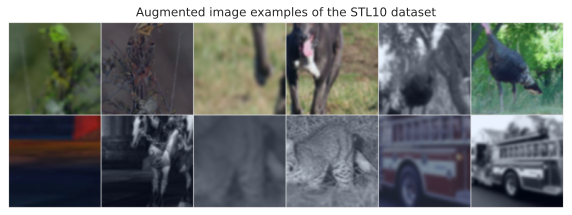

In [6]:
# Visualize some examples
L.seed_everything(42)
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0)
print(imgs.shape)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10, 5))
plt.title("Augmented image examples of the STL10 dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

We see the wide variety of our data augmentation, including randomly cropping, grayscaling, gaussian blur, and color distortion.
Thus, it remains a challenging task for the model to match two, independently augmented patches of the same image.

### SimCLR implementation

Using the data loader pipeline above, we can now implement SimCLR.
At each iteration, we get for every image $x$ two differently augmented versions, which we refer to as $\tilde{x}_i$ and $\tilde{x}_j$.
Both of these images are encoded into a one-dimensional feature vector, between which we want to maximize similarity which minimizes it to all other images in the batch.
The encoder network is split into two parts: a base encoder network $f(\cdot)$, and a projection head $g(\cdot)$.
The base network is usually a deep CNN as we have seen in e.g. [Tutorial 5](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html) before, and is responsible for extracting a representation vector from the augmented data examples.
In our experiments, we will use the common ResNet-18 architecture as $f(\cdot)$, and refer to the output as $f(\tilde{x}_i)=h_i$.
The projection head $g(\cdot)$ maps the representation $h$ into a space where we apply the contrastive loss, i.e., compare similarities between vectors.
It is often chosen to be a small MLP with non-linearities, and for simplicity, we follow the original SimCLR paper setup by defining it as a two-layer MLP with ReLU activation in the hidden layer.
Note that in the follow-up paper, [SimCLRv2](https://arxiv.org/abs/2006.10029), the authors mention that larger/wider MLPs can boost the performance considerably.
This is why we apply an MLP with four times larger hidden dimensions, but deeper MLPs showed to overfit on the given dataset.
The general setup is visualized below (figure credit - [Ting Chen et al. ](https://arxiv.org/abs/2006.10029)):

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/13-contrastive-learning/simclr_network_setup.svg" width="350px"></center>

After finishing the training with contrastive learning, we will remove the projection head $g(\cdot)$, and use $f(\cdot)$ as a pretrained feature extractor.
The representations $z$ that come out of the projection head $g(\cdot)$ have been shown to perform worse than those of the base network $f(\cdot)$ when finetuning the network for a new task.
This is likely because the representations $z$ are trained to become invariant to many features like the color that can be important for downstream tasks.
Thus, $g(\cdot)$ is only needed for the contrastive learning stage.

Now that the architecture is described, let's take a closer look at how we train the model.
As mentioned before, we want to maximize the similarity between the representations of the two augmented versions of the same image, i.e., $z_i$ and $z_j$ in the figure above, while minimizing it to all other examples in the batch.
SimCLR thereby applies the InfoNCE loss, originally proposed by [Aaron van den Oord et al. ](https://arxiv.org/abs/1807.03748) for contrastive learning.
In short, the InfoNCE loss compares the similarity of $z_i$ and $z_j$ to the similarity of $z_i$ to any other representation in the batch by performing a softmax over the similarity values.
The loss can be formally written as:
$$
\ell_{i,j}=-\log \frac{\exp(\text{sim}(z_i,z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)}=-\text{sim}(z_i,z_j)/\tau+\log\left[\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)\right]
$$
The function $\text{sim}$ is a similarity metric, and the hyperparameter $\tau$ is called temperature determining how peaked the distribution is.
Since many similarity metrics are bounded, the temperature parameter allows us to balance the influence of many dissimilar image patches versus one similar patch.
The similarity metric that is used in SimCLR is cosine similarity, as defined below:
$$
\text{sim}(z_i,z_j) = \frac{z_i^\top \cdot z_j}{||z_i||\cdot||z_j||}
$$
The maximum cosine similarity possible is $1$, while the minimum is $-1$.
In general, we will see that the features of two different images will converge to a cosine similarity around zero since the minimum, $-1$, would require $z_i$ and $z_j$ to be in the exact opposite direction in all feature dimensions, which does not allow for great flexibility.

Finally, now that we have discussed all details, let's implement SimCLR below as a PyTorch Lightning module:

In [7]:
from transformers import Swinv2Config, Swinv2Model
class SimCLR(L.LightningModule):
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500, model=MODEL):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, "The temperature must be a positive float!"
        # Base model f(.)
        cfg = Swinv2Config()
        self.model = Swinv2Model(cfg)
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.mlp = nn.Sequential(
            nn.Linear(768, 4*hidden_dim),
            nn.ReLU(),
            nn.Linear(4*hidden_dim, hidden_dim),
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr / 50
        )
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode="train"):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.model(imgs).pooler_output
        feats = self.mlp(feats)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode + "_loss", nll)
        # Get ranking position of positive example
        comb_sim = torch.cat(
            [cos_sim[pos_mask][:, None], cos_sim.masked_fill(pos_mask, -9e15)],  # First position positive example
            dim=-1,
        )
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode + "_acc_top1", (sim_argsort == 0).float().mean())
        self.log(mode + "_acc_top5", (sim_argsort < 5).float().mean())
        self.log(mode + "_acc_mean_pos", 1 + sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode="val")

In [8]:
def train_simclr(batch_size, max_epochs=500, **kwargs):
    trainer = L.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "SimCLR"),
        accelerator="auto",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc_top5"),
            LearningRateMonitor("epoch"),
        ],
    )
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "SimCLR.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        # Automatically loads the model with the saved hyperparameters
        model = SimCLR.load_from_checkpoint(pretrained_filename)
    else:
        train_loader = data.DataLoader(
            unlabeled_data,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True,
            pin_memory=True,
            num_workers=NUM_WORKERS,
        )
        val_loader = data.DataLoader(
            train_data_contrast,
            batch_size=batch_size,
            shuffle=False,
            drop_last=False,
            pin_memory=True,
            num_workers=NUM_WORKERS,
        )
        L.seed_everything(42)  # To be reproducible
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        # Load best checkpoint after training
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    return model

Alternatively to performing the validation on the contrastive learning loss as well, we could also take a simple, small downstream task, and track the performance of the base network $f(\cdot)$ on that.
However, in this tutorial, we will restrict ourselves to the STL10
dataset where we use the task of image classification on STL10 as our
test task.

### Training

Now that we have implemented SimCLR and the data loading pipeline, we are ready to train the model.
We will use the same training function setup as usual.
For saving the best model checkpoint, we track the metric `val_acc_top5`, which describes how often the correct image patch is within the top-5 most similar examples in the batch.
This is usually less noisy than the top-1 metric, making it a better metric to choose the best model from.

A common observation in contrastive learning is that the larger the batch size, the better the models perform.
A larger batch size allows us to compare each image to more negative examples, leading to overall smoother loss gradients.
However, in our case, we experienced that a batch size of 256 was sufficient to get good results.

In [9]:
len(train_data_contrast)

400

In [10]:
simclr_model = train_simclr(
    batch_size=64, hidden_dim=64, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=50
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]

  | Name  | Type        | Params
--------------------------------------
0 | model | Swinv2Model | 27.6 M
1 | mlp   | Sequential  | 213 K 
--------------------------------------
27.8 M    Trainable params
0         Non-trainable params
27.8 M    Total params
111.166   Total estimated model params size (MB)


Sanity Checking: |                                                                                 | 0/? [00:0…

Training: |                                                                                        | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

`Trainer.fit` stopped: `max_epochs=50` reached.


To get an intuition of how training with contrastive learning behaves, we can take a look at the TensorBoard below:

In [24]:
%tensorboard --logdir tensorboards/SimCLR/

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
TensorFlow installation not found - running with reduced feature set.
Traceback (most recent call last):
  File "/home/s4kibart/ba/evaluate_cbr/.venv/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
             ^^^^^^^^^^
  File "/home/s4kibart/ba/evaluate_cbr/.venv/lib/python3.11/site-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/home/s4kibart/ba/evaluate_cbr/.venv/lib/python3.11/site-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/home/s4kibart/ba/evaluate_cbr/.venv/lib/python3.11/site-packages/absl/app.py", line 254, in _run_main
    sys.exit(main(argv))
             ^^^^^^^^^^
  File "/home/s4kibart/ba/evaluate_cbr/.venv/lib/python3.11/site-packages/tensorboard/program.py", line 276, in main
    return runner(self.flags) or 0
           ^^^^^^^^^^^^^^^^^^
  File "/home/s4kibart/ba/evaluate

## Logistic Regression

<div class="center-wrapper"><div class="video-wrapper"><iframe src="https://www.youtube.com/embed/o3FktysLLd4" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></div></div>
After we have trained our model via contrastive learning, we can deploy it on downstream tasks and see how well it performs with little data.
A common setup, which also verifies whether the model has learned generalized representations, is to perform Logistic Regression on the features.
In other words, we learn a single, linear layer that maps the representations to a class prediction.
Since the base network $f(\cdot)$ is not changed during the training process, the model can only perform well if the representations of $h$ describe all features that might be necessary for the task.
Further, we do not have to worry too much about overfitting since we have very few parameters that are trained.
Hence, we might expect that the model can perform well even with very little data.

First, let's implement a simple Logistic Regression setup for which we assume that the images already have been encoded in their feature vectors.
If very little data is available, it might be beneficial to dynamically encode the images during training so that we can also apply data augmentations.
However, the way we implement it here is much more efficient and can be trained within a few seconds.
Further, using data augmentations did not show any significant gain in this simple setup.

In [12]:
class LogisticRegression(L.LightningModule):
    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        # Mapping from representation h to classes
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[int(self.hparams.max_epochs * 0.6), int(self.hparams.max_epochs * 0.8)], gamma=0.1
        )
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        feats, labels = batch
        preds = self.model(feats)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + "_loss", loss)
        self.log(mode + "_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

The data we use is the training and test set of STL10.
The training contains 500 images per class, while the test set has 800 images per class.

In [13]:
from transformers import AutoImageProcessor
processor = AutoImageProcessor.from_pretrained(MODEL)

class Preprocess:
    def __call__(self, x):
        return processor(x, return_tensors="pt")["pixel_values"].squeeze() 
    
pp = Preprocess()
train_img_data = STL10(root=DATASET_PATH, split="train", download=True, transform=pp)
test_img_data = STL10(root=DATASET_PATH, split="test", download=True, transform=pp)

print("Number of training examples:", len(train_img_data))
print("Number of test examples:", len(test_img_data))

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Files already downloaded and verified
Files already downloaded and verified
Number of training examples: 5000
Number of test examples: 8000


Next, we implement a small function to encode all images in our datasets.
The output representations are then used as inputs to the Logistic Regression model.

In [14]:
@torch.no_grad()
def prepare_data_features(model, dataset):
    # Prepare model
    network = deepcopy(model.model)
    network.eval()
    network.to(device)

    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=64, num_workers=20, shuffle=False, drop_last=False)
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs).pooler_output
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # Sort images by labels
    labels, idxs = labels.sort()
    feats = feats[idxs]

    return data.TensorDataset(feats, labels)

Let's apply the function to both training and test set below.

In [15]:
train_feats_simclr = prepare_data_features(simclr_model, train_img_data)
test_feats_simclr = prepare_data_features(simclr_model, test_img_data)

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Finally, we can write a training function as usual.
We evaluate the model on the test set every 10 epochs to allow early
stopping, but the low frequency of the validation ensures that we do not
overfit too much on the test set.

In [16]:
def train_logreg(batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=100, **kwargs):
    trainer = L.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
        accelerator="auto",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
        ],
        enable_progress_bar=False,
        check_val_every_n_epoch=10,
    )
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(
        train_feats_data, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0
    )
    test_loader = data.DataLoader(
        test_feats_data, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0
    )

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"LogisticRegression_{model_suffix}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        L.seed_everything(42)  # To be reproducible
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on train and validation set
    train_result = trainer.test(model, dataloaders=train_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}

    return model, result

Despite the training dataset of STL10 already only having 500 labeled images per class, we will perform experiments with even smaller datasets.
Specifically, we train a Logistic Regression model for datasets with only 10, 20, 50, 100, 200, and all 500 examples per class.
This gives us an intuition on how well the representations learned by contrastive learning can be transferred to a image recognition task like this classification.
First, let's define a function to create the intended sub-datasets from the full training set:

In [17]:
def get_smaller_dataset(original_dataset, num_imgs_per_label):
    new_dataset = data.TensorDataset(
        *(t.unflatten(0, (10, 500))[:, :num_imgs_per_label].flatten(0, 1) for t in original_dataset.tensors)
    )
    return new_dataset

Next, let's run all models.
Despite us training 6 models, this cell could be run within a minute or two without the pretrained models.

In [18]:
results = {}
for num_imgs_per_label in [10, 20, 50, 100, 200, 500]:
    sub_train_set = get_smaller_dataset(train_feats_simclr, num_imgs_per_label)
    _, small_set_results = train_logreg(
        batch_size=64,
        train_feats_data=sub_train_set,
        test_feats_data=test_feats_simclr,
        model_suffix=num_imgs_per_label,
        feature_dim=train_feats_simclr.tensors[0].shape[1],
        num_classes=10,
        lr=1e-3,
        weight_decay=1e-3,
    )
    results[num_imgs_per_label] = small_set_results

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 7.7 K 
---------------------------------
7.7 K     Trainable params
0         Non-trainable params
7.7 K     Total params
0.031     Total estimated model params size (MB)
/home/s4kibart/ba/evaluate_cbr/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.
/home/s4kibart/ba/evaluate_cbr/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Conside

Finally, let's plot the results.

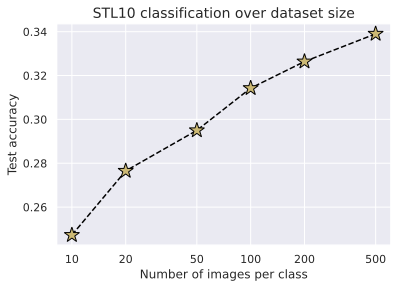

Test accuracy for  10 images per label: 24.73%
Test accuracy for  20 images per label: 27.65%
Test accuracy for  50 images per label: 29.50%
Test accuracy for 100 images per label: 31.43%
Test accuracy for 200 images per label: 32.64%
Test accuracy for 500 images per label: 33.90%


In [19]:
dataset_sizes = sorted(k for k in results)
test_scores = [results[k]["test"] for k in dataset_sizes]

fig = plt.figure(figsize=(6, 4))
plt.plot(
    dataset_sizes,
    test_scores,
    "--",
    color="#000",
    marker="*",
    markeredgecolor="#000",
    markerfacecolor="y",
    markersize=16,
)
plt.xscale("log")
plt.xticks(dataset_sizes, labels=dataset_sizes)
plt.title("STL10 classification over dataset size", fontsize=14)
plt.xlabel("Number of images per class")
plt.ylabel("Test accuracy")
plt.minorticks_off()
plt.show()

for k, score in zip(dataset_sizes, test_scores):
    print(f"Test accuracy for {k:3d} images per label: {100*score:4.2f}%")

As one would expect, the classification performance improves the more data we have.
However, with only 10 images per class, we can already classify more than 60% of the images correctly.
This is quite impressive, considering that the images are also higher dimensional than e.g. CIFAR10.
With the full dataset, we achieve an accuracy of 81%.
The increase between 50 to 500 images per class might suggest a linear increase in performance with an exponentially larger dataset.
However, with even more data, we could also finetune $f(\cdot)$ in the training process, allowing for the representations to adapt more to the specific classification task given.

To set the results above into perspective, we will train the base
network, a ResNet-18, on the classification task from scratch.

## Baseline

As a baseline to our results above, we will train a standard ResNet-18 with random initialization on the labeled training set of STL10.
The results will give us an indication of the advantages that contrastive learning on unlabeled data has compared to using only supervised training.
The implementation of the model is straightforward since the ResNet
architecture is provided in the torchvision library.

In [20]:
class ResNet(L.LightningModule):
    def __init__(self, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        self.model = torchvision.models.resnet18(pretrained=False, num_classes=num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[int(self.hparams.max_epochs * 0.7), int(self.hparams.max_epochs * 0.9)], gamma=0.1
        )
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + "_loss", loss)
        self.log(mode + "_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

It is clear that the ResNet easily overfits on the training data since its parameter count is more than 1000 times larger than the dataset size.
To make the comparison to the contrastive learning models fair, we apply data augmentations similar to the ones we used before: horizontal flip, crop-and-resize, grayscale, and gaussian blur.
Color distortions as before are not used because the color distribution of an image showed to be an important feature for the classification.
Hence, we observed no noticeable performance gains when adding color distortions to the set of augmentations.
Similarly, we restrict the resizing operation before cropping to the max.
125% of its original resolution, instead of 1250% as done in SimCLR.
This is because, for classification, the model needs to recognize the full object, while in contrastive learning, we only want to check whether two patches belong to the same image/object.
Hence, the chosen augmentations below are overall weaker than in the contrastive learning case.

In [21]:
train_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=96, scale=(0.8, 1.0)),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 0.5)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

train_img_aug_data = STL10(root=DATASET_PATH, split="train", download=True, transform=train_transforms)

Files already downloaded and verified


The training function for the ResNet is almost identical to the Logistic Regression setup.
Note that we allow the ResNet to perform validation every 2 epochs to
also check whether the model overfits strongly in the first iterations
or not.

In [22]:
def train_resnet(batch_size, max_epochs=100, **kwargs):
    trainer = L.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "ResNet"),
        accelerator="auto",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
        ],
        check_val_every_n_epoch=2,
    )
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(
        train_img_aug_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        pin_memory=True,
        num_workers=NUM_WORKERS,
    )
    test_loader = data.DataLoader(
        test_img_data, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=NUM_WORKERS
    )

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ResNet.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model at %s, loading..." % pretrained_filename)
        model = ResNet.load_from_checkpoint(pretrained_filename)
    else:
        L.seed_everything(42)  # To be reproducible
        model = ResNet(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = ResNet.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation set
    train_result = trainer.test(model, dataloaders=train_loader, verbose=False)
    val_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": val_result[0]["test_acc"]}

    return model, result

Finally, let's train the model and check its results:

In [23]:
resnet_model, resnet_result = train_resnet(batch_size=64, num_classes=10, lr=1e-3, weight_decay=2e-4, max_epochs=100)
print(f"Accuracy on training set: {100*resnet_result['train']:4.2f}%")
print(f"Accuracy on test set: {100*resnet_result['test']:4.2f}%")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 42
/home/s4kibart/ba/evaluate_cbr/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/s4kibart/ba/evaluate_cbr/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Missing logger folder: saved_models/ContrastiveLearning_VIT/ResNet/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable par

Sanity Checking: |                                                                                 | 0/? [00:0…

Training: |                                                                                        | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]
/home/s4kibart/ba/evaluate_cbr/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |                                                                                         | 0/? [00:0…

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]


Testing: |                                                                                         | 0/? [00:0…

Accuracy on training set: 99.30%
Accuracy on test set: 33.03%


The ResNet trained from scratch achieves 73.31% on the test set.
This is almost 8% less than the contrastive learning model, and even slightly less than SimCLR achieves with 1/10 of the data.
This shows that self-supervised, contrastive learning provides
considerable performance gains by leveraging large amounts of unlabeled
data when little labeled data is available.

## Conclusion

In this tutorial, we have discussed self-supervised contrastive learning and implemented SimCLR as an example method.
We have applied it to the STL10 dataset and showed that it can learn generalizable representations that we can use to train simple classification models.
With 500 images per label, it achieved an 8% higher accuracy than a similar model solely trained from supervision and performs on par with it when only using a tenth of the labeled data.
Our experimental results are limited to a single dataset, but recent works such as [Ting Chen et al. ](https://arxiv.org/abs/2006.10029) showed similar trends for larger datasets like ImageNet.
Besides the discussed hyperparameters, the size of the model seems to be important in contrastive learning as well.
If a lot of unlabeled data is available, larger models can achieve much stronger results and come close to their supervised baselines.
Further, there are also approaches for combining contrastive and supervised learning, leading to performance gains beyond supervision (see [Khosla et al.](https://arxiv.org/abs/2004.11362)).
Moreover, contrastive learning is not the only approach to self-supervised learning that has come up in the last two years and showed great results.
Other methods include distillation-based methods like [BYOL](https://arxiv.org/abs/2006.07733) and redundancy reduction techniques like [Barlow Twins](https://arxiv.org/abs/2103.03230).
There is a lot more to explore in the self-supervised domain, and more, impressive steps ahead are to be expected.

### References

[1] Chen, T., Kornblith, S., Norouzi, M., and Hinton, G. (2020).
A simple framework for contrastive learning of visual representations.
In International conference on machine learning (pp.
1597-1607).
PMLR.
([link](https://arxiv.org/abs/2002.05709))

[2] Chen, T., Kornblith, S., Swersky, K., Norouzi, M., and Hinton, G. (2020).
Big self-supervised models are strong semi-supervised learners.
NeurIPS 2021 ([link](https://arxiv.org/abs/2006.10029)).

[3] Oord, A. V. D., Li, Y., and Vinyals, O.
(2018).
Representation learning with contrastive predictive coding.
arXiv preprint arXiv:1807.03748.
([link](https://arxiv.org/abs/1807.03748))

[4] Grill, J.B., Strub, F., Altché, F., Tallec, C., Richemond, P.H., Buchatskaya, E., Doersch, C., Pires, B.A., Guo, Z.D., Azar, M.G.
and Piot, B.
(2020).
Bootstrap your own latent: A new approach to self-supervised learning.
arXiv preprint arXiv:2006.07733.
([link](https://arxiv.org/abs/2006.07733))

[5] Khosla, P., Teterwak, P., Wang, C., Sarna, A., Tian, Y., Isola, P., Maschinot, A., Liu, C. and Krishnan, D. (2020).
Supervised contrastive learning.
arXiv preprint arXiv:2004.11362.
([link](https://arxiv.org/abs/2004.11362))

[6] Zbontar, J., Jing, L., Misra, I., LeCun, Y. and Deny, S. (2021).
Barlow twins: Self-supervised learning via redundancy reduction.
arXiv preprint arXiv:2103.03230.
([link](https://arxiv.org/abs/2103.03230))

## Congratulations - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the Lightning
movement, you can do so in the following ways!

### Star [Lightning](https://github.com/Lightning-AI/lightning) on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool
tools we're building.

### Join our [Slack](https://www.pytorchlightning.ai/community)!
The best way to keep up to date on the latest advancements is to join our community! Make sure to introduce yourself
and share your interests in `#general` channel


### Contributions !
The best way to contribute to our community is to become a code contributor! At any time you can go to
[Lightning](https://github.com/Lightning-AI/lightning) or [Bolt](https://github.com/Lightning-AI/lightning-bolts)
GitHub Issues page and filter for "good first issue".

* [Lightning good first issue](https://github.com/Lightning-AI/lightning/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* [Bolt good first issue](https://github.com/Lightning-AI/lightning-bolts/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* You can also contribute your own notebooks with useful examples !

### Great thanks from the entire Pytorch Lightning Team for your interest !

[Pytorch Lightning{height="60px" width="240px"}](https://pytorchlightning.ai)